# CXR-ML-GZSL Extension

## Overview

This notebook tests the model described by the paper, ["Multi-Label Generalized Zero Shot Learning for the Classification of Disease in Chest Radiographs"](https://arxiv.org/abs/2107.06563), but with a different visual encoder (EfficientNet-B0). The goal is to measure the impact on AUROC and training time. Due to the project deadline, I cut the dataset and the number of epochs in half.

**Note**: The dataset is ~42 GB. Expect significant download times.

**Note**: The notebook will request access to Google Drive to save training checkpoints. This is to avoid loosing training progress if Google Colab times out.

In [1]:
import argparse
from datetime import datetime, timedelta
import glob
import multiprocessing
import os
import requests
from statistics import mean
import tarfile
import time
import urllib.request

from google.colab import drive

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import table
from PIL import Image
from sklearn.metrics import roc_auc_score
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import models
import torchvision.transforms as transforms
from tqdm import tqdm

In [2]:
DRIVE_PATH = '/content/drive'

if not os.path.ismount(DRIVE_PATH):
    drive.mount(DRIVE_PATH)

DRIVE_PATH = f'{DRIVE_PATH}/MyDrive'

Mounted at /content/drive


In [3]:
seed = 1002
torch.manual_seed(seed)
np.random.seed(seed)

## Environment

In [4]:
!if command -v nvidia-smi &> /dev/null; then nvidia-smi --query-gpu=name --format=csv,noheader; else echo 'No NVIDIA GPU detected'; fi
!echo
!python --version
!echo
!pip list | grep -E "matplotlib|numpy|pandas|pillow|scikit-learn|tqdm|torch|torchvision"

NVIDIA A100-SXM4-40GB

Python 3.11.12

geopandas                             1.0.1
matplotlib                            3.10.0
matplotlib-inline                     0.1.7
matplotlib-venn                       1.1.2
numpy                                 2.0.2
pandas                                2.2.2
pandas-datareader                     0.10.0
pandas-gbq                            0.28.0
pandas-stubs                          2.2.2.240909
pillow                                11.1.0
scikit-learn                          1.6.1
sklearn-pandas                        2.2.0
torch                                 2.6.0+cu124
torchaudio                            2.6.0+cu124
torchsummary                          1.5.1
torchvision                           0.21.0+cu124
tqdm                                  4.67.1


## Download

In [5]:
for filename in ["train.txt", "val.txt", "test.txt"]:
    response = requests.get(f"https://raw.githubusercontent.com/nyuad-cai/CXR-ML-GZSL/master/dataset_splits/{filename}")

    with open(filename, "w") as f:
        f.write(response.text)

    print(f"Downloaded: {filename}")

Downloaded: train.txt
Downloaded: val.txt
Downloaded: test.txt


In [6]:
filename = "Data_Entry_2017_v2020.csv"
response = requests.get('https://drive.google.com/uc?export=download&id=1mkOZNfYt-Px52b8CJZJANNbM3ULUVO3f')

with open(filename, "wb") as file:
    file.write(response.content)

print(f"Downloaded: {filename}")

Downloaded: Data_Entry_2017_v2020.csv


In [7]:
CLASS_EMBEDDINGS = "nih_chest_xray_biobert.npy"

response = requests.get(f"https://raw.githubusercontent.com/nyuad-cai/CXR-ML-GZSL/master/embeddings/{CLASS_EMBEDDINGS}")

with open(CLASS_EMBEDDINGS, "wb") as f:
    f.write(response.content)

print(f"Downloaded: {CLASS_EMBEDDINGS}")

Downloaded: nih_chest_xray_biobert.npy


In [8]:
dataset = [
    {"filename": "images_001.tar.gz", "url": "https://nihcc.box.com/shared/static/vfk49d74nhbxq3nqjg0900w5nvkorp5c.gz"},
    {"filename": "images_002.tar.gz", "url": "https://nihcc.box.com/shared/static/i28rlmbvmfjbl8p2n3ril0pptcmcu9d1.gz"},
    {"filename": "images_003.tar.gz", "url": "https://nihcc.box.com/shared/static/f1t00wrtdk94satdfb9olcolqx20z2jp.gz"},
    {"filename": "images_004.tar.gz", "url": "https://nihcc.box.com/shared/static/0aowwzs5lhjrceb3qp67ahp0rd1l1etg.gz"},
    {"filename": "images_005.tar.gz", "url": "https://nihcc.box.com/shared/static/v5e3goj22zr6h8tzualxfsqlqaygfbsn.gz"},
    {"filename": "images_006.tar.gz", "url": "https://nihcc.box.com/shared/static/asi7ikud9jwnkrnkj99jnpfkjdes7l6l.gz"},
]

for item in dataset:
    filename = item["filename"]
    url = item["url"]

    urllib.request.urlretrieve(url, filename)

    with tarfile.open(filename, "r:gz") as tar:
        tar.extractall()

    os.remove(filename)

    print(f"Downloaded and extracted: {filename}")

IMAGE_PATH = "images"

assert os.path.exists(IMAGE_PATH), "Dataset is not in the expected directory!"

Downloaded and extracted: images_001.tar.gz
Downloaded and extracted: images_002.tar.gz
Downloaded and extracted: images_003.tar.gz
Downloaded and extracted: images_004.tar.gz
Downloaded and extracted: images_005.tar.gz
Downloaded and extracted: images_006.tar.gz


## Dataset

In [9]:
class NIHChestXray(Dataset):
    def __init__ (self, args, pathDatasetFile, transform, classes_to_load='seen', exclude_all=True):
        self.listImagePaths = []
        self.listImageLabels = []
        self.transform = transform
        self.num_classes = args.num_classes

        self._data_path = args.data_root
        self.args = args

        self.split_path = pathDatasetFile
        self.CLASSES = [ 'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia',
                'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia']

        self.unseen_classes = ['Edema', 'Pneumonia', 'Emphysema', 'Fibrosis']

        self.seen_classes = [ 'Atelectasis', 'Effusion', 'Infiltration', 'Mass', 'Nodule',
                'Pneumothorax', 'Consolidation', 'Cardiomegaly', 'Pleural_Thickening', 'Hernia']

        self._class_ids = {v: i for i, v in enumerate(self.CLASSES) if v != 'No Finding'}

        self.seen_class_ids = [self._class_ids[label] for label in self.seen_classes]
        self.unseen_class_ids = [self._class_ids[label] for label in self.unseen_classes]

        self.classes_to_load = classes_to_load
        self.exclude_all = exclude_all
        self._construct_index()

    def _construct_index(self):
        # Compile the split data path
        max_labels = 0
        paths = glob.glob('images/*.png' if self._data_path == '' else f'{self._data_path}/images/*.png')
        self.names_to_path = {path.split('/')[-1]: path for path in paths}
        data_entry_file = 'Data_Entry_2017_v2020.csv'

        print(f'data partition path: {self.split_path}')
        with open(self.split_path, 'r') as f: file_names = f.readlines()

        split_file_names = np.array([file_name.strip().split(' ')[0].split('/')[-1] for file_name in file_names])
        df = pd.read_csv(f'{data_entry_file}' if self._data_path == '' else f'{self._data_path}/{data_entry_file}')
        image_index = df.iloc[:, 0].values

        _, split_index, _ = np.intersect1d(image_index, split_file_names, return_indices=True)

        labels = df.iloc[:, 1].values
        labels = np.array(labels)[split_index]

        labels = [label.split('|') for label in labels]

        image_index = image_index[split_index]

        # Construct the image db
        self._imdb = []
        self.class_ids_loaded = []
        for index in range(len(split_index)):
            if len(labels[index]) == 1 and labels[index][0] == 'No Finding':
                continue
            if self._should_load_image(labels[index]) is False:
                continue
            if image_index[index] not in self.names_to_path.keys():
                continue
            class_ids = [self._class_ids[label] for label in labels[index]]
            self.class_ids_loaded +=class_ids
            self._imdb.append({
                'im_path': self.names_to_path[image_index[index]],
                'labels': class_ids,
            })
            max_labels = max(max_labels, len(class_ids))

        self.class_ids_loaded = np.unique(np.array(self.class_ids_loaded))
        print(f'Number of images: {len(self._imdb)}')
        print(f'Number of max labels per image: {max_labels}')
        print(f'Number of classes: {len(self.class_ids_loaded)}')

    def _should_load_image(self, labels):
        selected_class_labels = self.CLASSES
        if self.classes_to_load == 'seen':
            selected_class_labels = self.seen_classes
        elif self.classes_to_load == 'unseen':
            selected_class_labels = self.unseen_classes
        elif self.classes_to_load == 'all':
            return True

        count = 0
        for label in labels:
            if label in selected_class_labels:
                count+=1

        if count == len(labels):
            # all labels from selected sub set
            return True
        elif count == 0:
            # none label in selected sub set
            return False
        else:
            # some labels in selected sub set
            if self.exclude_all is True:
                return False
            else:
                return True

    def __getitem__(self, index):
        imagePath = self._imdb[index]['im_path']
        imageData = Image.open(imagePath).convert('RGB')
        labels = torch.tensor(self._imdb[index]['labels'])
        labels = labels.unsqueeze(0)
        imageLabel = torch.zeros(labels.size(0), self.num_classes).scatter_(1, labels, 1.).squeeze()
        img = self.transform(imageData)

        return img, imageLabel

    def __len__(self):
        return len(self._imdb)

## Model

In [10]:
class RankingLoss(nn.Module):
    def __init__(self, neg_penalty=0.03):
        super(RankingLoss, self).__init__()

        self.neg_penalty = neg_penalty

    def forward(self, ranks, labels, class_ids_loaded, device):
        '''
        for each correct it should be higher then the absence
        '''
        labels = labels[:, class_ids_loaded]
        ranks_loaded = ranks[:, class_ids_loaded]
        neg_labels = 1+(labels*-1)
        loss_rank = torch.zeros(1).to(device)
        for i in range(len(labels)):
            correct = ranks_loaded[i, labels[i]==1]
            wrong = ranks_loaded[i, neg_labels[i]==1]
            correct = correct.reshape((-1, 1)).repeat((1, len(wrong)))
            wrong = wrong.repeat(len(correct)).reshape(len(correct), -1)
            image_level_penalty = ((self.neg_penalty+wrong) - correct)
            image_level_penalty[image_level_penalty<0]=0
            loss_rank += image_level_penalty.sum()
        loss_rank /=len(labels)

        return loss_rank

class CosineLoss(nn.Module):
    def forward(self, t_emb, v_emb ):
        a_norm = v_emb / v_emb.norm(dim=1)[:, None]
        b_norm = t_emb / t_emb.norm(dim=1)[:, None]
        loss = 1 - torch.mean(torch.diagonal(torch.mm(a_norm, b_norm.t()), 0))

        return loss

class ZSLNet(nn.Module):
    def __init__(self, args, textual_embeddings=None, device='cpu'):
        super(ZSLNet, self).__init__()
        self.args = args
        self.device = device
        self.vision_backbone = getattr(torchvision.models, self.args.vision_backbone)(pretrained=self.args.pretrained)
        # remove classification layer from visual encoder
        classifiers = [ 'classifier', 'fc']
        for classifier in classifiers:
            cls_layer = getattr(self.vision_backbone, classifier, None)
            if cls_layer is None:
                continue
            if isinstance(cls_layer, nn.Sequential):
                last_layer = cls_layer[-1]
                d_visual = last_layer.in_features
            else:
                d_visual = cls_layer.in_features
            setattr(self.vision_backbone, classifier, nn.Identity(d_visual))
            break

        pretrained_encoder = False
        if pretrained_encoder:
            self.vision_backbone.classifier = nn.Identity(d_visual)

            path = 'checkpoints/bce_only_imagenet/last_epoch_checkpoint.pth.tar'

            self.classifier = nn.Sequential(nn.Linear(d_visual, self.args.num_classes), nn.Sigmoid())
            checkpoint = torch.load(path, weights_only=False)
            self.load_state_dict(checkpoint['state_dict'])

            for p in self.vision_backbone.parameters():
                p.requires_grad = False

        if self.args.bce_only:
            self.bce_loss = torch.nn.BCELoss(size_average=True)
            self.classifier = nn.Sequential(nn.Linear(d_visual, self.args.num_classes), nn.Sigmoid())
        else:
            self.emb_loss = CosineLoss()
            self.ranking_loss = RankingLoss(neg_penalty=self.args.neg_penalty)
            self.textual_embeddings = textual_embeddings
            d_textual = self.textual_embeddings.shape[-1]

            self.textual_embeddings = torch.from_numpy(self.textual_embeddings).to(self.device)

            self.fc_v = nn.Sequential(
                nn.Linear(d_visual, 512),
                nn.ReLU(),
                nn.Linear(512, 256),
                nn.ReLU(),
                nn.Linear(256, 128),
            )

            self.fc_t = nn.Sequential(
                nn.Linear(d_textual, 512),
                nn.ReLU(),
                nn.Linear(512, 256),
                nn.ReLU(),
                nn.Linear(256, 128)
            )

    def forward(self, x, labels=None, epoch=0, n_crops=0, bs=16):
        if self.args.bce_only:
            return self.forward_bce_only(x, labels=labels, n_crops=n_crops, bs=bs)
        else:
            return self.forward_ranking(x, labels=labels, epoch=epoch, n_crops=n_crops, bs=bs)

    def forward_bce_only(self, x, labels=None, n_crops=0, bs=16):
        lossvalue_bce = torch.zeros(1).to(self.device)

        visual_feats = self.vision_backbone(x)
        preds = self.classifier(visual_feats)

        if labels is not None:
            lossvalue_bce = self.bce_loss(preds, labels)

        return preds, lossvalue_bce, f'bce:\t {lossvalue_bce.item():0.4f}'

    def forward_ranking(self, x, labels=None, epoch=0, n_crops=0, bs=16):
        loss_rank = torch.zeros(1).to(self.device)
        loss_allignment_cos = torch.zeros(1).to(self.device)
        loss_mapping_consistency = torch.zeros(1).to(self.device)

        visual_feats = self.vision_backbone(x)
        visual_feats = self.fc_v(visual_feats)
        text_feats = self.fc_t(self.textual_embeddings)

        if not self.args.wo_con and epoch >= 0:
            text_mapped_sim = self.sim_score(text_feats, text_feats.detach())
            text_orig_sim = self.sim_score(self.textual_embeddings, self.textual_embeddings)
            loss_mapping_consistency = torch.abs(text_orig_sim - text_mapped_sim).mean()

        if labels is not None:
            mapped_visual, mapped_text = self.map_visual_text(visual_feats, labels, text_feats)
            if mapped_visual is not None and not self.args.wo_map and epoch >= 0:
                loss_allignment_cos = self.emb_loss(mapped_text, mapped_visual)

        ranks = self.sim_score(visual_feats, text_feats)
        if n_crops > 0:
            ranks = ranks.view(bs, n_crops, -1).mean(1)

        if labels is not None:
            loss_rank = self.ranking_loss(ranks, labels, self.class_ids_loaded, self.device)
        loss_allignment_cos = (self.args.beta_map * loss_allignment_cos)
        loss_rank = (self.args.beta_rank * loss_rank)
        loss_mapping_consistency = (self.args.beta_con * loss_mapping_consistency)
        losses = loss_rank + loss_mapping_consistency + loss_allignment_cos

        return ranks, losses

    def sim_score(self, a, b):
        a_norm = a / a.norm(dim=1)[:, None]
        b_norm = b / (1e-6+b.norm(dim=1))[:, None]
        score = (torch.mm(a_norm, b_norm.t()))

        return score

    def map_visual_text(self, visual_feats, labels, labels_embd):
        mapped_labels_embd = []
        labels == 1
        for i in range(0, labels.shape[0]):
            class_embd = labels_embd[labels[i]==1].mean(dim=0)[None,:]
            mapped_labels_embd.append(class_embd)
        mapped_labels_embd = torch.cat(mapped_labels_embd)

        return visual_feats.detach(), mapped_labels_embd.detach()

## Training

In [11]:
def plot_array(array, disc='loss'):
    plt.plot(array)
    plt.ylabel(disc)
    plt.savefig(f'{disc}.pdf')
    plt.close()

class ChexnetTrainer(object):
    def __init__(self, args):
        self.args = args
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.textual_embeddings = np.load(args.textual_embeddings)

        self.model = ZSLNet(self.args, self.textual_embeddings, self.device).to(self.device)
        self.optimizer = optim.Adam (self.model.parameters(), lr=self.args.lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5)
        self.scheduler = ReduceLROnPlateau(self.optimizer, factor=0.01, patience=10, mode='min')

        self.loss = torch.nn.BCELoss(size_average=True)
        self.auroc_min_loss = 0.0

        self.start_epoch = 1
        self.lossMIN = float('inf')
        self.max_auroc_mean = float('-inf')
        self.best_epoch = 1

        self.val_losses = []

        self.resume_from()
        self.load_from()
        self.init_dataset()

        self.steps = [int(step) for step in self.args.steps.split(',')]
        self.time_start = time.time()
        self.time_end = time.time()
        self.should_test = False
        self.model.class_ids_loaded = self.train_dl.dataset.class_ids_loaded

    def __call__(self):
        self.train()

    def load_from(self):
        if self.args.load_from is not None:
            checkpoint = torch.load(self.args.load_from, weights_only=False)
            self.model.load_state_dict(checkpoint['state_dict'])
            print(f'loaded checkpoint from {self.args.load_from}')

    def resume_from(self):
        if self.args.resume_from is not None:
            checkpoint = torch.load(self.args.resume_from, weights_only=False)
            self.model.load_state_dict(checkpoint['state_dict'])
            self.optimizer.load_state_dict(checkpoint['optimizer'])
            self.start_epoch = checkpoint['epoch'] + 1
            self.lossMIN = checkpoint['lossMIN']
            self.max_auroc_mean = checkpoint['max_auroc_mean']
            print(f'resuming training from epoch {self.start_epoch}')

    def save_checkpoint(self, prefix='best'):
        path = f'{self.args.save_dir}/{prefix}_checkpoint.pth.tar'
        torch.save(
            {
            'epoch': self.epoch,
            'state_dict': self.model.state_dict(),
            'max_auroc_mean': self.max_auroc_mean,
            'optimizer' : self.optimizer.state_dict(),
            'lossMIN' : self.lossMIN
            }, path)
        print(f"saving {prefix} checkpoint")

    def init_dataset(self):
        normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

        train_transforms = []
        train_transforms.append(transforms.RandomResizedCrop(self.args.crop))
        train_transforms.append(transforms.RandomHorizontalFlip())
        train_transforms.append(transforms.ToTensor())
        train_transforms.append(normalize)

        datasetTrain = NIHChestXray(self.args, self.args.train_file, transform=transforms.Compose(train_transforms))

        self.train_dl = DataLoader(dataset=datasetTrain, batch_size=self.args.batch_size, shuffle=True,  num_workers=4, pin_memory=True)

        test_transforms = []
        test_transforms.append(transforms.Resize(self.args.resize))
        test_transforms.append(transforms.TenCrop(self.args.crop))
        test_transforms.append(transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])))
        test_transforms.append(transforms.Lambda(lambda crops: torch.stack([normalize(crop) for crop in crops])))

        datasetVal = NIHChestXray(self.args, self.args.val_file, transform=transforms.Compose(test_transforms))
        self.val_dl = DataLoader(dataset=datasetVal, batch_size=self.args.batch_size*10, shuffle=False, num_workers=4, pin_memory=True)

        datasetTest = NIHChestXray(self.args, self.args.test_file, transform=transforms.Compose(test_transforms), classes_to_load='all')
        self.test_dl = DataLoader(dataset=datasetTest, batch_size=self.args.batch_size*3, num_workers=8, shuffle=False, pin_memory=True)
        print(datasetTest.CLASSES)

    def train(self):
        for self.epoch in range(self.start_epoch, self.args.epochs + 1):
            self.epochTrain()
            lossVal, val_ind_auroc = self.epochVal()
            val_ind_auroc = np.array(val_ind_auroc)

            aurocMean = val_ind_auroc.mean()
            self.save_checkpoint(prefix=f'last_epoch')
            self.should_test = False

            if aurocMean > self.max_auroc_mean:
                self.max_auroc_mean = aurocMean
                self.save_checkpoint(prefix='best_auroc')
                self.best_epoch = self.epoch
                self.should_test = True

            if lossVal < self.lossMIN:
                self.lossMIN = lossVal
                self.auroc_min_loss = aurocMean
                self.save_checkpoint(prefix='min_loss')
                self.should_test = True

            self.print_auroc(val_ind_auroc, self.val_dl.dataset.class_ids_loaded, prefix='val')
            if self.should_test is True:
                test_ind_auroc = self.test()
                test_ind_auroc = np.array(test_ind_auroc)

                self.write_results(val_ind_auroc, self.val_dl.dataset.class_ids_loaded, prefix=f'\n\nepoch {self.epoch}\nval', mode='a')

                self.write_results(test_ind_auroc[self.test_dl.dataset.seen_class_ids], self.test_dl.dataset.seen_class_ids, prefix='\ntest_seen', mode='a')
                self.write_results(test_ind_auroc[self.test_dl.dataset.unseen_class_ids], self.test_dl.dataset.unseen_class_ids, prefix='\ntest_unseen', mode='a')

                self.print_auroc(test_ind_auroc[self.test_dl.dataset.seen_class_ids], self.test_dl.dataset.seen_class_ids, prefix='\ntest_seen')
                self.print_auroc(test_ind_auroc[self.test_dl.dataset.unseen_class_ids], self.test_dl.dataset.unseen_class_ids, prefix='\ntest_unseen')

            plot_array(self.val_losses, f'{self.args.save_dir}/val_loss')
            print(f'best epoch {self.best_epoch} best auroc {self.max_auroc_mean} loss {lossVal:.6f} auroc at min loss {self.auroc_min_loss:0.4f}')

            self.scheduler.step(lossVal)

    def get_eta(self, epoch, iter):
        self.time_end = time.time()
        delta = self.time_end - self.time_start
        delta = delta * (len(self.train_dl) * ((self.args.epochs + 1) - epoch) - iter)
        sec = timedelta(seconds=int(delta))
        d = (datetime(1,1,1) + sec)
        eta = f"{d.day-1} Days {d.hour}:{d.minute}:{d.second}"
        self.time_start = time.time()

        return eta

    def epochTrain(self):
        self.model.train()
        epoch_loss = 0
        for batchID, (inputs, target) in enumerate (self.train_dl):

            target = target.to(self.device)
            inputs = inputs.to(self.device)
            output, loss = self.model(inputs, target, self.epoch)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            eta = self.get_eta(self.epoch, batchID)
            epoch_loss +=loss.item()
            if batchID % 100 == 99:
                print(f" epoch [{self.epoch:04d} / {self.args.epochs:04d}] eta: {eta:<20} [{batchID:04}/{len(self.train_dl)}] lr: \t{self.optimizer.param_groups[0]['lr']:0.4E} loss: \t{epoch_loss/batchID:0.5f}")

    def epochVal(self):
        self.model.eval()

        lossVal = 0

        outGT = torch.FloatTensor().to(self.device)
        outPRED = torch.FloatTensor().to(self.device)
        for i, (inputs, target) in enumerate (tqdm(self.val_dl)):
            with torch.no_grad():
                target = target.to(self.device)
                inputs = inputs.to(self.device)
                varTarget = torch.autograd.Variable(target)
                bs, n_crops, c, h, w = inputs.size()

                varInput = torch.autograd.Variable(inputs.view(-1, c, h, w).to(self.device))

                varOutput, losstensor = self.model(varInput, varTarget, n_crops=n_crops, bs=bs)

                outPRED = torch.cat((outPRED, varOutput), 0)
                outGT = torch.cat((outGT, target), 0)

                lossVal+=losstensor.item()
                del varOutput, varTarget, varInput, target, inputs
        lossVal = lossVal / len(self.val_dl)

        aurocIndividual = self.computeAUROC(outGT, outPRED, self.val_dl.dataset.class_ids_loaded)
        self.val_losses.append(lossVal)

        return lossVal, aurocIndividual

    def test(self):
        cudnn.benchmark = True
        outGT = torch.FloatTensor().cuda()
        outPRED = torch.FloatTensor().cuda()

        self.model.eval()

        for i, (inputs, target) in enumerate(tqdm(self.test_dl)):
            with torch.no_grad():
                target = target.to(self.device)
                outGT = torch.cat((outGT, target), 0)

                bs, n_crops, c, h, w = inputs.size()

                varInput = torch.autograd.Variable(inputs.view(-1, c, h, w).to(self.device))

                out, _ = self.model(varInput, n_crops=n_crops, bs=bs)

                outPRED = torch.cat((outPRED, out.data), 0)

        aurocIndividual = self.computeAUROC(outGT, outPRED, self.test_dl.dataset.class_ids_loaded)

        return aurocIndividual

    def computeAUROC(self, dataGT, dataPRED, class_ids):
        outAUROC = []
        datanpGT = dataGT.cpu().numpy()
        datanpPRED = dataPRED.cpu().numpy()

        for i in class_ids:
            outAUROC.append(roc_auc_score(datanpGT[:, i], datanpPRED[:, i]))
        return outAUROC

    def write_results(self, aurocIndividual, class_ids, prefix='val', mode='a'):
        with open(f"{self.args.save_dir}/results.txt", mode) as results_file:
            aurocMean = aurocIndividual.mean()

            results_file.write(f'{prefix} AUROC mean {aurocMean:0.4f}\n')
            for i, class_id in enumerate(class_ids):
                results_file.write(f'{self.val_dl.dataset.CLASSES[class_id]} {aurocIndividual[i]:0.4f}\n')

    def print_auroc(self, aurocIndividual, class_ids, prefix='val'):
        aurocMean = aurocIndividual.mean()

        print (f'{prefix} AUROC mean {aurocMean:0.4f}')

        for i, class_id in enumerate(class_ids):
            print (f'{self.val_dl.dataset.CLASSES[class_id]} {aurocIndividual[i]:0.4f}')

In [12]:
argParser = argparse.ArgumentParser(description='arguments')

argParser.add_argument('--data-root', default='', type=str, help='the path to dataset')
argParser.add_argument('--save-dir', default='', type=str, help='the path to save the checkpoints')
argParser.add_argument('--train-file', default=f'train.txt', type=str, help='the path to train list ')
argParser.add_argument('--val-file', default=f'val.txt', type=str, help='the path to val list ')
argParser.add_argument('--test-file', default=f'test.txt', type=str, help='the path to test list')

argParser.add_argument('--pretrained', dest='pretrained', action='store_true',  help='load imagenet pretrained model')
argParser.add_argument('--bce-only', dest='bce_only', help='train with only binary cross entropy loss', action='store_true')

argParser.add_argument('--num-classes', default=14, type=int, help='number of classes')
argParser.add_argument('--batch-size', default=16, type=int, help='training batch size')
argParser.add_argument('--epochs', default=40, type=int, help='number of epochs to train')
argParser.add_argument('--vision-backbone', default='densenet121', type=str, help='[densenet121, densenet169, densenet201]')
argParser.add_argument('--resume-from', default=None, type=str, help='path to checkpoint to resume the training from')
argParser.add_argument('--load-from', default=None, type=str, help='path to checkpoint to load the weights from')

argParser.add_argument('--resize', default=256, type=int, help='number of epochs to train')
argParser.add_argument('--crop', default=224, type=int, help='number of epochs to train')
argParser.add_argument('--lr', default=0.0001, type=float, help='learning rate')
argParser.add_argument('--steps', default='20, 40, 60, 80', type=str, help='learning rate decay steps comma separated')

argParser.add_argument('--beta-map', default=0.1, type=float, help='learning rate')
argParser.add_argument('--beta-con', default=0.1, type=float, help='learning rate')
argParser.add_argument('--beta-rank', default=1, type=float, help='learning rate')
argParser.add_argument('--neg-penalty', default=0.03, type=float, help='learning rate')

argParser.add_argument('--wo-con', dest='wo_con', help='train with out semantic consistency regularizer loss', action='store_true')
argParser.add_argument('--wo-map', dest='wo_map', help='train with out alignement loss', action='store_true')

argParser.add_argument('--textual-embeddings', default=CLASS_EMBEDDINGS, type=str, help='the path to labels embeddings')

_StoreAction(option_strings=['--textual-embeddings'], dest='textual_embeddings', nargs=None, const=None, default='nih_chest_xray_biobert.npy', type=<class 'str'>, choices=None, required=False, help='the path to labels embeddings', metavar=None)

In [13]:
results = {}

def harmonic_mean(a, b):
    return (2 * a * b) / (a + b)

### DenseNet-121

In [14]:
arg_list = ['--epochs', '50',
            '--neg-penalty', '0.5',
            '--save-dir', DRIVE_PATH,
            '--vision-backbone', 'densenet121']

args = argParser.parse_args(arg_list)

trainer = ChexnetTrainer(args)

start = time.time()
trainer()
end = time.time()

checkpoint = torch.load(f'{DRIVE_PATH}/best_auroc_checkpoint.pth.tar', weights_only=False)
trainer.model.load_state_dict(checkpoint['state_dict'])
test_ind_auroc = trainer.test()
test_ind_auroc = np.array(test_ind_auroc)

results["DenseNet-121"] = {
        "Seen Mean (AUROC)":          test_ind_auroc[trainer.test_dl.dataset.seen_class_ids].mean(),
        "Unseen Mean (AUROC)":        test_ind_auroc[trainer.test_dl.dataset.unseen_class_ids].mean(),
        "Harmonic Mean (AUROC)":      harmonic_mean(test_ind_auroc[trainer.test_dl.dataset.seen_class_ids].mean(), test_ind_auroc[trainer.test_dl.dataset.unseen_class_ids].mean()),
        "Training Time (hours)":      (end - start) / (60 * 60)
}

os.rename(f'{DRIVE_PATH}/best_auroc_checkpoint.pth.tar', f'{DRIVE_PATH}/best_auroc_checkpoint_densenet121.pth.tar')

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


data partition path: train.txt
Number of images: 14160
Number of max labels per image: 6
Number of classes: 10
data partition path: val.txt
Number of images: 1979
Number of max labels per image: 6
Number of classes: 10
data partition path: test.txt
Number of images: 4737
Number of max labels per image: 7
Number of classes: 14
['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia']
 epoch [0001 / 0050] eta: 0 Days 1:11:43       [0099/885] lr: 	1.0000E-04 loss: 	3.74312
 epoch [0001 / 0050] eta: 0 Days 1:12:32       [0199/885] lr: 	1.0000E-04 loss: 	3.72663
 epoch [0001 / 0050] eta: 0 Days 1:11:0        [0299/885] lr: 	1.0000E-04 loss: 	3.71584
 epoch [0001 / 0050] eta: 0 Days 1:9:37        [0399/885] lr: 	1.0000E-04 loss: 	3.67421
 epoch [0001 / 0050] eta: 0 Days 1:9:45        [0499/885] lr: 	1.0000E-04 loss: 	3.64674
 epoch [0001 / 0050] eta: 0 Days 1:11

100%|██████████| 13/13 [00:23<00:00,  1.77s/it]


saving last_epoch checkpoint
saving best_auroc checkpoint
saving min_loss checkpoint
val AUROC mean 0.6169
Atelectasis 0.6276
Cardiomegaly 0.5858
Effusion 0.6163
Infiltration 0.5654
Mass 0.5247
Nodule 0.6029
Pneumothorax 0.6067
Consolidation 0.6632
Pleural_Thickening 0.5803
Hernia 0.7956


100%|██████████| 99/99 [00:34<00:00,  2.84it/s]



test_seen AUROC mean 0.6033
Atelectasis 0.5829
Effusion 0.6087
Infiltration 0.5663
Mass 0.5364
Nodule 0.6465
Pneumothorax 0.5362
Consolidation 0.6402
Cardiomegaly 0.5871
Pleural_Thickening 0.5864
Hernia 0.7426

test_unseen AUROC mean 0.4808
Edema 0.6268
Pneumonia 0.4609
Emphysema 0.4647
Fibrosis 0.3707
best epoch 1 best auroc 0.6168627382880437 loss 3.437547 auroc at min loss 0.6169
 epoch [0002 / 0050] eta: 0 Days 1:8:50        [0099/885] lr: 	1.0000E-04 loss: 	3.51329
 epoch [0002 / 0050] eta: 0 Days 1:10:45       [0199/885] lr: 	1.0000E-04 loss: 	3.55583
 epoch [0002 / 0050] eta: 0 Days 1:9:16        [0299/885] lr: 	1.0000E-04 loss: 	3.53812
 epoch [0002 / 0050] eta: 0 Days 1:8:19        [0399/885] lr: 	1.0000E-04 loss: 	3.54368
 epoch [0002 / 0050] eta: 0 Days 1:18:43       [0499/885] lr: 	1.0000E-04 loss: 	3.52608
 epoch [0002 / 0050] eta: 0 Days 1:8:7         [0599/885] lr: 	1.0000E-04 loss: 	3.53067
 epoch [0002 / 0050] eta: 0 Days 1:8:8         [0699/885] lr: 	1.0000E-04 loss:

100%|██████████| 13/13 [00:22<00:00,  1.70s/it]


saving last_epoch checkpoint
saving min_loss checkpoint
val AUROC mean 0.6061
Atelectasis 0.6260
Cardiomegaly 0.5158
Effusion 0.5587
Infiltration 0.5611
Mass 0.5941
Nodule 0.6171
Pneumothorax 0.6054
Consolidation 0.6108
Pleural_Thickening 0.5863
Hernia 0.7861


100%|██████████| 99/99 [00:29<00:00,  3.30it/s]



test_seen AUROC mean 0.5928
Atelectasis 0.5618
Effusion 0.5646
Infiltration 0.5604
Mass 0.5714
Nodule 0.6357
Pneumothorax 0.5509
Consolidation 0.6050
Cardiomegaly 0.5358
Pleural_Thickening 0.5906
Hernia 0.7517

test_unseen AUROC mean 0.4763
Edema 0.4191
Pneumonia 0.4671
Emphysema 0.4975
Fibrosis 0.5214
best epoch 1 best auroc 0.6168627382880437 loss 3.396542 auroc at min loss 0.6061
 epoch [0003 / 0050] eta: 0 Days 1:23:6        [0099/885] lr: 	1.0000E-04 loss: 	3.65663
 epoch [0003 / 0050] eta: 0 Days 1:6:25        [0199/885] lr: 	1.0000E-04 loss: 	3.60207
 epoch [0003 / 0050] eta: 0 Days 1:6:36        [0299/885] lr: 	1.0000E-04 loss: 	3.57751
 epoch [0003 / 0050] eta: 0 Days 1:7:52        [0399/885] lr: 	1.0000E-04 loss: 	3.55128
 epoch [0003 / 0050] eta: 0 Days 1:6:3         [0499/885] lr: 	1.0000E-04 loss: 	3.51474
 epoch [0003 / 0050] eta: 0 Days 1:18:22       [0599/885] lr: 	1.0000E-04 loss: 	3.50162
 epoch [0003 / 0050] eta: 0 Days 1:8:30        [0699/885] lr: 	1.0000E-04 loss:

100%|██████████| 13/13 [00:22<00:00,  1.73s/it]


saving last_epoch checkpoint
val AUROC mean 0.5953
Atelectasis 0.5587
Cardiomegaly 0.5790
Effusion 0.5029
Infiltration 0.5879
Mass 0.6062
Nodule 0.5983
Pneumothorax 0.6392
Consolidation 0.5638
Pleural_Thickening 0.5752
Hernia 0.7423
best epoch 1 best auroc 0.6168627382880437 loss 3.429231 auroc at min loss 0.6061
 epoch [0004 / 0050] eta: 0 Days 1:15:58       [0099/885] lr: 	1.0000E-04 loss: 	3.41449
 epoch [0004 / 0050] eta: 0 Days 1:6:18        [0199/885] lr: 	1.0000E-04 loss: 	3.43976
 epoch [0004 / 0050] eta: 0 Days 1:6:21        [0299/885] lr: 	1.0000E-04 loss: 	3.44952
 epoch [0004 / 0050] eta: 0 Days 1:5:31        [0399/885] lr: 	1.0000E-04 loss: 	3.45152
 epoch [0004 / 0050] eta: 0 Days 1:6:17        [0499/885] lr: 	1.0000E-04 loss: 	3.45619
 epoch [0004 / 0050] eta: 0 Days 1:6:41        [0599/885] lr: 	1.0000E-04 loss: 	3.45121
 epoch [0004 / 0050] eta: 0 Days 1:6:19        [0699/885] lr: 	1.0000E-04 loss: 	3.45209
 epoch [0004 / 0050] eta: 0 Days 1:5:48        [0799/885] lr: 

100%|██████████| 13/13 [00:22<00:00,  1.73s/it]


saving last_epoch checkpoint
saving min_loss checkpoint
val AUROC mean 0.6092
Atelectasis 0.6208
Cardiomegaly 0.5256
Effusion 0.5974
Infiltration 0.5823
Mass 0.5982
Nodule 0.6092
Pneumothorax 0.5810
Consolidation 0.6322
Pleural_Thickening 0.5523
Hernia 0.7926


100%|██████████| 99/99 [00:29<00:00,  3.32it/s]



test_seen AUROC mean 0.6004
Atelectasis 0.5684
Effusion 0.5893
Infiltration 0.5790
Mass 0.5697
Nodule 0.6323
Pneumothorax 0.5342
Consolidation 0.6359
Cardiomegaly 0.5522
Pleural_Thickening 0.5740
Hernia 0.7694

test_unseen AUROC mean 0.4622
Edema 0.4330
Pneumonia 0.4233
Emphysema 0.4572
Fibrosis 0.5351
best epoch 1 best auroc 0.6168627382880437 loss 3.326457 auroc at min loss 0.6092
 epoch [0005 / 0050] eta: 0 Days 1:4:37        [0099/885] lr: 	1.0000E-04 loss: 	3.47244
 epoch [0005 / 0050] eta: 0 Days 1:15:37       [0199/885] lr: 	1.0000E-04 loss: 	3.40296
 epoch [0005 / 0050] eta: 0 Days 1:3:24        [0299/885] lr: 	1.0000E-04 loss: 	3.43270
 epoch [0005 / 0050] eta: 0 Days 1:3:59        [0399/885] lr: 	1.0000E-04 loss: 	3.42533
 epoch [0005 / 0050] eta: 0 Days 1:4:57        [0499/885] lr: 	1.0000E-04 loss: 	3.42488
 epoch [0005 / 0050] eta: 0 Days 1:6:16        [0599/885] lr: 	1.0000E-04 loss: 	3.40773
 epoch [0005 / 0050] eta: 0 Days 1:5:29        [0699/885] lr: 	1.0000E-04 loss:

100%|██████████| 13/13 [00:22<00:00,  1.73s/it]


saving last_epoch checkpoint
saving best_auroc checkpoint
val AUROC mean 0.6169
Atelectasis 0.5937
Cardiomegaly 0.6227
Effusion 0.5298
Infiltration 0.5845
Mass 0.6213
Nodule 0.6130
Pneumothorax 0.6414
Consolidation 0.6486
Pleural_Thickening 0.5609
Hernia 0.7534


100%|██████████| 99/99 [00:29<00:00,  3.31it/s]



test_seen AUROC mean 0.6116
Atelectasis 0.5726
Effusion 0.5612
Infiltration 0.5823
Mass 0.5736
Nodule 0.6622
Pneumothorax 0.5540
Consolidation 0.6353
Cardiomegaly 0.6048
Pleural_Thickening 0.5847
Hernia 0.7852

test_unseen AUROC mean 0.4627
Edema 0.3308
Pneumonia 0.4880
Emphysema 0.4798
Fibrosis 0.5520
best epoch 5 best auroc 0.616933879599192 loss 3.331462 auroc at min loss 0.6092
 epoch [0006 / 0050] eta: 0 Days 1:3:24        [0099/885] lr: 	1.0000E-04 loss: 	3.42949
 epoch [0006 / 0050] eta: 0 Days 1:3:21        [0199/885] lr: 	1.0000E-04 loss: 	3.38982
 epoch [0006 / 0050] eta: 0 Days 1:12:17       [0299/885] lr: 	1.0000E-04 loss: 	3.44161
 epoch [0006 / 0050] eta: 0 Days 1:11:16       [0399/885] lr: 	1.0000E-04 loss: 	3.43299
 epoch [0006 / 0050] eta: 0 Days 1:2:23        [0499/885] lr: 	1.0000E-04 loss: 	3.43883
 epoch [0006 / 0050] eta: 0 Days 1:3:19        [0599/885] lr: 	1.0000E-04 loss: 	3.44264
 epoch [0006 / 0050] eta: 0 Days 1:1:36        [0699/885] lr: 	1.0000E-04 loss: 

100%|██████████| 13/13 [00:22<00:00,  1.73s/it]


saving last_epoch checkpoint
saving best_auroc checkpoint
saving min_loss checkpoint
val AUROC mean 0.6222
Atelectasis 0.6607
Cardiomegaly 0.5722
Effusion 0.6114
Infiltration 0.5736
Mass 0.5925
Nodule 0.6128
Pneumothorax 0.6057
Consolidation 0.6586
Pleural_Thickening 0.5169
Hernia 0.8177


100%|██████████| 99/99 [00:30<00:00,  3.27it/s]



test_seen AUROC mean 0.5812
Atelectasis 0.5993
Effusion 0.5772
Infiltration 0.5835
Mass 0.5742
Nodule 0.6428
Pneumothorax 0.5355
Consolidation 0.6523
Cardiomegaly 0.5395
Pleural_Thickening 0.5347
Hernia 0.5730

test_unseen AUROC mean 0.4573
Edema 0.4506
Pneumonia 0.4708
Emphysema 0.4824
Fibrosis 0.4253
best epoch 6 best auroc 0.6222263096318101 loss 3.284991 auroc at min loss 0.6222
 epoch [0007 / 0050] eta: 0 Days 1:11:38       [0099/885] lr: 	1.0000E-04 loss: 	3.36437
 epoch [0007 / 0050] eta: 0 Days 1:2:2         [0199/885] lr: 	1.0000E-04 loss: 	3.38703
 epoch [0007 / 0050] eta: 0 Days 1:1:3         [0299/885] lr: 	1.0000E-04 loss: 	3.41812
 epoch [0007 / 0050] eta: 0 Days 1:0:1         [0399/885] lr: 	1.0000E-04 loss: 	3.42417
 epoch [0007 / 0050] eta: 0 Days 1:1:42        [0499/885] lr: 	1.0000E-04 loss: 	3.42445
 epoch [0007 / 0050] eta: 0 Days 1:1:27        [0599/885] lr: 	1.0000E-04 loss: 	3.41655
 epoch [0007 / 0050] eta: 0 Days 1:2:13        [0699/885] lr: 	1.0000E-04 loss:

100%|██████████| 13/13 [00:22<00:00,  1.73s/it]


saving last_epoch checkpoint
saving min_loss checkpoint
val AUROC mean 0.6197
Atelectasis 0.6466
Cardiomegaly 0.5707
Effusion 0.6351
Infiltration 0.5586
Mass 0.5774
Nodule 0.6315
Pneumothorax 0.6095
Consolidation 0.6323
Pleural_Thickening 0.5414
Hernia 0.7938


100%|██████████| 99/99 [00:29<00:00,  3.33it/s]



test_seen AUROC mean 0.5979
Atelectasis 0.5983
Effusion 0.6213
Infiltration 0.5613
Mass 0.5866
Nodule 0.6492
Pneumothorax 0.5294
Consolidation 0.6125
Cardiomegaly 0.5474
Pleural_Thickening 0.5648
Hernia 0.7082

test_unseen AUROC mean 0.4435
Edema 0.3763
Pneumonia 0.4260
Emphysema 0.4263
Fibrosis 0.5455
best epoch 6 best auroc 0.6222263096318101 loss 3.271959 auroc at min loss 0.6197
 epoch [0008 / 0050] eta: 0 Days 1:10:40       [0099/885] lr: 	1.0000E-04 loss: 	3.43888
 epoch [0008 / 0050] eta: 0 Days 1:2:37        [0199/885] lr: 	1.0000E-04 loss: 	3.43057
 epoch [0008 / 0050] eta: 0 Days 0:59:59       [0299/885] lr: 	1.0000E-04 loss: 	3.40036
 epoch [0008 / 0050] eta: 0 Days 0:59:39       [0399/885] lr: 	1.0000E-04 loss: 	3.40990
 epoch [0008 / 0050] eta: 0 Days 1:0:3         [0499/885] lr: 	1.0000E-04 loss: 	3.41728
 epoch [0008 / 0050] eta: 0 Days 0:58:49       [0599/885] lr: 	1.0000E-04 loss: 	3.41283
 epoch [0008 / 0050] eta: 0 Days 1:0:18        [0699/885] lr: 	1.0000E-04 loss:

100%|██████████| 13/13 [00:22<00:00,  1.76s/it]


saving last_epoch checkpoint
saving best_auroc checkpoint
val AUROC mean 0.6240
Atelectasis 0.6652
Cardiomegaly 0.5541
Effusion 0.6324
Infiltration 0.5749
Mass 0.5701
Nodule 0.6237
Pneumothorax 0.5864
Consolidation 0.6635
Pleural_Thickening 0.5552
Hernia 0.8143


100%|██████████| 99/99 [00:30<00:00,  3.21it/s]



test_seen AUROC mean 0.6010
Atelectasis 0.6061
Effusion 0.6229
Infiltration 0.5769
Mass 0.5777
Nodule 0.6383
Pneumothorax 0.5402
Consolidation 0.6459
Cardiomegaly 0.5680
Pleural_Thickening 0.5756
Hernia 0.6579

test_unseen AUROC mean 0.4737
Edema 0.4109
Pneumonia 0.4546
Emphysema 0.5017
Fibrosis 0.5276
best epoch 8 best auroc 0.6239639856681765 loss 3.297992 auroc at min loss 0.6197
 epoch [0009 / 0050] eta: 0 Days 0:59:16       [0099/885] lr: 	1.0000E-04 loss: 	3.34339
 epoch [0009 / 0050] eta: 0 Days 0:57:37       [0199/885] lr: 	1.0000E-04 loss: 	3.37685
 epoch [0009 / 0050] eta: 0 Days 1:10:4        [0299/885] lr: 	1.0000E-04 loss: 	3.41202
 epoch [0009 / 0050] eta: 0 Days 0:58:18       [0399/885] lr: 	1.0000E-04 loss: 	3.39770
 epoch [0009 / 0050] eta: 0 Days 1:12:33       [0499/885] lr: 	1.0000E-04 loss: 	3.39159
 epoch [0009 / 0050] eta: 0 Days 0:58:2        [0599/885] lr: 	1.0000E-04 loss: 	3.39865
 epoch [0009 / 0050] eta: 0 Days 0:59:50       [0699/885] lr: 	1.0000E-04 loss:

100%|██████████| 13/13 [00:22<00:00,  1.76s/it]


saving last_epoch checkpoint
saving best_auroc checkpoint
saving min_loss checkpoint
val AUROC mean 0.6248
Atelectasis 0.6580
Cardiomegaly 0.5815
Effusion 0.5980
Infiltration 0.5712
Mass 0.5884
Nodule 0.6286
Pneumothorax 0.6452
Consolidation 0.6673
Pleural_Thickening 0.5567
Hernia 0.7535


100%|██████████| 99/99 [00:29<00:00,  3.31it/s]



test_seen AUROC mean 0.6105
Atelectasis 0.6068
Effusion 0.6082
Infiltration 0.5682
Mass 0.5693
Nodule 0.6604
Pneumothorax 0.5571
Consolidation 0.6392
Cardiomegaly 0.5580
Pleural_Thickening 0.5697
Hernia 0.7679

test_unseen AUROC mean 0.4796
Edema 0.4489
Pneumonia 0.4424
Emphysema 0.4922
Fibrosis 0.5347
best epoch 9 best auroc 0.6248418325962554 loss 3.255012 auroc at min loss 0.6248
 epoch [0010 / 0050] eta: 0 Days 0:57:29       [0099/885] lr: 	1.0000E-04 loss: 	3.44052
 epoch [0010 / 0050] eta: 0 Days 0:57:27       [0199/885] lr: 	1.0000E-04 loss: 	3.46050
 epoch [0010 / 0050] eta: 0 Days 0:57:34       [0299/885] lr: 	1.0000E-04 loss: 	3.45453
 epoch [0010 / 0050] eta: 0 Days 1:14:8        [0399/885] lr: 	1.0000E-04 loss: 	3.43223
 epoch [0010 / 0050] eta: 0 Days 0:56:9        [0499/885] lr: 	1.0000E-04 loss: 	3.44069
 epoch [0010 / 0050] eta: 0 Days 0:57:52       [0599/885] lr: 	1.0000E-04 loss: 	3.44136
 epoch [0010 / 0050] eta: 0 Days 0:55:0        [0699/885] lr: 	1.0000E-04 loss:

100%|██████████| 13/13 [00:22<00:00,  1.71s/it]


saving last_epoch checkpoint
saving best_auroc checkpoint
val AUROC mean 0.6258
Atelectasis 0.6080
Cardiomegaly 0.6116
Effusion 0.6027
Infiltration 0.6071
Mass 0.5962
Nodule 0.6080
Pneumothorax 0.6220
Consolidation 0.6471
Pleural_Thickening 0.5607
Hernia 0.7944


100%|██████████| 99/99 [00:30<00:00,  3.30it/s]



test_seen AUROC mean 0.5891
Atelectasis 0.6007
Effusion 0.6097
Infiltration 0.5927
Mass 0.5674
Nodule 0.6433
Pneumothorax 0.5344
Consolidation 0.6326
Cardiomegaly 0.5631
Pleural_Thickening 0.5388
Hernia 0.6088

test_unseen AUROC mean 0.4659
Edema 0.4249
Pneumonia 0.4510
Emphysema 0.4643
Fibrosis 0.5236
best epoch 10 best auroc 0.6257902563193052 loss 3.325802 auroc at min loss 0.6248
 epoch [0011 / 0050] eta: 0 Days 0:59:49       [0099/885] lr: 	1.0000E-04 loss: 	3.43832
 epoch [0011 / 0050] eta: 0 Days 0:54:18       [0199/885] lr: 	1.0000E-04 loss: 	3.40763
 epoch [0011 / 0050] eta: 0 Days 0:56:20       [0299/885] lr: 	1.0000E-04 loss: 	3.37798
 epoch [0011 / 0050] eta: 0 Days 0:56:3        [0399/885] lr: 	1.0000E-04 loss: 	3.37275
 epoch [0011 / 0050] eta: 0 Days 1:9:37        [0499/885] lr: 	1.0000E-04 loss: 	3.37935
 epoch [0011 / 0050] eta: 0 Days 0:54:51       [0599/885] lr: 	1.0000E-04 loss: 	3.39635
 epoch [0011 / 0050] eta: 0 Days 0:55:29       [0699/885] lr: 	1.0000E-04 loss

100%|██████████| 13/13 [00:22<00:00,  1.72s/it]


saving last_epoch checkpoint
saving best_auroc checkpoint
saving min_loss checkpoint
val AUROC mean 0.6290
Atelectasis 0.6876
Cardiomegaly 0.5449
Effusion 0.6240
Infiltration 0.5832
Mass 0.5963
Nodule 0.6350
Pneumothorax 0.6251
Consolidation 0.6568
Pleural_Thickening 0.5507
Hernia 0.7859


100%|██████████| 99/99 [00:30<00:00,  3.30it/s]



test_seen AUROC mean 0.5962
Atelectasis 0.6196
Effusion 0.6030
Infiltration 0.5783
Mass 0.5948
Nodule 0.6490
Pneumothorax 0.5402
Consolidation 0.6350
Cardiomegaly 0.5127
Pleural_Thickening 0.5606
Hernia 0.6688

test_unseen AUROC mean 0.4617
Edema 0.4144
Pneumonia 0.4564
Emphysema 0.4542
Fibrosis 0.5218
best epoch 11 best auroc 0.6289513106956941 loss 3.227484 auroc at min loss 0.6290
 epoch [0012 / 0050] eta: 0 Days 0:55:12       [0099/885] lr: 	1.0000E-04 loss: 	3.54277
 epoch [0012 / 0050] eta: 0 Days 1:7:22        [0199/885] lr: 	1.0000E-04 loss: 	3.43615
 epoch [0012 / 0050] eta: 0 Days 0:55:39       [0299/885] lr: 	1.0000E-04 loss: 	3.37826
 epoch [0012 / 0050] eta: 0 Days 0:53:6        [0399/885] lr: 	1.0000E-04 loss: 	3.36374
 epoch [0012 / 0050] eta: 0 Days 0:54:40       [0499/885] lr: 	1.0000E-04 loss: 	3.38687
 epoch [0012 / 0050] eta: 0 Days 0:54:53       [0599/885] lr: 	1.0000E-04 loss: 	3.40040
 epoch [0012 / 0050] eta: 0 Days 0:54:59       [0699/885] lr: 	1.0000E-04 loss

100%|██████████| 13/13 [00:22<00:00,  1.73s/it]


saving last_epoch checkpoint
val AUROC mean 0.6277
Atelectasis 0.6309
Cardiomegaly 0.5548
Effusion 0.5467
Infiltration 0.5879
Mass 0.5941
Nodule 0.6302
Pneumothorax 0.6869
Consolidation 0.6479
Pleural_Thickening 0.5958
Hernia 0.8019
best epoch 11 best auroc 0.6289513106956941 loss 3.258405 auroc at min loss 0.6290
 epoch [0013 / 0050] eta: 0 Days 0:53:27       [0099/885] lr: 	1.0000E-04 loss: 	3.51588
 epoch [0013 / 0050] eta: 0 Days 0:52:10       [0199/885] lr: 	1.0000E-04 loss: 	3.43454
 epoch [0013 / 0050] eta: 0 Days 0:54:16       [0299/885] lr: 	1.0000E-04 loss: 	3.37789
 epoch [0013 / 0050] eta: 0 Days 0:52:22       [0399/885] lr: 	1.0000E-04 loss: 	3.39656
 epoch [0013 / 0050] eta: 0 Days 0:51:16       [0499/885] lr: 	1.0000E-04 loss: 	3.39111
 epoch [0013 / 0050] eta: 0 Days 0:53:1        [0599/885] lr: 	1.0000E-04 loss: 	3.40941
 epoch [0013 / 0050] eta: 0 Days 1:4:8         [0699/885] lr: 	1.0000E-04 loss: 	3.38594
 epoch [0013 / 0050] eta: 0 Days 0:53:31       [0799/885] lr:

100%|██████████| 13/13 [00:21<00:00,  1.68s/it]


saving last_epoch checkpoint
saving min_loss checkpoint
val AUROC mean 0.6267
Atelectasis 0.6663
Cardiomegaly 0.5265
Effusion 0.6088
Infiltration 0.5723
Mass 0.5939
Nodule 0.6210
Pneumothorax 0.6313
Consolidation 0.6716
Pleural_Thickening 0.5571
Hernia 0.8180


100%|██████████| 99/99 [00:30<00:00,  3.23it/s]



test_seen AUROC mean 0.6001
Atelectasis 0.6244
Effusion 0.6312
Infiltration 0.5738
Mass 0.5604
Nodule 0.6450
Pneumothorax 0.5687
Consolidation 0.6249
Cardiomegaly 0.5085
Pleural_Thickening 0.5761
Hernia 0.6878

test_unseen AUROC mean 0.4789
Edema 0.3951
Pneumonia 0.4486
Emphysema 0.4976
Fibrosis 0.5745
best epoch 11 best auroc 0.6289513106956941 loss 3.216349 auroc at min loss 0.6267
 epoch [0014 / 0050] eta: 0 Days 0:54:42       [0099/885] lr: 	1.0000E-04 loss: 	3.37155
 epoch [0014 / 0050] eta: 0 Days 0:52:39       [0199/885] lr: 	1.0000E-04 loss: 	3.37930
 epoch [0014 / 0050] eta: 0 Days 0:53:18       [0299/885] lr: 	1.0000E-04 loss: 	3.37724
 epoch [0014 / 0050] eta: 0 Days 0:52:37       [0399/885] lr: 	1.0000E-04 loss: 	3.34852
 epoch [0014 / 0050] eta: 0 Days 0:51:26       [0499/885] lr: 	1.0000E-04 loss: 	3.31793
 epoch [0014 / 0050] eta: 0 Days 0:52:59       [0599/885] lr: 	1.0000E-04 loss: 	3.33696
 epoch [0014 / 0050] eta: 0 Days 0:52:43       [0699/885] lr: 	1.0000E-04 loss

100%|██████████| 13/13 [00:22<00:00,  1.72s/it]


saving last_epoch checkpoint
saving best_auroc checkpoint
val AUROC mean 0.6326
Atelectasis 0.6739
Cardiomegaly 0.5453
Effusion 0.6126
Infiltration 0.5944
Mass 0.5779
Nodule 0.6412
Pneumothorax 0.6262
Consolidation 0.6660
Pleural_Thickening 0.5760
Hernia 0.8129


100%|██████████| 99/99 [00:30<00:00,  3.28it/s]



test_seen AUROC mean 0.6121
Atelectasis 0.6249
Effusion 0.6310
Infiltration 0.5816
Mass 0.5728
Nodule 0.6559
Pneumothorax 0.5702
Consolidation 0.6255
Cardiomegaly 0.5566
Pleural_Thickening 0.5785
Hernia 0.7240

test_unseen AUROC mean 0.4832
Edema 0.4541
Pneumonia 0.4395
Emphysema 0.4811
Fibrosis 0.5580
best epoch 14 best auroc 0.6326244219915582 loss 3.218712 auroc at min loss 0.6267
 epoch [0015 / 0050] eta: 0 Days 0:50:46       [0099/885] lr: 	1.0000E-04 loss: 	3.40831
 epoch [0015 / 0050] eta: 0 Days 0:51:11       [0199/885] lr: 	1.0000E-04 loss: 	3.42396
 epoch [0015 / 0050] eta: 0 Days 0:49:52       [0299/885] lr: 	1.0000E-04 loss: 	3.43284
 epoch [0015 / 0050] eta: 0 Days 0:51:1        [0399/885] lr: 	1.0000E-04 loss: 	3.42448
 epoch [0015 / 0050] eta: 0 Days 0:49:54       [0499/885] lr: 	1.0000E-04 loss: 	3.43084
 epoch [0015 / 0050] eta: 0 Days 0:50:6        [0599/885] lr: 	1.0000E-04 loss: 	3.39122
 epoch [0015 / 0050] eta: 0 Days 0:50:29       [0699/885] lr: 	1.0000E-04 loss

100%|██████████| 13/13 [00:22<00:00,  1.74s/it]


saving last_epoch checkpoint
val AUROC mean 0.6135
Atelectasis 0.6255
Cardiomegaly 0.5491
Effusion 0.5543
Infiltration 0.6027
Mass 0.5690
Nodule 0.6345
Pneumothorax 0.6338
Consolidation 0.6578
Pleural_Thickening 0.5249
Hernia 0.7832
best epoch 14 best auroc 0.6326244219915582 loss 3.334046 auroc at min loss 0.6267
 epoch [0016 / 0050] eta: 0 Days 0:51:55       [0099/885] lr: 	1.0000E-04 loss: 	3.49320
 epoch [0016 / 0050] eta: 0 Days 0:49:37       [0199/885] lr: 	1.0000E-04 loss: 	3.44396
 epoch [0016 / 0050] eta: 0 Days 0:50:30       [0299/885] lr: 	1.0000E-04 loss: 	3.42847
 epoch [0016 / 0050] eta: 0 Days 0:50:27       [0399/885] lr: 	1.0000E-04 loss: 	3.40963
 epoch [0016 / 0050] eta: 0 Days 0:50:13       [0499/885] lr: 	1.0000E-04 loss: 	3.38777
 epoch [0016 / 0050] eta: 0 Days 0:48:23       [0599/885] lr: 	1.0000E-04 loss: 	3.39348
 epoch [0016 / 0050] eta: 0 Days 0:49:15       [0699/885] lr: 	1.0000E-04 loss: 	3.37554
 epoch [0016 / 0050] eta: 0 Days 0:48:17       [0799/885] lr:

100%|██████████| 13/13 [00:22<00:00,  1.74s/it]


saving last_epoch checkpoint
saving best_auroc checkpoint
val AUROC mean 0.6376
Atelectasis 0.6504
Cardiomegaly 0.5525
Effusion 0.6237
Infiltration 0.6010
Mass 0.5831
Nodule 0.6416
Pneumothorax 0.6535
Consolidation 0.6674
Pleural_Thickening 0.5565
Hernia 0.8467


100%|██████████| 99/99 [00:30<00:00,  3.26it/s]



test_seen AUROC mean 0.6092
Atelectasis 0.6250
Effusion 0.6366
Infiltration 0.5771
Mass 0.5810
Nodule 0.6493
Pneumothorax 0.5870
Consolidation 0.6514
Cardiomegaly 0.5456
Pleural_Thickening 0.5572
Hernia 0.6818

test_unseen AUROC mean 0.5188
Edema 0.5458
Pneumonia 0.4642
Emphysema 0.4862
Fibrosis 0.5789
best epoch 16 best auroc 0.6376378615910647 loss 3.224558 auroc at min loss 0.6267
 epoch [0017 / 0050] eta: 0 Days 0:48:21       [0099/885] lr: 	1.0000E-04 loss: 	3.31944
 epoch [0017 / 0050] eta: 0 Days 0:47:45       [0199/885] lr: 	1.0000E-04 loss: 	3.28072
 epoch [0017 / 0050] eta: 0 Days 0:53:44       [0299/885] lr: 	1.0000E-04 loss: 	3.32841
 epoch [0017 / 0050] eta: 0 Days 0:47:51       [0399/885] lr: 	1.0000E-04 loss: 	3.34543
 epoch [0017 / 0050] eta: 0 Days 0:47:5        [0499/885] lr: 	1.0000E-04 loss: 	3.35033
 epoch [0017 / 0050] eta: 0 Days 0:46:39       [0599/885] lr: 	1.0000E-04 loss: 	3.34351
 epoch [0017 / 0050] eta: 0 Days 0:47:19       [0699/885] lr: 	1.0000E-04 loss

100%|██████████| 13/13 [00:22<00:00,  1.72s/it]


saving last_epoch checkpoint
saving min_loss checkpoint
val AUROC mean 0.6317
Atelectasis 0.6565
Cardiomegaly 0.5499
Effusion 0.6034
Infiltration 0.5914
Mass 0.5812
Nodule 0.6525
Pneumothorax 0.6592
Consolidation 0.6740
Pleural_Thickening 0.5728
Hernia 0.7763


100%|██████████| 99/99 [00:29<00:00,  3.36it/s]



test_seen AUROC mean 0.6147
Atelectasis 0.6180
Effusion 0.6271
Infiltration 0.5816
Mass 0.6033
Nodule 0.6573
Pneumothorax 0.5782
Consolidation 0.6313
Cardiomegaly 0.5530
Pleural_Thickening 0.5685
Hernia 0.7285

test_unseen AUROC mean 0.5024
Edema 0.4761
Pneumonia 0.4415
Emphysema 0.4981
Fibrosis 0.5939
best epoch 16 best auroc 0.6376378615910647 loss 3.199587 auroc at min loss 0.6317
 epoch [0018 / 0050] eta: 0 Days 0:47:7        [0099/885] lr: 	1.0000E-04 loss: 	3.44347
 epoch [0018 / 0050] eta: 0 Days 0:48:9        [0199/885] lr: 	1.0000E-04 loss: 	3.44353
 epoch [0018 / 0050] eta: 0 Days 0:47:3        [0299/885] lr: 	1.0000E-04 loss: 	3.41365
 epoch [0018 / 0050] eta: 0 Days 0:49:11       [0399/885] lr: 	1.0000E-04 loss: 	3.36499
 epoch [0018 / 0050] eta: 0 Days 0:46:29       [0499/885] lr: 	1.0000E-04 loss: 	3.35508
 epoch [0018 / 0050] eta: 0 Days 0:46:10       [0599/885] lr: 	1.0000E-04 loss: 	3.36785
 epoch [0018 / 0050] eta: 0 Days 0:44:57       [0699/885] lr: 	1.0000E-04 loss

100%|██████████| 13/13 [00:22<00:00,  1.70s/it]


saving last_epoch checkpoint
saving min_loss checkpoint
val AUROC mean 0.6339
Atelectasis 0.6837
Cardiomegaly 0.5433
Effusion 0.6678
Infiltration 0.5887
Mass 0.5689
Nodule 0.6436
Pneumothorax 0.6091
Consolidation 0.6719
Pleural_Thickening 0.5507
Hernia 0.8116


100%|██████████| 99/99 [00:30<00:00,  3.27it/s]



test_seen AUROC mean 0.6073
Atelectasis 0.6422
Effusion 0.6737
Infiltration 0.5805
Mass 0.5803
Nodule 0.6625
Pneumothorax 0.5796
Consolidation 0.6311
Cardiomegaly 0.5718
Pleural_Thickening 0.5614
Hernia 0.5902

test_unseen AUROC mean 0.4882
Edema 0.4900
Pneumonia 0.4294
Emphysema 0.4858
Fibrosis 0.5475
best epoch 16 best auroc 0.6376378615910647 loss 3.199350 auroc at min loss 0.6339
 epoch [0019 / 0050] eta: 0 Days 0:45:33       [0099/885] lr: 	1.0000E-04 loss: 	3.25898
 epoch [0019 / 0050] eta: 0 Days 0:44:31       [0199/885] lr: 	1.0000E-04 loss: 	3.34636
 epoch [0019 / 0050] eta: 0 Days 0:49:19       [0299/885] lr: 	1.0000E-04 loss: 	3.33388
 epoch [0019 / 0050] eta: 0 Days 0:44:54       [0399/885] lr: 	1.0000E-04 loss: 	3.30238
 epoch [0019 / 0050] eta: 0 Days 0:45:12       [0499/885] lr: 	1.0000E-04 loss: 	3.30815
 epoch [0019 / 0050] eta: 0 Days 0:44:17       [0599/885] lr: 	1.0000E-04 loss: 	3.33013
 epoch [0019 / 0050] eta: 0 Days 0:43:41       [0699/885] lr: 	1.0000E-04 loss

100%|██████████| 13/13 [00:22<00:00,  1.73s/it]


saving last_epoch checkpoint
val AUROC mean 0.6296
Atelectasis 0.6633
Cardiomegaly 0.5459
Effusion 0.6797
Infiltration 0.5832
Mass 0.5772
Nodule 0.6155
Pneumothorax 0.6655
Consolidation 0.6674
Pleural_Thickening 0.5050
Hernia 0.7933
best epoch 16 best auroc 0.6376378615910647 loss 3.265544 auroc at min loss 0.6339
 epoch [0020 / 0050] eta: 0 Days 0:51:29       [0099/885] lr: 	1.0000E-04 loss: 	3.29709
 epoch [0020 / 0050] eta: 0 Days 0:43:39       [0199/885] lr: 	1.0000E-04 loss: 	3.30613
 epoch [0020 / 0050] eta: 0 Days 0:46:34       [0299/885] lr: 	1.0000E-04 loss: 	3.33180
 epoch [0020 / 0050] eta: 0 Days 0:43:46       [0399/885] lr: 	1.0000E-04 loss: 	3.32873
 epoch [0020 / 0050] eta: 0 Days 0:43:37       [0499/885] lr: 	1.0000E-04 loss: 	3.34477
 epoch [0020 / 0050] eta: 0 Days 0:43:25       [0599/885] lr: 	1.0000E-04 loss: 	3.35558
 epoch [0020 / 0050] eta: 0 Days 0:44:24       [0699/885] lr: 	1.0000E-04 loss: 	3.35418
 epoch [0020 / 0050] eta: 0 Days 0:46:56       [0799/885] lr:

100%|██████████| 13/13 [00:22<00:00,  1.74s/it]


saving last_epoch checkpoint
saving best_auroc checkpoint
saving min_loss checkpoint
val AUROC mean 0.6452
Atelectasis 0.6824
Cardiomegaly 0.5409
Effusion 0.6193
Infiltration 0.6127
Mass 0.5994
Nodule 0.6448
Pneumothorax 0.6749
Consolidation 0.6807
Pleural_Thickening 0.5587
Hernia 0.8385


100%|██████████| 99/99 [00:30<00:00,  3.25it/s]



test_seen AUROC mean 0.6165
Atelectasis 0.6427
Effusion 0.6397
Infiltration 0.5879
Mass 0.5747
Nodule 0.6568
Pneumothorax 0.5821
Consolidation 0.6430
Cardiomegaly 0.5815
Pleural_Thickening 0.5453
Hernia 0.7118

test_unseen AUROC mean 0.5031
Edema 0.5278
Pneumonia 0.4515
Emphysema 0.4722
Fibrosis 0.5610
best epoch 20 best auroc 0.6452254331545413 loss 3.169709 auroc at min loss 0.6452
 epoch [0021 / 0050] eta: 0 Days 0:43:15       [0099/885] lr: 	1.0000E-04 loss: 	3.37337
 epoch [0021 / 0050] eta: 0 Days 0:43:43       [0199/885] lr: 	1.0000E-04 loss: 	3.39133
 epoch [0021 / 0050] eta: 0 Days 0:42:3        [0299/885] lr: 	1.0000E-04 loss: 	3.40210
 epoch [0021 / 0050] eta: 0 Days 0:42:35       [0399/885] lr: 	1.0000E-04 loss: 	3.38705
 epoch [0021 / 0050] eta: 0 Days 0:45:58       [0499/885] lr: 	1.0000E-04 loss: 	3.36019
 epoch [0021 / 0050] eta: 0 Days 0:40:42       [0599/885] lr: 	1.0000E-04 loss: 	3.35599
 epoch [0021 / 0050] eta: 0 Days 0:41:18       [0699/885] lr: 	1.0000E-04 loss

100%|██████████| 13/13 [00:22<00:00,  1.71s/it]


saving last_epoch checkpoint
saving best_auroc checkpoint
saving min_loss checkpoint
val AUROC mean 0.6474
Atelectasis 0.6875
Cardiomegaly 0.5369
Effusion 0.6805
Infiltration 0.5912
Mass 0.6005
Nodule 0.6437
Pneumothorax 0.6750
Consolidation 0.6675
Pleural_Thickening 0.5701
Hernia 0.8214


100%|██████████| 99/99 [00:30<00:00,  3.27it/s]



test_seen AUROC mean 0.6108
Atelectasis 0.6590
Effusion 0.6766
Infiltration 0.5795
Mass 0.5717
Nodule 0.6638
Pneumothorax 0.5812
Consolidation 0.6394
Cardiomegaly 0.5355
Pleural_Thickening 0.5536
Hernia 0.6480

test_unseen AUROC mean 0.4797
Edema 0.4959
Pneumonia 0.4524
Emphysema 0.4987
Fibrosis 0.4720
best epoch 21 best auroc 0.6474266486580055 loss 3.167147 auroc at min loss 0.6474
 epoch [0022 / 0050] eta: 0 Days 0:46:12       [0099/885] lr: 	1.0000E-04 loss: 	3.39011
 epoch [0022 / 0050] eta: 0 Days 0:40:55       [0199/885] lr: 	1.0000E-04 loss: 	3.31257
 epoch [0022 / 0050] eta: 0 Days 0:40:45       [0299/885] lr: 	1.0000E-04 loss: 	3.30851
 epoch [0022 / 0050] eta: 0 Days 0:40:49       [0399/885] lr: 	1.0000E-04 loss: 	3.30627
 epoch [0022 / 0050] eta: 0 Days 0:41:23       [0499/885] lr: 	1.0000E-04 loss: 	3.31631
 epoch [0022 / 0050] eta: 0 Days 0:39:17       [0599/885] lr: 	1.0000E-04 loss: 	3.33156
 epoch [0022 / 0050] eta: 0 Days 0:40:23       [0699/885] lr: 	1.0000E-04 loss

100%|██████████| 13/13 [00:22<00:00,  1.73s/it]


saving last_epoch checkpoint
val AUROC mean 0.6235
Atelectasis 0.6914
Cardiomegaly 0.4997
Effusion 0.6607
Infiltration 0.6171
Mass 0.5803
Nodule 0.6122
Pneumothorax 0.5950
Consolidation 0.6563
Pleural_Thickening 0.5214
Hernia 0.8005
best epoch 21 best auroc 0.6474266486580055 loss 3.271135 auroc at min loss 0.6474
 epoch [0023 / 0050] eta: 0 Days 0:41:54       [0099/885] lr: 	1.0000E-04 loss: 	3.48377
 epoch [0023 / 0050] eta: 0 Days 0:43:27       [0199/885] lr: 	1.0000E-04 loss: 	3.39596
 epoch [0023 / 0050] eta: 0 Days 0:39:5        [0299/885] lr: 	1.0000E-04 loss: 	3.37128
 epoch [0023 / 0050] eta: 0 Days 0:40:39       [0399/885] lr: 	1.0000E-04 loss: 	3.38092
 epoch [0023 / 0050] eta: 0 Days 0:40:14       [0499/885] lr: 	1.0000E-04 loss: 	3.36566
 epoch [0023 / 0050] eta: 0 Days 0:39:40       [0599/885] lr: 	1.0000E-04 loss: 	3.36128
 epoch [0023 / 0050] eta: 0 Days 0:45:29       [0699/885] lr: 	1.0000E-04 loss: 	3.34109
 epoch [0023 / 0050] eta: 0 Days 0:39:15       [0799/885] lr:

100%|██████████| 13/13 [00:21<00:00,  1.68s/it]


saving last_epoch checkpoint
saving best_auroc checkpoint
val AUROC mean 0.6492
Atelectasis 0.6582
Cardiomegaly 0.5665
Effusion 0.6790
Infiltration 0.5912
Mass 0.5874
Nodule 0.6547
Pneumothorax 0.6804
Consolidation 0.6815
Pleural_Thickening 0.6019
Hernia 0.7915


100%|██████████| 99/99 [00:30<00:00,  3.22it/s]



test_seen AUROC mean 0.6273
Atelectasis 0.6265
Effusion 0.6864
Infiltration 0.5749
Mass 0.5748
Nodule 0.6702
Pneumothorax 0.5900
Consolidation 0.6500
Cardiomegaly 0.5990
Pleural_Thickening 0.5700
Hernia 0.7315

test_unseen AUROC mean 0.5326
Edema 0.5813
Pneumonia 0.4541
Emphysema 0.4964
Fibrosis 0.5987
best epoch 23 best auroc 0.6492262340430204 loss 3.231467 auroc at min loss 0.6474
 epoch [0024 / 0050] eta: 0 Days 0:38:56       [0099/885] lr: 	1.0000E-04 loss: 	3.40913
 epoch [0024 / 0050] eta: 0 Days 0:45:39       [0199/885] lr: 	1.0000E-04 loss: 	3.40172
 epoch [0024 / 0050] eta: 0 Days 0:40:7        [0299/885] lr: 	1.0000E-04 loss: 	3.38408
 epoch [0024 / 0050] eta: 0 Days 0:38:26       [0399/885] lr: 	1.0000E-04 loss: 	3.37370
 epoch [0024 / 0050] eta: 0 Days 0:38:14       [0499/885] lr: 	1.0000E-04 loss: 	3.34666
 epoch [0024 / 0050] eta: 0 Days 0:39:34       [0599/885] lr: 	1.0000E-04 loss: 	3.34821
 epoch [0024 / 0050] eta: 0 Days 0:38:37       [0699/885] lr: 	1.0000E-04 loss

100%|██████████| 13/13 [00:22<00:00,  1.73s/it]


saving last_epoch checkpoint
saving best_auroc checkpoint
saving min_loss checkpoint
val AUROC mean 0.6582
Atelectasis 0.6986
Cardiomegaly 0.5769
Effusion 0.6542
Infiltration 0.6069
Mass 0.5891
Nodule 0.6564
Pneumothorax 0.7066
Consolidation 0.6780
Pleural_Thickening 0.5887
Hernia 0.8261


100%|██████████| 99/99 [00:29<00:00,  3.32it/s]



test_seen AUROC mean 0.6351
Atelectasis 0.6499
Effusion 0.6697
Infiltration 0.6031
Mass 0.5765
Nodule 0.6652
Pneumothorax 0.6050
Consolidation 0.6462
Cardiomegaly 0.6270
Pleural_Thickening 0.5614
Hernia 0.7467

test_unseen AUROC mean 0.5263
Edema 0.6466
Pneumonia 0.4454
Emphysema 0.4793
Fibrosis 0.5339
best epoch 24 best auroc 0.6581540447420432 loss 3.118260 auroc at min loss 0.6582
 epoch [0025 / 0050] eta: 0 Days 0:36:36       [0099/885] lr: 	1.0000E-04 loss: 	3.39060
 epoch [0025 / 0050] eta: 0 Days 0:36:22       [0199/885] lr: 	1.0000E-04 loss: 	3.34145
 epoch [0025 / 0050] eta: 0 Days 0:37:4        [0299/885] lr: 	1.0000E-04 loss: 	3.30518
 epoch [0025 / 0050] eta: 0 Days 0:36:24       [0399/885] lr: 	1.0000E-04 loss: 	3.27834
 epoch [0025 / 0050] eta: 0 Days 0:37:37       [0499/885] lr: 	1.0000E-04 loss: 	3.30468
 epoch [0025 / 0050] eta: 0 Days 0:35:19       [0599/885] lr: 	1.0000E-04 loss: 	3.30698
 epoch [0025 / 0050] eta: 0 Days 0:35:16       [0699/885] lr: 	1.0000E-04 loss

100%|██████████| 13/13 [00:22<00:00,  1.71s/it]


saving last_epoch checkpoint
val AUROC mean 0.6510
Atelectasis 0.7111
Cardiomegaly 0.5770
Effusion 0.6555
Infiltration 0.6147
Mass 0.5865
Nodule 0.6512
Pneumothorax 0.6652
Consolidation 0.6755
Pleural_Thickening 0.5508
Hernia 0.8222
best epoch 24 best auroc 0.6581540447420432 loss 3.155225 auroc at min loss 0.6582
 epoch [0026 / 0050] eta: 0 Days 0:37:48       [0099/885] lr: 	1.0000E-04 loss: 	3.37068
 epoch [0026 / 0050] eta: 0 Days 0:36:3        [0199/885] lr: 	1.0000E-04 loss: 	3.32381
 epoch [0026 / 0050] eta: 0 Days 0:35:38       [0299/885] lr: 	1.0000E-04 loss: 	3.28610
 epoch [0026 / 0050] eta: 0 Days 0:34:53       [0399/885] lr: 	1.0000E-04 loss: 	3.30789
 epoch [0026 / 0050] eta: 0 Days 0:34:21       [0499/885] lr: 	1.0000E-04 loss: 	3.31549
 epoch [0026 / 0050] eta: 0 Days 0:37:47       [0599/885] lr: 	1.0000E-04 loss: 	3.32921
 epoch [0026 / 0050] eta: 0 Days 0:35:0        [0699/885] lr: 	1.0000E-04 loss: 	3.30712
 epoch [0026 / 0050] eta: 0 Days 0:33:58       [0799/885] lr:

100%|██████████| 13/13 [00:22<00:00,  1.71s/it]


saving last_epoch checkpoint
val AUROC mean 0.6500
Atelectasis 0.7008
Cardiomegaly 0.5564
Effusion 0.6494
Infiltration 0.6185
Mass 0.6164
Nodule 0.6563
Pneumothorax 0.6570
Consolidation 0.6862
Pleural_Thickening 0.5301
Hernia 0.8294
best epoch 24 best auroc 0.6581540447420432 loss 3.157333 auroc at min loss 0.6582
 epoch [0027 / 0050] eta: 0 Days 0:37:27       [0099/885] lr: 	1.0000E-04 loss: 	3.17870
 epoch [0027 / 0050] eta: 0 Days 0:34:2        [0199/885] lr: 	1.0000E-04 loss: 	3.26323
 epoch [0027 / 0050] eta: 0 Days 0:34:19       [0299/885] lr: 	1.0000E-04 loss: 	3.28153
 epoch [0027 / 0050] eta: 0 Days 0:33:43       [0399/885] lr: 	1.0000E-04 loss: 	3.27869
 epoch [0027 / 0050] eta: 0 Days 0:33:40       [0499/885] lr: 	1.0000E-04 loss: 	3.29284
 epoch [0027 / 0050] eta: 0 Days 0:35:31       [0599/885] lr: 	1.0000E-04 loss: 	3.28226
 epoch [0027 / 0050] eta: 0 Days 0:33:24       [0699/885] lr: 	1.0000E-04 loss: 	3.28537
 epoch [0027 / 0050] eta: 0 Days 0:34:8        [0799/885] lr:

100%|██████████| 13/13 [00:22<00:00,  1.71s/it]


saving last_epoch checkpoint
saving best_auroc checkpoint
val AUROC mean 0.6594
Atelectasis 0.7112
Cardiomegaly 0.5975
Effusion 0.6898
Infiltration 0.6287
Mass 0.5777
Nodule 0.6441
Pneumothorax 0.6716
Consolidation 0.6749
Pleural_Thickening 0.5606
Hernia 0.8374


100%|██████████| 99/99 [00:29<00:00,  3.31it/s]



test_seen AUROC mean 0.6277
Atelectasis 0.6650
Effusion 0.6906
Infiltration 0.6028
Mass 0.5517
Nodule 0.6604
Pneumothorax 0.6024
Consolidation 0.6470
Cardiomegaly 0.6262
Pleural_Thickening 0.5302
Hernia 0.7011

test_unseen AUROC mean 0.4951
Edema 0.5903
Pneumonia 0.4667
Emphysema 0.4779
Fibrosis 0.4455
best epoch 27 best auroc 0.6593537279311253 loss 3.119957 auroc at min loss 0.6582
 epoch [0028 / 0050] eta: 0 Days 0:33:16       [0099/885] lr: 	1.0000E-04 loss: 	3.21888
 epoch [0028 / 0050] eta: 0 Days 0:34:25       [0199/885] lr: 	1.0000E-04 loss: 	3.23582
 epoch [0028 / 0050] eta: 0 Days 0:32:39       [0299/885] lr: 	1.0000E-04 loss: 	3.21111
 epoch [0028 / 0050] eta: 0 Days 0:32:19       [0399/885] lr: 	1.0000E-04 loss: 	3.23349
 epoch [0028 / 0050] eta: 0 Days 0:32:15       [0499/885] lr: 	1.0000E-04 loss: 	3.24320
 epoch [0028 / 0050] eta: 0 Days 0:31:40       [0599/885] lr: 	1.0000E-04 loss: 	3.24364
 epoch [0028 / 0050] eta: 0 Days 0:32:18       [0699/885] lr: 	1.0000E-04 loss

100%|██████████| 13/13 [00:22<00:00,  1.75s/it]


saving last_epoch checkpoint
saving best_auroc checkpoint
saving min_loss checkpoint
val AUROC mean 0.6720
Atelectasis 0.7077
Cardiomegaly 0.6617
Effusion 0.7125
Infiltration 0.6208
Mass 0.5883
Nodule 0.6537
Pneumothorax 0.6834
Consolidation 0.6806
Pleural_Thickening 0.6127
Hernia 0.7988


100%|██████████| 99/99 [00:30<00:00,  3.24it/s]



test_seen AUROC mean 0.6405
Atelectasis 0.6551
Effusion 0.7135
Infiltration 0.5904
Mass 0.5553
Nodule 0.6648
Pneumothorax 0.6253
Consolidation 0.6528
Cardiomegaly 0.6805
Pleural_Thickening 0.5723
Hernia 0.6949

test_unseen AUROC mean 0.5345
Edema 0.6430
Pneumonia 0.4771
Emphysema 0.5063
Fibrosis 0.5115
best epoch 28 best auroc 0.6720037848184439 loss 3.100943 auroc at min loss 0.6720
 epoch [0029 / 0050] eta: 0 Days 0:31:23       [0099/885] lr: 	1.0000E-04 loss: 	3.34493
 epoch [0029 / 0050] eta: 0 Days 0:31:29       [0199/885] lr: 	1.0000E-04 loss: 	3.29014
 epoch [0029 / 0050] eta: 0 Days 0:31:0        [0299/885] lr: 	1.0000E-04 loss: 	3.30503
 epoch [0029 / 0050] eta: 0 Days 0:30:46       [0399/885] lr: 	1.0000E-04 loss: 	3.27321
 epoch [0029 / 0050] eta: 0 Days 0:36:9        [0499/885] lr: 	1.0000E-04 loss: 	3.28646
 epoch [0029 / 0050] eta: 0 Days 0:30:52       [0599/885] lr: 	1.0000E-04 loss: 	3.25297
 epoch [0029 / 0050] eta: 0 Days 0:30:17       [0699/885] lr: 	1.0000E-04 loss

100%|██████████| 13/13 [00:22<00:00,  1.74s/it]


saving last_epoch checkpoint
val AUROC mean 0.6648
Atelectasis 0.7154
Cardiomegaly 0.6072
Effusion 0.6851
Infiltration 0.6231
Mass 0.5985
Nodule 0.6602
Pneumothorax 0.7069
Consolidation 0.6771
Pleural_Thickening 0.5713
Hernia 0.8037
best epoch 28 best auroc 0.6720037848184439 loss 3.117479 auroc at min loss 0.6720
 epoch [0030 / 0050] eta: 0 Days 0:29:22       [0099/885] lr: 	1.0000E-04 loss: 	3.22554
 epoch [0030 / 0050] eta: 0 Days 0:28:59       [0199/885] lr: 	1.0000E-04 loss: 	3.23588
 epoch [0030 / 0050] eta: 0 Days 0:30:8        [0299/885] lr: 	1.0000E-04 loss: 	3.25369
 epoch [0030 / 0050] eta: 0 Days 0:28:58       [0399/885] lr: 	1.0000E-04 loss: 	3.28872
 epoch [0030 / 0050] eta: 0 Days 0:32:41       [0499/885] lr: 	1.0000E-04 loss: 	3.28045
 epoch [0030 / 0050] eta: 0 Days 0:29:16       [0599/885] lr: 	1.0000E-04 loss: 	3.26463
 epoch [0030 / 0050] eta: 0 Days 0:29:3        [0699/885] lr: 	1.0000E-04 loss: 	3.26091
 epoch [0030 / 0050] eta: 0 Days 0:29:27       [0799/885] lr:

100%|██████████| 13/13 [00:22<00:00,  1.72s/it]


saving last_epoch checkpoint
saving best_auroc checkpoint
saving min_loss checkpoint
val AUROC mean 0.6851
Atelectasis 0.7126
Cardiomegaly 0.7416
Effusion 0.6915
Infiltration 0.6164
Mass 0.6274
Nodule 0.6540
Pneumothorax 0.7055
Consolidation 0.6637
Pleural_Thickening 0.6144
Hernia 0.8244


100%|██████████| 99/99 [00:30<00:00,  3.26it/s]



test_seen AUROC mean 0.6507
Atelectasis 0.6736
Effusion 0.6874
Infiltration 0.5995
Mass 0.5843
Nodule 0.6768
Pneumothorax 0.6481
Consolidation 0.6340
Cardiomegaly 0.7367
Pleural_Thickening 0.5744
Hernia 0.6917

test_unseen AUROC mean 0.4922
Edema 0.4827
Pneumonia 0.4655
Emphysema 0.5084
Fibrosis 0.5121
best epoch 30 best auroc 0.6851367359392736 loss 3.046648 auroc at min loss 0.6851
 epoch [0031 / 0050] eta: 0 Days 0:27:47       [0099/885] lr: 	1.0000E-04 loss: 	3.25306
 epoch [0031 / 0050] eta: 0 Days 0:29:30       [0199/885] lr: 	1.0000E-04 loss: 	3.29176
 epoch [0031 / 0050] eta: 0 Days 0:28:22       [0299/885] lr: 	1.0000E-04 loss: 	3.26098
 epoch [0031 / 0050] eta: 0 Days 0:28:31       [0399/885] lr: 	1.0000E-04 loss: 	3.25194
 epoch [0031 / 0050] eta: 0 Days 0:27:46       [0499/885] lr: 	1.0000E-04 loss: 	3.25631
 epoch [0031 / 0050] eta: 0 Days 0:28:9        [0599/885] lr: 	1.0000E-04 loss: 	3.23849
 epoch [0031 / 0050] eta: 0 Days 0:27:6        [0699/885] lr: 	1.0000E-04 loss

100%|██████████| 13/13 [00:22<00:00,  1.74s/it]


saving last_epoch checkpoint
val AUROC mean 0.6814
Atelectasis 0.6916
Cardiomegaly 0.7583
Effusion 0.6662
Infiltration 0.6247
Mass 0.6239
Nodule 0.6561
Pneumothorax 0.6965
Consolidation 0.6839
Pleural_Thickening 0.5922
Hernia 0.8208
best epoch 30 best auroc 0.6851367359392736 loss 3.084932 auroc at min loss 0.6851
 epoch [0032 / 0050] eta: 0 Days 0:26:58       [0099/885] lr: 	1.0000E-04 loss: 	3.31110
 epoch [0032 / 0050] eta: 0 Days 0:26:47       [0199/885] lr: 	1.0000E-04 loss: 	3.22522
 epoch [0032 / 0050] eta: 0 Days 0:27:0        [0299/885] lr: 	1.0000E-04 loss: 	3.23469
 epoch [0032 / 0050] eta: 0 Days 0:26:4        [0399/885] lr: 	1.0000E-04 loss: 	3.22814
 epoch [0032 / 0050] eta: 0 Days 0:26:43       [0499/885] lr: 	1.0000E-04 loss: 	3.22482
 epoch [0032 / 0050] eta: 0 Days 0:25:43       [0599/885] lr: 	1.0000E-04 loss: 	3.22103
 epoch [0032 / 0050] eta: 0 Days 0:28:15       [0699/885] lr: 	1.0000E-04 loss: 	3.22395
 epoch [0032 / 0050] eta: 0 Days 0:28:43       [0799/885] lr:

100%|██████████| 13/13 [00:22<00:00,  1.74s/it]


saving last_epoch checkpoint
saving best_auroc checkpoint
saving min_loss checkpoint
val AUROC mean 0.6879
Atelectasis 0.7206
Cardiomegaly 0.7120
Effusion 0.7383
Infiltration 0.6256
Mass 0.6166
Nodule 0.6584
Pneumothorax 0.6975
Consolidation 0.6770
Pleural_Thickening 0.6166
Hernia 0.8169


100%|██████████| 99/99 [00:30<00:00,  3.26it/s]



test_seen AUROC mean 0.6567
Atelectasis 0.6752
Effusion 0.7357
Infiltration 0.5987
Mass 0.5637
Nodule 0.6809
Pneumothorax 0.6662
Consolidation 0.6409
Cardiomegaly 0.7861
Pleural_Thickening 0.5772
Hernia 0.6426

test_unseen AUROC mean 0.5031
Edema 0.5748
Pneumonia 0.4246
Emphysema 0.4878
Fibrosis 0.5251
best epoch 32 best auroc 0.6879436296749762 loss 2.994420 auroc at min loss 0.6879
 epoch [0033 / 0050] eta: 0 Days 0:26:23       [0099/885] lr: 	1.0000E-04 loss: 	3.21600
 epoch [0033 / 0050] eta: 0 Days 0:25:2        [0199/885] lr: 	1.0000E-04 loss: 	3.20447
 epoch [0033 / 0050] eta: 0 Days 0:25:46       [0299/885] lr: 	1.0000E-04 loss: 	3.20544
 epoch [0033 / 0050] eta: 0 Days 0:25:21       [0399/885] lr: 	1.0000E-04 loss: 	3.18773
 epoch [0033 / 0050] eta: 0 Days 0:25:12       [0499/885] lr: 	1.0000E-04 loss: 	3.19973
 epoch [0033 / 0050] eta: 0 Days 0:27:1        [0599/885] lr: 	1.0000E-04 loss: 	3.19637
 epoch [0033 / 0050] eta: 0 Days 0:24:36       [0699/885] lr: 	1.0000E-04 loss

100%|██████████| 13/13 [00:22<00:00,  1.75s/it]


saving last_epoch checkpoint
val AUROC mean 0.6863
Atelectasis 0.6943
Cardiomegaly 0.7694
Effusion 0.6815
Infiltration 0.6223
Mass 0.6378
Nodule 0.6659
Pneumothorax 0.6784
Consolidation 0.6867
Pleural_Thickening 0.6074
Hernia 0.8191
best epoch 32 best auroc 0.6879436296749762 loss 3.083447 auroc at min loss 0.6879
 epoch [0034 / 0050] eta: 0 Days 0:24:14       [0099/885] lr: 	1.0000E-04 loss: 	3.28163
 epoch [0034 / 0050] eta: 0 Days 0:23:30       [0199/885] lr: 	1.0000E-04 loss: 	3.20380
 epoch [0034 / 0050] eta: 0 Days 0:24:10       [0299/885] lr: 	1.0000E-04 loss: 	3.18971
 epoch [0034 / 0050] eta: 0 Days 0:23:40       [0399/885] lr: 	1.0000E-04 loss: 	3.20199
 epoch [0034 / 0050] eta: 0 Days 0:23:39       [0499/885] lr: 	1.0000E-04 loss: 	3.19028
 epoch [0034 / 0050] eta: 0 Days 0:23:21       [0599/885] lr: 	1.0000E-04 loss: 	3.19079
 epoch [0034 / 0050] eta: 0 Days 0:23:18       [0699/885] lr: 	1.0000E-04 loss: 	3.19314
 epoch [0034 / 0050] eta: 0 Days 0:22:53       [0799/885] lr:

100%|██████████| 13/13 [00:21<00:00,  1.68s/it]


saving last_epoch checkpoint
saving best_auroc checkpoint
val AUROC mean 0.6915
Atelectasis 0.6965
Cardiomegaly 0.8103
Effusion 0.7420
Infiltration 0.6255
Mass 0.6118
Nodule 0.6444
Pneumothorax 0.6809
Consolidation 0.6887
Pleural_Thickening 0.6175
Hernia 0.7979


100%|██████████| 99/99 [00:29<00:00,  3.31it/s]



test_seen AUROC mean 0.6590
Atelectasis 0.6567
Effusion 0.7398
Infiltration 0.6017
Mass 0.5767
Nodule 0.6723
Pneumothorax 0.6414
Consolidation 0.6510
Cardiomegaly 0.8141
Pleural_Thickening 0.5967
Hernia 0.6399

test_unseen AUROC mean 0.5286
Edema 0.5926
Pneumonia 0.4526
Emphysema 0.5089
Fibrosis 0.5603
best epoch 34 best auroc 0.6915442861817065 loss 3.062239 auroc at min loss 0.6879
 epoch [0035 / 0050] eta: 0 Days 0:26:1        [0099/885] lr: 	1.0000E-04 loss: 	3.25023
 epoch [0035 / 0050] eta: 0 Days 0:24:19       [0199/885] lr: 	1.0000E-04 loss: 	3.15460
 epoch [0035 / 0050] eta: 0 Days 0:22:49       [0299/885] lr: 	1.0000E-04 loss: 	3.16890
 epoch [0035 / 0050] eta: 0 Days 0:22:50       [0399/885] lr: 	1.0000E-04 loss: 	3.17257
 epoch [0035 / 0050] eta: 0 Days 0:22:8        [0499/885] lr: 	1.0000E-04 loss: 	3.16038
 epoch [0035 / 0050] eta: 0 Days 0:21:46       [0599/885] lr: 	1.0000E-04 loss: 	3.16424
 epoch [0035 / 0050] eta: 0 Days 0:22:59       [0699/885] lr: 	1.0000E-04 loss

100%|██████████| 13/13 [00:22<00:00,  1.74s/it]


saving last_epoch checkpoint
saving best_auroc checkpoint
saving min_loss checkpoint
val AUROC mean 0.6958
Atelectasis 0.7131
Cardiomegaly 0.8252
Effusion 0.7505
Infiltration 0.6269
Mass 0.6204
Nodule 0.6443
Pneumothorax 0.6970
Consolidation 0.6792
Pleural_Thickening 0.6260
Hernia 0.7754


100%|██████████| 99/99 [00:30<00:00,  3.25it/s]



test_seen AUROC mean 0.6491
Atelectasis 0.6597
Effusion 0.7399
Infiltration 0.6000
Mass 0.5742
Nodule 0.6751
Pneumothorax 0.6466
Consolidation 0.6414
Cardiomegaly 0.8130
Pleural_Thickening 0.5949
Hernia 0.5459

test_unseen AUROC mean 0.4981
Edema 0.4794
Pneumonia 0.4600
Emphysema 0.5201
Fibrosis 0.5329
best epoch 35 best auroc 0.6958009525137403 loss 2.975743 auroc at min loss 0.6958
 epoch [0036 / 0050] eta: 0 Days 0:21:32       [0099/885] lr: 	1.0000E-04 loss: 	3.18724
 epoch [0036 / 0050] eta: 0 Days 0:21:21       [0199/885] lr: 	1.0000E-04 loss: 	3.17352
 epoch [0036 / 0050] eta: 0 Days 0:21:11       [0299/885] lr: 	1.0000E-04 loss: 	3.15134
 epoch [0036 / 0050] eta: 0 Days 0:20:43       [0399/885] lr: 	1.0000E-04 loss: 	3.16993
 epoch [0036 / 0050] eta: 0 Days 0:20:40       [0499/885] lr: 	1.0000E-04 loss: 	3.18469
 epoch [0036 / 0050] eta: 0 Days 0:20:31       [0599/885] lr: 	1.0000E-04 loss: 	3.17233
 epoch [0036 / 0050] eta: 0 Days 0:20:48       [0699/885] lr: 	1.0000E-04 loss

100%|██████████| 13/13 [00:22<00:00,  1.75s/it]


saving last_epoch checkpoint
saving best_auroc checkpoint
saving min_loss checkpoint
val AUROC mean 0.7009
Atelectasis 0.7417
Cardiomegaly 0.8495
Effusion 0.7330
Infiltration 0.6122
Mass 0.6107
Nodule 0.6443
Pneumothorax 0.7020
Consolidation 0.6990
Pleural_Thickening 0.6351
Hernia 0.7820


100%|██████████| 99/99 [00:30<00:00,  3.29it/s]



test_seen AUROC mean 0.6714
Atelectasis 0.6985
Effusion 0.7343
Infiltration 0.5959
Mass 0.5922
Nodule 0.6782
Pneumothorax 0.6525
Consolidation 0.6582
Cardiomegaly 0.8366
Pleural_Thickening 0.6018
Hernia 0.6658

test_unseen AUROC mean 0.5155
Edema 0.5165
Pneumonia 0.4559
Emphysema 0.5479
Fibrosis 0.5418
best epoch 36 best auroc 0.7009483950592863 loss 2.937429 auroc at min loss 0.7009
 epoch [0037 / 0050] eta: 0 Days 0:19:54       [0099/885] lr: 	1.0000E-04 loss: 	3.03626
 epoch [0037 / 0050] eta: 0 Days 0:20:2        [0199/885] lr: 	1.0000E-04 loss: 	3.11391
 epoch [0037 / 0050] eta: 0 Days 0:20:40       [0299/885] lr: 	1.0000E-04 loss: 	3.09773
 epoch [0037 / 0050] eta: 0 Days 0:19:37       [0399/885] lr: 	1.0000E-04 loss: 	3.10511
 epoch [0037 / 0050] eta: 0 Days 0:19:17       [0499/885] lr: 	1.0000E-04 loss: 	3.11087
 epoch [0037 / 0050] eta: 0 Days 0:19:47       [0599/885] lr: 	1.0000E-04 loss: 	3.12725
 epoch [0037 / 0050] eta: 0 Days 0:18:32       [0699/885] lr: 	1.0000E-04 loss

100%|██████████| 13/13 [00:22<00:00,  1.76s/it]


saving last_epoch checkpoint
val AUROC mean 0.6784
Atelectasis 0.6925
Cardiomegaly 0.8420
Effusion 0.7198
Infiltration 0.6273
Mass 0.6102
Nodule 0.6572
Pneumothorax 0.6673
Consolidation 0.6969
Pleural_Thickening 0.6062
Hernia 0.6644
best epoch 36 best auroc 0.7009483950592863 loss 2.969425 auroc at min loss 0.7009
 epoch [0038 / 0050] eta: 0 Days 0:22:33       [0099/885] lr: 	1.0000E-04 loss: 	3.21007
 epoch [0038 / 0050] eta: 0 Days 0:18:51       [0199/885] lr: 	1.0000E-04 loss: 	3.15335
 epoch [0038 / 0050] eta: 0 Days 0:18:21       [0299/885] lr: 	1.0000E-04 loss: 	3.16856
 epoch [0038 / 0050] eta: 0 Days 0:18:18       [0399/885] lr: 	1.0000E-04 loss: 	3.12638
 epoch [0038 / 0050] eta: 0 Days 0:17:46       [0499/885] lr: 	1.0000E-04 loss: 	3.12154
 epoch [0038 / 0050] eta: 0 Days 0:17:49       [0599/885] lr: 	1.0000E-04 loss: 	3.10785
 epoch [0038 / 0050] eta: 0 Days 0:17:40       [0699/885] lr: 	1.0000E-04 loss: 	3.10445
 epoch [0038 / 0050] eta: 0 Days 0:17:43       [0799/885] lr:

100%|██████████| 13/13 [00:22<00:00,  1.72s/it]


saving last_epoch checkpoint
saving best_auroc checkpoint
saving min_loss checkpoint
val AUROC mean 0.7047
Atelectasis 0.7459
Cardiomegaly 0.8472
Effusion 0.7395
Infiltration 0.6300
Mass 0.6221
Nodule 0.6506
Pneumothorax 0.7075
Consolidation 0.7064
Pleural_Thickening 0.6224
Hernia 0.7758


100%|██████████| 99/99 [00:30<00:00,  3.29it/s]



test_seen AUROC mean 0.6717
Atelectasis 0.6984
Effusion 0.7291
Infiltration 0.5992
Mass 0.5733
Nodule 0.6731
Pneumothorax 0.6629
Consolidation 0.6543
Cardiomegaly 0.8435
Pleural_Thickening 0.6071
Hernia 0.6758

test_unseen AUROC mean 0.5078
Edema 0.4635
Pneumonia 0.4754
Emphysema 0.5321
Fibrosis 0.5601
best epoch 38 best auroc 0.7047359805682019 loss 2.868446 auroc at min loss 0.7047
 epoch [0039 / 0050] eta: 0 Days 0:17:26       [0099/885] lr: 	1.0000E-04 loss: 	3.13912
 epoch [0039 / 0050] eta: 0 Days 0:17:6        [0199/885] lr: 	1.0000E-04 loss: 	3.16950
 epoch [0039 / 0050] eta: 0 Days 0:16:39       [0299/885] lr: 	1.0000E-04 loss: 	3.12525
 epoch [0039 / 0050] eta: 0 Days 0:17:18       [0399/885] lr: 	1.0000E-04 loss: 	3.10815
 epoch [0039 / 0050] eta: 0 Days 0:16:16       [0499/885] lr: 	1.0000E-04 loss: 	3.08235
 epoch [0039 / 0050] eta: 0 Days 0:16:6        [0599/885] lr: 	1.0000E-04 loss: 	3.08413
 epoch [0039 / 0050] eta: 0 Days 0:16:5        [0699/885] lr: 	1.0000E-04 loss

100%|██████████| 13/13 [00:22<00:00,  1.73s/it]


saving last_epoch checkpoint
saving best_auroc checkpoint
saving min_loss checkpoint
val AUROC mean 0.7100
Atelectasis 0.7302
Cardiomegaly 0.9011
Effusion 0.7566
Infiltration 0.6397
Mass 0.6247
Nodule 0.6601
Pneumothorax 0.7372
Consolidation 0.6898
Pleural_Thickening 0.6365
Hernia 0.7238


100%|██████████| 99/99 [00:30<00:00,  3.26it/s]



test_seen AUROC mean 0.6658
Atelectasis 0.6972
Effusion 0.7568
Infiltration 0.6108
Mass 0.5905
Nodule 0.6822
Pneumothorax 0.6584
Consolidation 0.6531
Cardiomegaly 0.8516
Pleural_Thickening 0.6013
Hernia 0.5566

test_unseen AUROC mean 0.5255
Edema 0.6054
Pneumonia 0.4668
Emphysema 0.5422
Fibrosis 0.4875
best epoch 39 best auroc 0.709959945279574 loss 2.848779 auroc at min loss 0.7100
 epoch [0040 / 0050] eta: 0 Days 0:15:40       [0099/885] lr: 	1.0000E-04 loss: 	3.17502
 epoch [0040 / 0050] eta: 0 Days 0:15:49       [0199/885] lr: 	1.0000E-04 loss: 	3.10445
 epoch [0040 / 0050] eta: 0 Days 0:15:14       [0299/885] lr: 	1.0000E-04 loss: 	3.08515
 epoch [0040 / 0050] eta: 0 Days 0:15:9        [0399/885] lr: 	1.0000E-04 loss: 	3.10348
 epoch [0040 / 0050] eta: 0 Days 0:15:25       [0499/885] lr: 	1.0000E-04 loss: 	3.09246
 epoch [0040 / 0050] eta: 0 Days 0:14:27       [0599/885] lr: 	1.0000E-04 loss: 	3.08679
 epoch [0040 / 0050] eta: 0 Days 0:14:34       [0699/885] lr: 	1.0000E-04 loss:

100%|██████████| 13/13 [00:22<00:00,  1.70s/it]


saving last_epoch checkpoint
val AUROC mean 0.7027
Atelectasis 0.7401
Cardiomegaly 0.8767
Effusion 0.7621
Infiltration 0.6032
Mass 0.6141
Nodule 0.6541
Pneumothorax 0.7130
Consolidation 0.6963
Pleural_Thickening 0.6251
Hernia 0.7424
best epoch 39 best auroc 0.709959945279574 loss 2.897078 auroc at min loss 0.7100
 epoch [0041 / 0050] eta: 0 Days 0:14:10       [0099/885] lr: 	1.0000E-04 loss: 	3.11569
 epoch [0041 / 0050] eta: 0 Days 0:14:11       [0199/885] lr: 	1.0000E-04 loss: 	3.12680
 epoch [0041 / 0050] eta: 0 Days 0:13:55       [0299/885] lr: 	1.0000E-04 loss: 	3.08837
 epoch [0041 / 0050] eta: 0 Days 0:13:23       [0399/885] lr: 	1.0000E-04 loss: 	3.06203
 epoch [0041 / 0050] eta: 0 Days 0:13:27       [0499/885] lr: 	1.0000E-04 loss: 	3.06316
 epoch [0041 / 0050] eta: 0 Days 0:13:12       [0599/885] lr: 	1.0000E-04 loss: 	3.06122
 epoch [0041 / 0050] eta: 0 Days 0:13:7        [0699/885] lr: 	1.0000E-04 loss: 	3.06157
 epoch [0041 / 0050] eta: 0 Days 0:13:2        [0799/885] lr: 

100%|██████████| 13/13 [00:21<00:00,  1.67s/it]


saving last_epoch checkpoint
val AUROC mean 0.7048
Atelectasis 0.7261
Cardiomegaly 0.9034
Effusion 0.7484
Infiltration 0.6314
Mass 0.6352
Nodule 0.6539
Pneumothorax 0.7156
Consolidation 0.6935
Pleural_Thickening 0.6102
Hernia 0.7306
best epoch 39 best auroc 0.709959945279574 loss 2.872402 auroc at min loss 0.7100
 epoch [0042 / 0050] eta: 0 Days 0:12:50       [0099/885] lr: 	1.0000E-04 loss: 	3.13883
 epoch [0042 / 0050] eta: 0 Days 0:12:38       [0199/885] lr: 	1.0000E-04 loss: 	3.07707
 epoch [0042 / 0050] eta: 0 Days 0:12:10       [0299/885] lr: 	1.0000E-04 loss: 	3.08988
 epoch [0042 / 0050] eta: 0 Days 0:12:4        [0399/885] lr: 	1.0000E-04 loss: 	3.07680
 epoch [0042 / 0050] eta: 0 Days 0:13:51       [0499/885] lr: 	1.0000E-04 loss: 	3.07980
 epoch [0042 / 0050] eta: 0 Days 0:11:44       [0599/885] lr: 	1.0000E-04 loss: 	3.08313
 epoch [0042 / 0050] eta: 0 Days 0:11:58       [0699/885] lr: 	1.0000E-04 loss: 	3.07684
 epoch [0042 / 0050] eta: 0 Days 0:11:36       [0799/885] lr: 

100%|██████████| 13/13 [00:22<00:00,  1.70s/it]


saving last_epoch checkpoint
val AUROC mean 0.6927
Atelectasis 0.7462
Cardiomegaly 0.9025
Effusion 0.7404
Infiltration 0.6100
Mass 0.6115
Nodule 0.6553
Pneumothorax 0.7069
Consolidation 0.6918
Pleural_Thickening 0.6271
Hernia 0.6355
best epoch 39 best auroc 0.709959945279574 loss 2.875591 auroc at min loss 0.7100
 epoch [0043 / 0050] eta: 0 Days 0:11:17       [0099/885] lr: 	1.0000E-04 loss: 	2.94375
 epoch [0043 / 0050] eta: 0 Days 0:11:3        [0199/885] lr: 	1.0000E-04 loss: 	2.96396
 epoch [0043 / 0050] eta: 0 Days 0:11:12       [0299/885] lr: 	1.0000E-04 loss: 	3.01890
 epoch [0043 / 0050] eta: 0 Days 0:10:44       [0399/885] lr: 	1.0000E-04 loss: 	3.03884
 epoch [0043 / 0050] eta: 0 Days 0:13:54       [0499/885] lr: 	1.0000E-04 loss: 	3.05076
 epoch [0043 / 0050] eta: 0 Days 0:10:34       [0599/885] lr: 	1.0000E-04 loss: 	3.04958
 epoch [0043 / 0050] eta: 0 Days 0:10:23       [0699/885] lr: 	1.0000E-04 loss: 	3.04989
 epoch [0043 / 0050] eta: 0 Days 0:11:29       [0799/885] lr: 

100%|██████████| 13/13 [00:21<00:00,  1.68s/it]


saving last_epoch checkpoint
saving min_loss checkpoint
val AUROC mean 0.7083
Atelectasis 0.7404
Cardiomegaly 0.9124
Effusion 0.7468
Infiltration 0.6301
Mass 0.6135
Nodule 0.6618
Pneumothorax 0.7209
Consolidation 0.6884
Pleural_Thickening 0.6137
Hernia 0.7553


100%|██████████| 99/99 [00:30<00:00,  3.21it/s]



test_seen AUROC mean 0.6814
Atelectasis 0.6875
Effusion 0.7306
Infiltration 0.6049
Mass 0.6000
Nodule 0.6690
Pneumothorax 0.6661
Consolidation 0.6645
Cardiomegaly 0.8726
Pleural_Thickening 0.6041
Hernia 0.7142

test_unseen AUROC mean 0.5247
Edema 0.3681
Pneumonia 0.5472
Emphysema 0.5698
Fibrosis 0.6138
best epoch 39 best auroc 0.709959945279574 loss 2.840211 auroc at min loss 0.7083
 epoch [0044 / 0050] eta: 0 Days 0:12:14       [0099/885] lr: 	1.0000E-04 loss: 	3.05166
 epoch [0044 / 0050] eta: 0 Days 0:9:52        [0199/885] lr: 	1.0000E-04 loss: 	3.08306
 epoch [0044 / 0050] eta: 0 Days 0:9:33        [0299/885] lr: 	1.0000E-04 loss: 	3.02712
 epoch [0044 / 0050] eta: 0 Days 0:9:50        [0399/885] lr: 	1.0000E-04 loss: 	3.04968
 epoch [0044 / 0050] eta: 0 Days 0:10:12       [0499/885] lr: 	1.0000E-04 loss: 	3.06105
 epoch [0044 / 0050] eta: 0 Days 0:9:0         [0599/885] lr: 	1.0000E-04 loss: 	3.03306
 epoch [0044 / 0050] eta: 0 Days 0:9:11        [0699/885] lr: 	1.0000E-04 loss:

100%|██████████| 13/13 [00:21<00:00,  1.69s/it]


saving last_epoch checkpoint
val AUROC mean 0.7021
Atelectasis 0.7370
Cardiomegaly 0.8808
Effusion 0.7136
Infiltration 0.6414
Mass 0.6438
Nodule 0.6438
Pneumothorax 0.7262
Consolidation 0.6712
Pleural_Thickening 0.6159
Hernia 0.7477
best epoch 39 best auroc 0.709959945279574 loss 2.898176 auroc at min loss 0.7083
 epoch [0045 / 0050] eta: 0 Days 0:8:25        [0099/885] lr: 	1.0000E-04 loss: 	3.03975
 epoch [0045 / 0050] eta: 0 Days 0:9:35        [0199/885] lr: 	1.0000E-04 loss: 	3.06729
 epoch [0045 / 0050] eta: 0 Days 0:8:4         [0299/885] lr: 	1.0000E-04 loss: 	3.03347
 epoch [0045 / 0050] eta: 0 Days 0:8:7         [0399/885] lr: 	1.0000E-04 loss: 	3.04973
 epoch [0045 / 0050] eta: 0 Days 0:7:56        [0499/885] lr: 	1.0000E-04 loss: 	3.03115
 epoch [0045 / 0050] eta: 0 Days 0:7:34        [0599/885] lr: 	1.0000E-04 loss: 	3.01889
 epoch [0045 / 0050] eta: 0 Days 0:7:32        [0699/885] lr: 	1.0000E-04 loss: 	3.02455
 epoch [0045 / 0050] eta: 0 Days 0:7:13        [0799/885] lr: 

100%|██████████| 13/13 [00:22<00:00,  1.75s/it]


saving last_epoch checkpoint
saving min_loss checkpoint
val AUROC mean 0.7006
Atelectasis 0.7349
Cardiomegaly 0.9137
Effusion 0.7747
Infiltration 0.6192
Mass 0.6771
Nodule 0.6558
Pneumothorax 0.6984
Consolidation 0.6797
Pleural_Thickening 0.6133
Hernia 0.6394


100%|██████████| 99/99 [00:29<00:00,  3.33it/s]



test_seen AUROC mean 0.6725
Atelectasis 0.6958
Effusion 0.7634
Infiltration 0.5981
Mass 0.6058
Nodule 0.6953
Pneumothorax 0.6788
Consolidation 0.6396
Cardiomegaly 0.8575
Pleural_Thickening 0.6213
Hernia 0.5691

test_unseen AUROC mean 0.5131
Edema 0.3926
Pneumonia 0.5009
Emphysema 0.5830
Fibrosis 0.5760
best epoch 39 best auroc 0.709959945279574 loss 2.830238 auroc at min loss 0.7006
 epoch [0046 / 0050] eta: 0 Days 0:7:12        [0099/885] lr: 	1.0000E-04 loss: 	3.10743
 epoch [0046 / 0050] eta: 0 Days 0:7:9         [0199/885] lr: 	1.0000E-04 loss: 	3.07613
 epoch [0046 / 0050] eta: 0 Days 0:6:47        [0299/885] lr: 	1.0000E-04 loss: 	3.02877
 epoch [0046 / 0050] eta: 0 Days 0:6:51        [0399/885] lr: 	1.0000E-04 loss: 	3.03342
 epoch [0046 / 0050] eta: 0 Days 0:6:25        [0499/885] lr: 	1.0000E-04 loss: 	3.01110
 epoch [0046 / 0050] eta: 0 Days 0:6:26        [0599/885] lr: 	1.0000E-04 loss: 	2.98885
 epoch [0046 / 0050] eta: 0 Days 0:6:47        [0699/885] lr: 	1.0000E-04 loss:

100%|██████████| 13/13 [00:22<00:00,  1.74s/it]


saving last_epoch checkpoint
val AUROC mean 0.6929
Atelectasis 0.7255
Cardiomegaly 0.9058
Effusion 0.7412
Infiltration 0.6276
Mass 0.6294
Nodule 0.6587
Pneumothorax 0.7078
Consolidation 0.6798
Pleural_Thickening 0.6185
Hernia 0.6348
best epoch 39 best auroc 0.709959945279574 loss 2.857833 auroc at min loss 0.7006
 epoch [0047 / 0050] eta: 0 Days 0:5:29        [0099/885] lr: 	1.0000E-04 loss: 	3.02540
 epoch [0047 / 0050] eta: 0 Days 0:5:28        [0199/885] lr: 	1.0000E-04 loss: 	3.07518
 epoch [0047 / 0050] eta: 0 Days 0:5:52        [0299/885] lr: 	1.0000E-04 loss: 	3.05355
 epoch [0047 / 0050] eta: 0 Days 0:5:11        [0399/885] lr: 	1.0000E-04 loss: 	3.02168
 epoch [0047 / 0050] eta: 0 Days 0:5:3         [0499/885] lr: 	1.0000E-04 loss: 	2.98755
 epoch [0047 / 0050] eta: 0 Days 0:4:53        [0599/885] lr: 	1.0000E-04 loss: 	2.98256
 epoch [0047 / 0050] eta: 0 Days 0:4:36        [0699/885] lr: 	1.0000E-04 loss: 	2.99335
 epoch [0047 / 0050] eta: 0 Days 0:4:51        [0799/885] lr: 

100%|██████████| 13/13 [00:22<00:00,  1.74s/it]


saving last_epoch checkpoint
val AUROC mean 0.6986
Atelectasis 0.7414
Cardiomegaly 0.9060
Effusion 0.7433
Infiltration 0.6146
Mass 0.6626
Nodule 0.6542
Pneumothorax 0.6978
Consolidation 0.6964
Pleural_Thickening 0.6179
Hernia 0.6520
best epoch 39 best auroc 0.709959945279574 loss 2.880580 auroc at min loss 0.7006
 epoch [0048 / 0050] eta: 0 Days 0:4:14        [0099/885] lr: 	1.0000E-04 loss: 	2.97682
 epoch [0048 / 0050] eta: 0 Days 0:4:2         [0199/885] lr: 	1.0000E-04 loss: 	2.96328
 epoch [0048 / 0050] eta: 0 Days 0:3:56        [0299/885] lr: 	1.0000E-04 loss: 	2.97701
 epoch [0048 / 0050] eta: 0 Days 0:3:40        [0399/885] lr: 	1.0000E-04 loss: 	2.96273
 epoch [0048 / 0050] eta: 0 Days 0:3:41        [0499/885] lr: 	1.0000E-04 loss: 	2.95564
 epoch [0048 / 0050] eta: 0 Days 0:3:17        [0599/885] lr: 	1.0000E-04 loss: 	2.96746
 epoch [0048 / 0050] eta: 0 Days 0:3:13        [0699/885] lr: 	1.0000E-04 loss: 	2.96566
 epoch [0048 / 0050] eta: 0 Days 0:2:56        [0799/885] lr: 

100%|██████████| 13/13 [00:22<00:00,  1.72s/it]


saving last_epoch checkpoint
saving best_auroc checkpoint
val AUROC mean 0.7227
Atelectasis 0.7461
Cardiomegaly 0.8848
Effusion 0.7518
Infiltration 0.6552
Mass 0.6730
Nodule 0.6527
Pneumothorax 0.7442
Consolidation 0.6773
Pleural_Thickening 0.6399
Hernia 0.8022


100%|██████████| 99/99 [00:30<00:00,  3.29it/s]



test_seen AUROC mean 0.6803
Atelectasis 0.7040
Effusion 0.7480
Infiltration 0.6232
Mass 0.6074
Nodule 0.6817
Pneumothorax 0.6843
Consolidation 0.6537
Cardiomegaly 0.8426
Pleural_Thickening 0.6115
Hernia 0.6465

test_unseen AUROC mean 0.5086
Edema 0.4549
Pneumonia 0.4835
Emphysema 0.5520
Fibrosis 0.5440
best epoch 48 best auroc 0.7227156611792489 loss 2.870482 auroc at min loss 0.7006
 epoch [0049 / 0050] eta: 0 Days 0:3:9         [0099/885] lr: 	1.0000E-04 loss: 	3.02653
 epoch [0049 / 0050] eta: 0 Days 0:3:14        [0199/885] lr: 	1.0000E-04 loss: 	2.97393
 epoch [0049 / 0050] eta: 0 Days 0:2:20        [0299/885] lr: 	1.0000E-04 loss: 	2.96084
 epoch [0049 / 0050] eta: 0 Days 0:2:11        [0399/885] lr: 	1.0000E-04 loss: 	2.96806
 epoch [0049 / 0050] eta: 0 Days 0:2:2         [0499/885] lr: 	1.0000E-04 loss: 	2.98057
 epoch [0049 / 0050] eta: 0 Days 0:2:8         [0599/885] lr: 	1.0000E-04 loss: 	2.98186
 epoch [0049 / 0050] eta: 0 Days 0:2:5         [0699/885] lr: 	1.0000E-04 loss

100%|██████████| 13/13 [00:22<00:00,  1.69s/it]


saving last_epoch checkpoint
val AUROC mean 0.7052
Atelectasis 0.7429
Cardiomegaly 0.8981
Effusion 0.7755
Infiltration 0.6279
Mass 0.6775
Nodule 0.6633
Pneumothorax 0.6942
Consolidation 0.6947
Pleural_Thickening 0.6099
Hernia 0.6683
best epoch 48 best auroc 0.7227156611792489 loss 2.859882 auroc at min loss 0.7006
 epoch [0050 / 0050] eta: 0 Days 0:1:25        [0099/885] lr: 	1.0000E-04 loss: 	3.00177
 epoch [0050 / 0050] eta: 0 Days 0:1:22        [0199/885] lr: 	1.0000E-04 loss: 	2.96067
 epoch [0050 / 0050] eta: 0 Days 0:0:55        [0299/885] lr: 	1.0000E-04 loss: 	2.96884
 epoch [0050 / 0050] eta: 0 Days 0:0:46        [0399/885] lr: 	1.0000E-04 loss: 	2.96620
 epoch [0050 / 0050] eta: 0 Days 0:0:36        [0499/885] lr: 	1.0000E-04 loss: 	2.95305
 epoch [0050 / 0050] eta: 0 Days 0:0:30        [0599/885] lr: 	1.0000E-04 loss: 	2.94942
 epoch [0050 / 0050] eta: 0 Days 0:0:17        [0699/885] lr: 	1.0000E-04 loss: 	2.94655
 epoch [0050 / 0050] eta: 0 Days 0:0:8         [0799/885] lr:

100%|██████████| 13/13 [00:22<00:00,  1.72s/it]


saving last_epoch checkpoint
saving best_auroc checkpoint
saving min_loss checkpoint
val AUROC mean 0.7234
Atelectasis 0.7458
Cardiomegaly 0.9021
Effusion 0.7669
Infiltration 0.6443
Mass 0.6989
Nodule 0.6655
Pneumothorax 0.7194
Consolidation 0.6815
Pleural_Thickening 0.6445
Hernia 0.7648


100%|██████████| 99/99 [00:30<00:00,  3.23it/s]



test_seen AUROC mean 0.6864
Atelectasis 0.7108
Effusion 0.7464
Infiltration 0.6243
Mass 0.6423
Nodule 0.6909
Pneumothorax 0.6794
Consolidation 0.6573
Cardiomegaly 0.8701
Pleural_Thickening 0.6252
Hernia 0.6171

test_unseen AUROC mean 0.5400
Edema 0.4650
Pneumonia 0.4888
Emphysema 0.5919
Fibrosis 0.6142
best epoch 50 best auroc 0.7233692576445753 loss 2.762132 auroc at min loss 0.7234


100%|██████████| 99/99 [00:30<00:00,  3.27it/s]


### EfficientNet-B0

In [15]:
arg_list = ['--epochs', '50',
            '--neg-penalty', '0.5',
            '--save-dir', DRIVE_PATH,
            '--vision-backbone', 'efficientnet_b0']

args = argParser.parse_args(arg_list)

trainer = ChexnetTrainer(args)

start = time.time()
trainer()
end = time.time()

checkpoint = torch.load(f'{DRIVE_PATH}/best_auroc_checkpoint.pth.tar', weights_only=False)
trainer.model.load_state_dict(checkpoint['state_dict'])
test_ind_auroc = trainer.test()
test_ind_auroc = np.array(test_ind_auroc)

results["EfficientNet-B0"] = {
        "Seen Mean (AUROC)":          test_ind_auroc[trainer.test_dl.dataset.seen_class_ids].mean(),
        "Unseen Mean (AUROC)":        test_ind_auroc[trainer.test_dl.dataset.unseen_class_ids].mean(),
        "Harmonic Mean (AUROC)":      harmonic_mean(test_ind_auroc[trainer.test_dl.dataset.seen_class_ids].mean(), test_ind_auroc[trainer.test_dl.dataset.unseen_class_ids].mean()),
        "Training Time (hours)":      (end - start) / (60 * 60)
}

os.rename(f'{DRIVE_PATH}/best_auroc_checkpoint.pth.tar', f'{DRIVE_PATH}/best_auroc_checkpoint_efficientnet_b0.pth.tar')

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


data partition path: train.txt
Number of images: 14160
Number of max labels per image: 6
Number of classes: 10
data partition path: val.txt
Number of images: 1979
Number of max labels per image: 6
Number of classes: 10
data partition path: test.txt
Number of images: 4737
Number of max labels per image: 7
Number of classes: 14
['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia']
 epoch [0001 / 0050] eta: 0 Days 0:47:12       [0099/885] lr: 	1.0000E-04 loss: 	3.74198
 epoch [0001 / 0050] eta: 0 Days 0:45:54       [0199/885] lr: 	1.0000E-04 loss: 	3.67114
 epoch [0001 / 0050] eta: 0 Days 0:53:58       [0299/885] lr: 	1.0000E-04 loss: 	3.67684
 epoch [0001 / 0050] eta: 0 Days 0:44:35       [0399/885] lr: 	1.0000E-04 loss: 	3.65382
 epoch [0001 / 0050] eta: 0 Days 0:46:7        [0499/885] lr: 	1.0000E-04 loss: 	3.64261
 epoch [0001 / 0050] eta: 0 Days 0:45

100%|██████████| 13/13 [00:21<00:00,  1.66s/it]


saving last_epoch checkpoint
saving best_auroc checkpoint
saving min_loss checkpoint
val AUROC mean 0.5708
Atelectasis 0.5242
Cardiomegaly 0.4138
Effusion 0.4669
Infiltration 0.5965
Mass 0.6092
Nodule 0.6143
Pneumothorax 0.5724
Consolidation 0.6522
Pleural_Thickening 0.5822
Hernia 0.6765


100%|██████████| 99/99 [00:29<00:00,  3.34it/s]



test_seen AUROC mean 0.5708
Atelectasis 0.5064
Effusion 0.4834
Infiltration 0.5800
Mass 0.5572
Nodule 0.6234
Pneumothorax 0.5469
Consolidation 0.6519
Cardiomegaly 0.4608
Pleural_Thickening 0.5860
Hernia 0.7122

test_unseen AUROC mean 0.5518
Edema 0.5615
Pneumonia 0.4866
Emphysema 0.5173
Fibrosis 0.6418
best epoch 1 best auroc 0.5708319594917637 loss 3.487120 auroc at min loss 0.5708
 epoch [0002 / 0050] eta: 0 Days 0:45:35       [0099/885] lr: 	1.0000E-04 loss: 	3.64178
 epoch [0002 / 0050] eta: 0 Days 0:47:1        [0199/885] lr: 	1.0000E-04 loss: 	3.58752
 epoch [0002 / 0050] eta: 0 Days 0:47:5        [0299/885] lr: 	1.0000E-04 loss: 	3.61407
 epoch [0002 / 0050] eta: 0 Days 0:46:46       [0399/885] lr: 	1.0000E-04 loss: 	3.56597
 epoch [0002 / 0050] eta: 0 Days 0:52:39       [0499/885] lr: 	1.0000E-04 loss: 	3.55813
 epoch [0002 / 0050] eta: 0 Days 0:46:13       [0599/885] lr: 	1.0000E-04 loss: 	3.55632
 epoch [0002 / 0050] eta: 0 Days 0:52:29       [0699/885] lr: 	1.0000E-04 loss:

100%|██████████| 13/13 [00:20<00:00,  1.60s/it]


saving last_epoch checkpoint
saving best_auroc checkpoint
val AUROC mean 0.5808
Atelectasis 0.5129
Cardiomegaly 0.4753
Effusion 0.4795
Infiltration 0.5871
Mass 0.5896
Nodule 0.5977
Pneumothorax 0.6238
Consolidation 0.6478
Pleural_Thickening 0.5891
Hernia 0.7053


100%|██████████| 99/99 [00:29<00:00,  3.30it/s]



test_seen AUROC mean 0.5767
Atelectasis 0.4972
Effusion 0.5098
Infiltration 0.5798
Mass 0.5601
Nodule 0.6326
Pneumothorax 0.5451
Consolidation 0.6423
Cardiomegaly 0.5506
Pleural_Thickening 0.5947
Hernia 0.6545

test_unseen AUROC mean 0.5535
Edema 0.6693
Pneumonia 0.4880
Emphysema 0.5388
Fibrosis 0.5177
best epoch 2 best auroc 0.5808121222191036 loss 3.497493 auroc at min loss 0.5708
 epoch [0003 / 0050] eta: 0 Days 0:45:41       [0099/885] lr: 	1.0000E-04 loss: 	3.68430
 epoch [0003 / 0050] eta: 0 Days 0:47:8        [0199/885] lr: 	1.0000E-04 loss: 	3.57733
 epoch [0003 / 0050] eta: 0 Days 0:45:21       [0299/885] lr: 	1.0000E-04 loss: 	3.58041
 epoch [0003 / 0050] eta: 0 Days 0:47:57       [0399/885] lr: 	1.0000E-04 loss: 	3.56210
 epoch [0003 / 0050] eta: 0 Days 0:52:44       [0499/885] lr: 	1.0000E-04 loss: 	3.53970
 epoch [0003 / 0050] eta: 0 Days 0:43:24       [0599/885] lr: 	1.0000E-04 loss: 	3.54318
 epoch [0003 / 0050] eta: 0 Days 0:51:35       [0699/885] lr: 	1.0000E-04 loss:

100%|██████████| 13/13 [00:21<00:00,  1.65s/it]


saving last_epoch checkpoint
saving min_loss checkpoint
val AUROC mean 0.5687
Atelectasis 0.5732
Cardiomegaly 0.4274
Effusion 0.5057
Infiltration 0.5848
Mass 0.6080
Nodule 0.6176
Pneumothorax 0.5255
Consolidation 0.6437
Pleural_Thickening 0.6119
Hernia 0.5894


100%|██████████| 99/99 [00:30<00:00,  3.23it/s]



test_seen AUROC mean 0.5824
Atelectasis 0.5175
Effusion 0.5155
Infiltration 0.5768
Mass 0.5754
Nodule 0.6485
Pneumothorax 0.5442
Consolidation 0.6327
Cardiomegaly 0.5342
Pleural_Thickening 0.5951
Hernia 0.6843

test_unseen AUROC mean 0.4577
Edema 0.3692
Pneumonia 0.4346
Emphysema 0.5185
Fibrosis 0.5085
best epoch 2 best auroc 0.5808121222191036 loss 3.415666 auroc at min loss 0.5687
 epoch [0004 / 0050] eta: 0 Days 0:53:52       [0099/885] lr: 	1.0000E-04 loss: 	3.54490
 epoch [0004 / 0050] eta: 0 Days 0:44:18       [0199/885] lr: 	1.0000E-04 loss: 	3.53847
 epoch [0004 / 0050] eta: 0 Days 0:43:44       [0299/885] lr: 	1.0000E-04 loss: 	3.54220
 epoch [0004 / 0050] eta: 0 Days 0:45:18       [0399/885] lr: 	1.0000E-04 loss: 	3.48913
 epoch [0004 / 0050] eta: 0 Days 0:44:37       [0499/885] lr: 	1.0000E-04 loss: 	3.49728
 epoch [0004 / 0050] eta: 0 Days 1:30:14       [0599/885] lr: 	1.0000E-04 loss: 	3.52551
 epoch [0004 / 0050] eta: 0 Days 0:43:28       [0699/885] lr: 	1.0000E-04 loss:

100%|██████████| 13/13 [00:20<00:00,  1.61s/it]


saving last_epoch checkpoint
saving best_auroc checkpoint
saving min_loss checkpoint
val AUROC mean 0.5847
Atelectasis 0.5599
Cardiomegaly 0.4924
Effusion 0.5088
Infiltration 0.5660
Mass 0.5246
Nodule 0.6267
Pneumothorax 0.5659
Consolidation 0.6711
Pleural_Thickening 0.5788
Hernia 0.7527


100%|██████████| 99/99 [00:30<00:00,  3.26it/s]



test_seen AUROC mean 0.5913
Atelectasis 0.5312
Effusion 0.5577
Infiltration 0.5572
Mass 0.5397
Nodule 0.6578
Pneumothorax 0.5478
Consolidation 0.6167
Cardiomegaly 0.5627
Pleural_Thickening 0.5843
Hernia 0.7581

test_unseen AUROC mean 0.4804
Edema 0.3028
Pneumonia 0.5018
Emphysema 0.5111
Fibrosis 0.6059
best epoch 4 best auroc 0.5846726565122087 loss 3.403853 auroc at min loss 0.5847
 epoch [0005 / 0050] eta: 0 Days 0:52:16       [0099/885] lr: 	1.0000E-04 loss: 	3.44980
 epoch [0005 / 0050] eta: 0 Days 0:42:21       [0199/885] lr: 	1.0000E-04 loss: 	3.49536
 epoch [0005 / 0050] eta: 0 Days 0:48:19       [0299/885] lr: 	1.0000E-04 loss: 	3.50966
 epoch [0005 / 0050] eta: 0 Days 0:43:43       [0399/885] lr: 	1.0000E-04 loss: 	3.49561
 epoch [0005 / 0050] eta: 0 Days 0:48:53       [0499/885] lr: 	1.0000E-04 loss: 	3.50498
 epoch [0005 / 0050] eta: 0 Days 0:50:6        [0599/885] lr: 	1.0000E-04 loss: 	3.51960
 epoch [0005 / 0050] eta: 0 Days 0:44:28       [0699/885] lr: 	1.0000E-04 loss:

100%|██████████| 13/13 [00:21<00:00,  1.63s/it]


saving last_epoch checkpoint
val AUROC mean 0.5683
Atelectasis 0.5339
Cardiomegaly 0.4876
Effusion 0.4850
Infiltration 0.5625
Mass 0.5513
Nodule 0.6315
Pneumothorax 0.5527
Consolidation 0.6454
Pleural_Thickening 0.5595
Hernia 0.6732
best epoch 4 best auroc 0.5846726565122087 loss 3.425760 auroc at min loss 0.5847
 epoch [0006 / 0050] eta: 0 Days 0:44:22       [0099/885] lr: 	1.0000E-04 loss: 	3.46328
 epoch [0006 / 0050] eta: 0 Days 0:50:52       [0199/885] lr: 	1.0000E-04 loss: 	3.53472
 epoch [0006 / 0050] eta: 0 Days 0:42:21       [0299/885] lr: 	1.0000E-04 loss: 	3.52831
 epoch [0006 / 0050] eta: 0 Days 0:43:9        [0399/885] lr: 	1.0000E-04 loss: 	3.55323
 epoch [0006 / 0050] eta: 0 Days 0:42:16       [0499/885] lr: 	1.0000E-04 loss: 	3.53567
 epoch [0006 / 0050] eta: 0 Days 1:5:5         [0599/885] lr: 	1.0000E-04 loss: 	3.53605
 epoch [0006 / 0050] eta: 0 Days 1:15:19       [0699/885] lr: 	1.0000E-04 loss: 	3.50446
 epoch [0006 / 0050] eta: 0 Days 1:6:23        [0799/885] lr: 

100%|██████████| 13/13 [00:21<00:00,  1.63s/it]


saving last_epoch checkpoint
val AUROC mean 0.5748
Atelectasis 0.6185
Cardiomegaly 0.4827
Effusion 0.5794
Infiltration 0.5847
Mass 0.4838
Nodule 0.6320
Pneumothorax 0.4435
Consolidation 0.6650
Pleural_Thickening 0.5400
Hernia 0.7179
best epoch 4 best auroc 0.5846726565122087 loss 3.432922 auroc at min loss 0.5847
 epoch [0007 / 0050] eta: 0 Days 0:42:19       [0099/885] lr: 	1.0000E-04 loss: 	3.39031
 epoch [0007 / 0050] eta: 0 Days 0:40:39       [0199/885] lr: 	1.0000E-04 loss: 	3.48838
 epoch [0007 / 0050] eta: 0 Days 0:48:6        [0299/885] lr: 	1.0000E-04 loss: 	3.46989
 epoch [0007 / 0050] eta: 0 Days 0:41:23       [0399/885] lr: 	1.0000E-04 loss: 	3.51151
 epoch [0007 / 0050] eta: 0 Days 0:42:48       [0499/885] lr: 	1.0000E-04 loss: 	3.49484
 epoch [0007 / 0050] eta: 0 Days 0:41:8        [0599/885] lr: 	1.0000E-04 loss: 	3.49239
 epoch [0007 / 0050] eta: 0 Days 0:40:14       [0699/885] lr: 	1.0000E-04 loss: 	3.50659
 epoch [0007 / 0050] eta: 0 Days 0:40:17       [0799/885] lr: 

100%|██████████| 13/13 [00:21<00:00,  1.62s/it]


saving last_epoch checkpoint
saving min_loss checkpoint
val AUROC mean 0.5816
Atelectasis 0.5790
Cardiomegaly 0.6176
Effusion 0.5972
Infiltration 0.5796
Mass 0.4827
Nodule 0.6221
Pneumothorax 0.4784
Consolidation 0.6502
Pleural_Thickening 0.5305
Hernia 0.6784


100%|██████████| 99/99 [00:29<00:00,  3.31it/s]



test_seen AUROC mean 0.5812
Atelectasis 0.5521
Effusion 0.5873
Infiltration 0.5793
Mass 0.5135
Nodule 0.6279
Pneumothorax 0.5045
Consolidation 0.6261
Cardiomegaly 0.5865
Pleural_Thickening 0.5381
Hernia 0.6965

test_unseen AUROC mean 0.4273
Edema 0.3415
Pneumonia 0.4646
Emphysema 0.4583
Fibrosis 0.4448
best epoch 4 best auroc 0.5846726565122087 loss 3.382657 auroc at min loss 0.5816
 epoch [0008 / 0050] eta: 0 Days 0:40:32       [0099/885] lr: 	1.0000E-04 loss: 	3.49382
 epoch [0008 / 0050] eta: 0 Days 0:44:43       [0199/885] lr: 	1.0000E-04 loss: 	3.45358
 epoch [0008 / 0050] eta: 0 Days 0:40:58       [0299/885] lr: 	1.0000E-04 loss: 	3.46937
 epoch [0008 / 0050] eta: 0 Days 0:40:21       [0399/885] lr: 	1.0000E-04 loss: 	3.47022
 epoch [0008 / 0050] eta: 0 Days 0:48:11       [0499/885] lr: 	1.0000E-04 loss: 	3.46932
 epoch [0008 / 0050] eta: 0 Days 0:40:3        [0599/885] lr: 	1.0000E-04 loss: 	3.49113
 epoch [0008 / 0050] eta: 0 Days 0:39:34       [0699/885] lr: 	1.0000E-04 loss:

100%|██████████| 13/13 [00:20<00:00,  1.61s/it]


saving last_epoch checkpoint
val AUROC mean 0.5667
Atelectasis 0.6186
Cardiomegaly 0.4373
Effusion 0.5516
Infiltration 0.5945
Mass 0.5407
Nodule 0.6207
Pneumothorax 0.4739
Consolidation 0.6669
Pleural_Thickening 0.4813
Hernia 0.6820
best epoch 4 best auroc 0.5846726565122087 loss 3.420916 auroc at min loss 0.5816
 epoch [0009 / 0050] eta: 0 Days 1:10:31       [0099/885] lr: 	1.0000E-04 loss: 	3.54573
 epoch [0009 / 0050] eta: 0 Days 1:13:35       [0199/885] lr: 	1.0000E-04 loss: 	3.53379
 epoch [0009 / 0050] eta: 0 Days 1:12:38       [0299/885] lr: 	1.0000E-04 loss: 	3.50651
 epoch [0009 / 0050] eta: 0 Days 0:49:48       [0399/885] lr: 	1.0000E-04 loss: 	3.51012
 epoch [0009 / 0050] eta: 0 Days 1:3:56        [0499/885] lr: 	1.0000E-04 loss: 	3.52149
 epoch [0009 / 0050] eta: 0 Days 0:43:16       [0599/885] lr: 	1.0000E-04 loss: 	3.52070
 epoch [0009 / 0050] eta: 0 Days 0:38:40       [0699/885] lr: 	1.0000E-04 loss: 	3.52553
 epoch [0009 / 0050] eta: 0 Days 0:38:45       [0799/885] lr: 

100%|██████████| 13/13 [00:21<00:00,  1.63s/it]


saving last_epoch checkpoint
saving min_loss checkpoint
val AUROC mean 0.5806
Atelectasis 0.5889
Cardiomegaly 0.5352
Effusion 0.5395
Infiltration 0.5585
Mass 0.5134
Nodule 0.6290
Pneumothorax 0.5048
Consolidation 0.6601
Pleural_Thickening 0.5522
Hernia 0.7238


100%|██████████| 99/99 [00:29<00:00,  3.40it/s]



test_seen AUROC mean 0.5892
Atelectasis 0.5429
Effusion 0.5487
Infiltration 0.5619
Mass 0.5459
Nodule 0.6211
Pneumothorax 0.5290
Consolidation 0.6407
Cardiomegaly 0.5657
Pleural_Thickening 0.5724
Hernia 0.7633

test_unseen AUROC mean 0.4757
Edema 0.3715
Pneumonia 0.4793
Emphysema 0.4763
Fibrosis 0.5755
best epoch 4 best auroc 0.5846726565122087 loss 3.373689 auroc at min loss 0.5806
 epoch [0010 / 0050] eta: 0 Days 0:40:19       [0099/885] lr: 	1.0000E-04 loss: 	3.58738
 epoch [0010 / 0050] eta: 0 Days 0:47:52       [0199/885] lr: 	1.0000E-04 loss: 	3.48533
 epoch [0010 / 0050] eta: 0 Days 0:38:20       [0299/885] lr: 	1.0000E-04 loss: 	3.47697
 epoch [0010 / 0050] eta: 0 Days 0:44:15       [0399/885] lr: 	1.0000E-04 loss: 	3.48766
 epoch [0010 / 0050] eta: 0 Days 0:41:49       [0499/885] lr: 	1.0000E-04 loss: 	3.47863
 epoch [0010 / 0050] eta: 0 Days 0:39:58       [0599/885] lr: 	1.0000E-04 loss: 	3.47962
 epoch [0010 / 0050] eta: 0 Days 0:37:27       [0699/885] lr: 	1.0000E-04 loss:

100%|██████████| 13/13 [00:21<00:00,  1.64s/it]


saving last_epoch checkpoint
val AUROC mean 0.5647
Atelectasis 0.5758
Cardiomegaly 0.4708
Effusion 0.5273
Infiltration 0.6004
Mass 0.5454
Nodule 0.6127
Pneumothorax 0.5206
Consolidation 0.6459
Pleural_Thickening 0.5123
Hernia 0.6355
best epoch 4 best auroc 0.5846726565122087 loss 3.394426 auroc at min loss 0.5806
 epoch [0011 / 0050] eta: 0 Days 0:45:53       [0099/885] lr: 	1.0000E-04 loss: 	3.59120
 epoch [0011 / 0050] eta: 0 Days 0:38:58       [0199/885] lr: 	1.0000E-04 loss: 	3.57380
 epoch [0011 / 0050] eta: 0 Days 0:36:24       [0299/885] lr: 	1.0000E-04 loss: 	3.54321
 epoch [0011 / 0050] eta: 0 Days 0:41:58       [0399/885] lr: 	1.0000E-04 loss: 	3.52602
 epoch [0011 / 0050] eta: 0 Days 0:38:29       [0499/885] lr: 	1.0000E-04 loss: 	3.53104
 epoch [0011 / 0050] eta: 0 Days 0:47:57       [0599/885] lr: 	1.0000E-04 loss: 	3.50465
 epoch [0011 / 0050] eta: 0 Days 0:36:34       [0699/885] lr: 	1.0000E-04 loss: 	3.48412
 epoch [0011 / 0050] eta: 0 Days 0:35:44       [0799/885] lr: 

100%|██████████| 13/13 [00:21<00:00,  1.63s/it]


saving last_epoch checkpoint
val AUROC mean 0.5806
Atelectasis 0.5700
Cardiomegaly 0.4535
Effusion 0.5179
Infiltration 0.5991
Mass 0.5716
Nodule 0.6131
Pneumothorax 0.5227
Consolidation 0.6603
Pleural_Thickening 0.5247
Hernia 0.7728
best epoch 4 best auroc 0.5846726565122087 loss 3.378798 auroc at min loss 0.5806
 epoch [0012 / 0050] eta: 0 Days 0:35:44       [0099/885] lr: 	1.0000E-04 loss: 	3.59933
 epoch [0012 / 0050] eta: 0 Days 0:40:54       [0199/885] lr: 	1.0000E-04 loss: 	3.54998
 epoch [0012 / 0050] eta: 0 Days 0:36:39       [0299/885] lr: 	1.0000E-04 loss: 	3.51619
 epoch [0012 / 0050] eta: 0 Days 0:39:25       [0399/885] lr: 	1.0000E-04 loss: 	3.50594
 epoch [0012 / 0050] eta: 0 Days 0:36:15       [0499/885] lr: 	1.0000E-04 loss: 	3.49813
 epoch [0012 / 0050] eta: 0 Days 0:35:19       [0599/885] lr: 	1.0000E-04 loss: 	3.49868
 epoch [0012 / 0050] eta: 0 Days 1:1:41        [0699/885] lr: 	1.0000E-04 loss: 	3.47954
 epoch [0012 / 0050] eta: 0 Days 0:53:20       [0799/885] lr: 

100%|██████████| 13/13 [00:21<00:00,  1.62s/it]


saving last_epoch checkpoint
saving best_auroc checkpoint
saving min_loss checkpoint
val AUROC mean 0.5956
Atelectasis 0.6531
Cardiomegaly 0.4687
Effusion 0.5799
Infiltration 0.5822
Mass 0.5589
Nodule 0.6275
Pneumothorax 0.4775
Consolidation 0.6635
Pleural_Thickening 0.5289
Hernia 0.8159


100%|██████████| 99/99 [00:30<00:00,  3.23it/s]



test_seen AUROC mean 0.5768
Atelectasis 0.5809
Effusion 0.5494
Infiltration 0.5812
Mass 0.5753
Nodule 0.6271
Pneumothorax 0.4923
Consolidation 0.6182
Cardiomegaly 0.5059
Pleural_Thickening 0.5511
Hernia 0.6868

test_unseen AUROC mean 0.4785
Edema 0.5125
Pneumonia 0.4408
Emphysema 0.4612
Fibrosis 0.4994
best epoch 12 best auroc 0.5956187928336399 loss 3.338484 auroc at min loss 0.5956
 epoch [0013 / 0050] eta: 0 Days 0:41:37       [0099/885] lr: 	1.0000E-04 loss: 	3.61882
 epoch [0013 / 0050] eta: 0 Days 0:35:59       [0199/885] lr: 	1.0000E-04 loss: 	3.47931
 epoch [0013 / 0050] eta: 0 Days 0:38:12       [0299/885] lr: 	1.0000E-04 loss: 	3.45810
 epoch [0013 / 0050] eta: 0 Days 0:35:6        [0399/885] lr: 	1.0000E-04 loss: 	3.47086
 epoch [0013 / 0050] eta: 0 Days 0:35:40       [0499/885] lr: 	1.0000E-04 loss: 	3.44405
 epoch [0013 / 0050] eta: 0 Days 0:37:28       [0599/885] lr: 	1.0000E-04 loss: 	3.44821
 epoch [0013 / 0050] eta: 0 Days 0:49:44       [0699/885] lr: 	1.0000E-04 loss

100%|██████████| 13/13 [00:21<00:00,  1.64s/it]


saving last_epoch checkpoint
saving best_auroc checkpoint
saving min_loss checkpoint
val AUROC mean 0.5984
Atelectasis 0.6640
Cardiomegaly 0.5082
Effusion 0.6257
Infiltration 0.6190
Mass 0.5726
Nodule 0.6315
Pneumothorax 0.4410
Consolidation 0.6671
Pleural_Thickening 0.5120
Hernia 0.7429


100%|██████████| 99/99 [00:29<00:00,  3.32it/s]



test_seen AUROC mean 0.5912
Atelectasis 0.6157
Effusion 0.5862
Infiltration 0.5936
Mass 0.5781
Nodule 0.6344
Pneumothorax 0.5046
Consolidation 0.6444
Cardiomegaly 0.5655
Pleural_Thickening 0.5227
Hernia 0.6671

test_unseen AUROC mean 0.4649
Edema 0.5022
Pneumonia 0.4479
Emphysema 0.4318
Fibrosis 0.4776
best epoch 13 best auroc 0.5983971963081386 loss 3.326874 auroc at min loss 0.5984
 epoch [0014 / 0050] eta: 0 Days 0:34:23       [0099/885] lr: 	1.0000E-04 loss: 	3.44499
 epoch [0014 / 0050] eta: 0 Days 0:35:24       [0199/885] lr: 	1.0000E-04 loss: 	3.43384
 epoch [0014 / 0050] eta: 0 Days 0:34:43       [0299/885] lr: 	1.0000E-04 loss: 	3.44823
 epoch [0014 / 0050] eta: 0 Days 0:36:0        [0399/885] lr: 	1.0000E-04 loss: 	3.43218
 epoch [0014 / 0050] eta: 0 Days 0:34:3        [0499/885] lr: 	1.0000E-04 loss: 	3.45451
 epoch [0014 / 0050] eta: 0 Days 0:43:47       [0599/885] lr: 	1.0000E-04 loss: 	3.45934
 epoch [0014 / 0050] eta: 0 Days 0:34:41       [0699/885] lr: 	1.0000E-04 loss

100%|██████████| 13/13 [00:21<00:00,  1.65s/it]


saving last_epoch checkpoint
saving best_auroc checkpoint
val AUROC mean 0.6041
Atelectasis 0.6184
Cardiomegaly 0.5006
Effusion 0.5771
Infiltration 0.5748
Mass 0.6005
Nodule 0.6092
Pneumothorax 0.5982
Consolidation 0.6548
Pleural_Thickening 0.5240
Hernia 0.7838


100%|██████████| 99/99 [00:30<00:00,  3.28it/s]



test_seen AUROC mean 0.5989
Atelectasis 0.5713
Effusion 0.5898
Infiltration 0.5743
Mass 0.5807
Nodule 0.6217
Pneumothorax 0.5367
Consolidation 0.6265
Cardiomegaly 0.5774
Pleural_Thickening 0.5477
Hernia 0.7633

test_unseen AUROC mean 0.4946
Edema 0.5004
Pneumonia 0.4628
Emphysema 0.4567
Fibrosis 0.5584
best epoch 14 best auroc 0.6041427599561312 loss 3.338247 auroc at min loss 0.5984
 epoch [0015 / 0050] eta: 0 Days 0:33:17       [0099/885] lr: 	1.0000E-04 loss: 	3.45449
 epoch [0015 / 0050] eta: 0 Days 0:34:25       [0199/885] lr: 	1.0000E-04 loss: 	3.43636
 epoch [0015 / 0050] eta: 0 Days 0:35:3        [0299/885] lr: 	1.0000E-04 loss: 	3.41798
 epoch [0015 / 0050] eta: 0 Days 0:33:23       [0399/885] lr: 	1.0000E-04 loss: 	3.42417
 epoch [0015 / 0050] eta: 0 Days 0:44:49       [0499/885] lr: 	1.0000E-04 loss: 	3.44167
 epoch [0015 / 0050] eta: 0 Days 1:2:11        [0599/885] lr: 	1.0000E-04 loss: 	3.45088
 epoch [0015 / 0050] eta: 0 Days 1:4:30        [0699/885] lr: 	1.0000E-04 loss

100%|██████████| 13/13 [00:21<00:00,  1.64s/it]


saving last_epoch checkpoint
saving best_auroc checkpoint
saving min_loss checkpoint
val AUROC mean 0.6182
Atelectasis 0.6201
Cardiomegaly 0.5820
Effusion 0.5750
Infiltration 0.6285
Mass 0.6362
Nodule 0.5942
Pneumothorax 0.5939
Consolidation 0.6058
Pleural_Thickening 0.5521
Hernia 0.7945


100%|██████████| 99/99 [00:30<00:00,  3.28it/s]



test_seen AUROC mean 0.5718
Atelectasis 0.5808
Effusion 0.5516
Infiltration 0.5907
Mass 0.5521
Nodule 0.6418
Pneumothorax 0.5279
Consolidation 0.5894
Cardiomegaly 0.5199
Pleural_Thickening 0.5193
Hernia 0.6446

test_unseen AUROC mean 0.4660
Edema 0.4220
Pneumonia 0.4313
Emphysema 0.4601
Fibrosis 0.5506
best epoch 15 best auroc 0.6182155777779653 loss 3.303943 auroc at min loss 0.6182
 epoch [0016 / 0050] eta: 0 Days 0:33:16       [0099/885] lr: 	1.0000E-04 loss: 	3.41875
 epoch [0016 / 0050] eta: 0 Days 0:38:16       [0199/885] lr: 	1.0000E-04 loss: 	3.42166
 epoch [0016 / 0050] eta: 0 Days 0:32:7        [0299/885] lr: 	1.0000E-04 loss: 	3.42385
 epoch [0016 / 0050] eta: 0 Days 0:34:47       [0399/885] lr: 	1.0000E-04 loss: 	3.43112
 epoch [0016 / 0050] eta: 0 Days 0:57:28       [0499/885] lr: 	1.0000E-04 loss: 	3.43113
 epoch [0016 / 0050] eta: 0 Days 0:33:2        [0599/885] lr: 	1.0000E-04 loss: 	3.42040
 epoch [0016 / 0050] eta: 0 Days 0:34:52       [0699/885] lr: 	1.0000E-04 loss

100%|██████████| 13/13 [00:21<00:00,  1.65s/it]


saving last_epoch checkpoint
saving best_auroc checkpoint
saving min_loss checkpoint
val AUROC mean 0.6215
Atelectasis 0.6559
Cardiomegaly 0.5776
Effusion 0.6107
Infiltration 0.6136
Mass 0.6059
Nodule 0.6242
Pneumothorax 0.5461
Consolidation 0.6541
Pleural_Thickening 0.5302
Hernia 0.7965


100%|██████████| 99/99 [00:30<00:00,  3.23it/s]



test_seen AUROC mean 0.5997
Atelectasis 0.5955
Effusion 0.5947
Infiltration 0.5915
Mass 0.5659
Nodule 0.6465
Pneumothorax 0.5426
Consolidation 0.6070
Cardiomegaly 0.5652
Pleural_Thickening 0.5400
Hernia 0.7487

test_unseen AUROC mean 0.4605
Edema 0.3842
Pneumonia 0.4787
Emphysema 0.4486
Fibrosis 0.5303
best epoch 16 best auroc 0.6214904423021802 loss 3.289559 auroc at min loss 0.6215
 epoch [0017 / 0050] eta: 0 Days 0:31:15       [0099/885] lr: 	1.0000E-04 loss: 	3.49439
 epoch [0017 / 0050] eta: 0 Days 0:37:17       [0199/885] lr: 	1.0000E-04 loss: 	3.42452
 epoch [0017 / 0050] eta: 0 Days 0:31:48       [0299/885] lr: 	1.0000E-04 loss: 	3.43075
 epoch [0017 / 0050] eta: 0 Days 0:31:27       [0399/885] lr: 	1.0000E-04 loss: 	3.44023
 epoch [0017 / 0050] eta: 0 Days 0:31:18       [0499/885] lr: 	1.0000E-04 loss: 	3.42324
 epoch [0017 / 0050] eta: 0 Days 0:31:1        [0599/885] lr: 	1.0000E-04 loss: 	3.42259
 epoch [0017 / 0050] eta: 0 Days 0:30:34       [0699/885] lr: 	1.0000E-04 loss

100%|██████████| 13/13 [00:21<00:00,  1.64s/it]


saving last_epoch checkpoint
val AUROC mean 0.6072
Atelectasis 0.5970
Cardiomegaly 0.5621
Effusion 0.5907
Infiltration 0.5887
Mass 0.5841
Nodule 0.6237
Pneumothorax 0.5273
Consolidation 0.6561
Pleural_Thickening 0.5654
Hernia 0.7773
best epoch 16 best auroc 0.6214904423021802 loss 3.342731 auroc at min loss 0.6215
 epoch [0018 / 0050] eta: 0 Days 0:30:58       [0099/885] lr: 	1.0000E-04 loss: 	3.48828
 epoch [0018 / 0050] eta: 0 Days 0:30:32       [0199/885] lr: 	1.0000E-04 loss: 	3.39795
 epoch [0018 / 0050] eta: 0 Days 0:34:7        [0299/885] lr: 	1.0000E-04 loss: 	3.41689
 epoch [0018 / 0050] eta: 0 Days 0:31:41       [0399/885] lr: 	1.0000E-04 loss: 	3.42408
 epoch [0018 / 0050] eta: 0 Days 0:31:13       [0499/885] lr: 	1.0000E-04 loss: 	3.40476
 epoch [0018 / 0050] eta: 0 Days 0:31:17       [0599/885] lr: 	1.0000E-04 loss: 	3.41312
 epoch [0018 / 0050] eta: 0 Days 0:29:58       [0699/885] lr: 	1.0000E-04 loss: 	3.41293
 epoch [0018 / 0050] eta: 0 Days 0:30:46       [0799/885] lr:

100%|██████████| 13/13 [00:21<00:00,  1.63s/it]


saving last_epoch checkpoint
saving best_auroc checkpoint
saving min_loss checkpoint
val AUROC mean 0.6223
Atelectasis 0.6454
Cardiomegaly 0.5325
Effusion 0.5783
Infiltration 0.6040
Mass 0.5861
Nodule 0.6364
Pneumothorax 0.6077
Consolidation 0.6704
Pleural_Thickening 0.5597
Hernia 0.8023


100%|██████████| 99/99 [00:29<00:00,  3.39it/s]



test_seen AUROC mean 0.6004
Atelectasis 0.5902
Effusion 0.5685
Infiltration 0.5833
Mass 0.5712
Nodule 0.6540
Pneumothorax 0.5544
Consolidation 0.6289
Cardiomegaly 0.5511
Pleural_Thickening 0.5544
Hernia 0.7478

test_unseen AUROC mean 0.4652
Edema 0.4019
Pneumonia 0.4513
Emphysema 0.4947
Fibrosis 0.5129
best epoch 18 best auroc 0.6222816058866851 loss 3.227601 auroc at min loss 0.6223
 epoch [0019 / 0050] eta: 0 Days 0:31:15       [0099/885] lr: 	1.0000E-04 loss: 	3.47936
 epoch [0019 / 0050] eta: 0 Days 0:31:2        [0199/885] lr: 	1.0000E-04 loss: 	3.45740
 epoch [0019 / 0050] eta: 0 Days 0:29:4        [0299/885] lr: 	1.0000E-04 loss: 	3.44006
 epoch [0019 / 0050] eta: 0 Days 0:30:39       [0399/885] lr: 	1.0000E-04 loss: 	3.41964
 epoch [0019 / 0050] eta: 0 Days 0:35:23       [0499/885] lr: 	1.0000E-04 loss: 	3.43787
 epoch [0019 / 0050] eta: 0 Days 0:29:0        [0599/885] lr: 	1.0000E-04 loss: 	3.44947
 epoch [0019 / 0050] eta: 0 Days 0:28:56       [0699/885] lr: 	1.0000E-04 loss

100%|██████████| 13/13 [00:20<00:00,  1.60s/it]


saving last_epoch checkpoint
val AUROC mean 0.6091
Atelectasis 0.6740
Cardiomegaly 0.5021
Effusion 0.6124
Infiltration 0.6126
Mass 0.5738
Nodule 0.6184
Pneumothorax 0.5083
Consolidation 0.6631
Pleural_Thickening 0.5130
Hernia 0.8135
best epoch 18 best auroc 0.6222816058866851 loss 3.254283 auroc at min loss 0.6223
 epoch [0020 / 0050] eta: 0 Days 0:33:11       [0099/885] lr: 	1.0000E-04 loss: 	3.32636
 epoch [0020 / 0050] eta: 0 Days 0:29:36       [0199/885] lr: 	1.0000E-04 loss: 	3.35212
 epoch [0020 / 0050] eta: 0 Days 0:28:16       [0299/885] lr: 	1.0000E-04 loss: 	3.38257
 epoch [0020 / 0050] eta: 0 Days 0:28:50       [0399/885] lr: 	1.0000E-04 loss: 	3.42869
 epoch [0020 / 0050] eta: 0 Days 0:28:58       [0499/885] lr: 	1.0000E-04 loss: 	3.43476
 epoch [0020 / 0050] eta: 0 Days 0:27:54       [0599/885] lr: 	1.0000E-04 loss: 	3.41717
 epoch [0020 / 0050] eta: 0 Days 0:27:44       [0699/885] lr: 	1.0000E-04 loss: 	3.41648
 epoch [0020 / 0050] eta: 0 Days 0:33:1        [0799/885] lr:

100%|██████████| 13/13 [00:21<00:00,  1.64s/it]


saving last_epoch checkpoint
val AUROC mean 0.6183
Atelectasis 0.6274
Cardiomegaly 0.5474
Effusion 0.5680
Infiltration 0.6032
Mass 0.5836
Nodule 0.6361
Pneumothorax 0.5878
Consolidation 0.6426
Pleural_Thickening 0.5725
Hernia 0.8144
best epoch 18 best auroc 0.6222816058866851 loss 3.259143 auroc at min loss 0.6223
 epoch [0021 / 0050] eta: 0 Days 0:31:1        [0099/885] lr: 	1.0000E-04 loss: 	3.46753
 epoch [0021 / 0050] eta: 0 Days 0:32:33       [0199/885] lr: 	1.0000E-04 loss: 	3.40012
 epoch [0021 / 0050] eta: 0 Days 0:28:28       [0299/885] lr: 	1.0000E-04 loss: 	3.40130
 epoch [0021 / 0050] eta: 0 Days 0:27:18       [0399/885] lr: 	1.0000E-04 loss: 	3.39818
 epoch [0021 / 0050] eta: 0 Days 0:34:2        [0499/885] lr: 	1.0000E-04 loss: 	3.40075
 epoch [0021 / 0050] eta: 0 Days 0:26:59       [0599/885] lr: 	1.0000E-04 loss: 	3.40084
 epoch [0021 / 0050] eta: 0 Days 0:28:18       [0699/885] lr: 	1.0000E-04 loss: 	3.40297
 epoch [0021 / 0050] eta: 0 Days 0:27:53       [0799/885] lr:

100%|██████████| 13/13 [00:20<00:00,  1.60s/it]


saving last_epoch checkpoint
val AUROC mean 0.6095
Atelectasis 0.6622
Cardiomegaly 0.5101
Effusion 0.6156
Infiltration 0.6031
Mass 0.5661
Nodule 0.6159
Pneumothorax 0.5083
Consolidation 0.6528
Pleural_Thickening 0.5450
Hernia 0.8157
best epoch 18 best auroc 0.6222816058866851 loss 3.293370 auroc at min loss 0.6223
 epoch [0022 / 0050] eta: 0 Days 0:26:32       [0099/885] lr: 	1.0000E-04 loss: 	3.50122
 epoch [0022 / 0050] eta: 0 Days 0:27:12       [0199/885] lr: 	1.0000E-04 loss: 	3.43928
 epoch [0022 / 0050] eta: 0 Days 0:32:22       [0299/885] lr: 	1.0000E-04 loss: 	3.42980
 epoch [0022 / 0050] eta: 0 Days 0:26:17       [0399/885] lr: 	1.0000E-04 loss: 	3.41311
 epoch [0022 / 0050] eta: 0 Days 0:50:24       [0499/885] lr: 	1.0000E-04 loss: 	3.41471
 epoch [0022 / 0050] eta: 0 Days 0:47:0        [0599/885] lr: 	1.0000E-04 loss: 	3.41495
 epoch [0022 / 0050] eta: 0 Days 0:48:8        [0699/885] lr: 	1.0000E-04 loss: 	3.41907
 epoch [0022 / 0050] eta: 0 Days 0:31:8        [0799/885] lr:

100%|██████████| 13/13 [00:20<00:00,  1.59s/it]


saving last_epoch checkpoint
val AUROC mean 0.6080
Atelectasis 0.6623
Cardiomegaly 0.5018
Effusion 0.6189
Infiltration 0.6095
Mass 0.5648
Nodule 0.6070
Pneumothorax 0.5518
Consolidation 0.6617
Pleural_Thickening 0.5102
Hernia 0.7924
best epoch 18 best auroc 0.6222816058866851 loss 3.281072 auroc at min loss 0.6223
 epoch [0023 / 0050] eta: 0 Days 0:25:35       [0099/885] lr: 	1.0000E-04 loss: 	3.54478
 epoch [0023 / 0050] eta: 0 Days 0:51:50       [0199/885] lr: 	1.0000E-04 loss: 	3.45571
 epoch [0023 / 0050] eta: 0 Days 0:25:29       [0299/885] lr: 	1.0000E-04 loss: 	3.45623
 epoch [0023 / 0050] eta: 0 Days 0:32:1        [0399/885] lr: 	1.0000E-04 loss: 	3.44364
 epoch [0023 / 0050] eta: 0 Days 0:26:12       [0499/885] lr: 	1.0000E-04 loss: 	3.43551
 epoch [0023 / 0050] eta: 0 Days 0:40:54       [0599/885] lr: 	1.0000E-04 loss: 	3.40775
 epoch [0023 / 0050] eta: 0 Days 0:28:21       [0699/885] lr: 	1.0000E-04 loss: 	3.41505
 epoch [0023 / 0050] eta: 0 Days 0:27:29       [0799/885] lr:

100%|██████████| 13/13 [00:20<00:00,  1.60s/it]


saving last_epoch checkpoint
saving best_auroc checkpoint
val AUROC mean 0.6243
Atelectasis 0.6711
Cardiomegaly 0.5246
Effusion 0.6118
Infiltration 0.5950
Mass 0.5873
Nodule 0.6301
Pneumothorax 0.6151
Consolidation 0.6406
Pleural_Thickening 0.5300
Hernia 0.8377


100%|██████████| 99/99 [00:28<00:00,  3.47it/s]



test_seen AUROC mean 0.5893
Atelectasis 0.5971
Effusion 0.5981
Infiltration 0.5834
Mass 0.5680
Nodule 0.6396
Pneumothorax 0.5285
Consolidation 0.6115
Cardiomegaly 0.5051
Pleural_Thickening 0.5478
Hernia 0.7136

test_unseen AUROC mean 0.4783
Edema 0.4771
Pneumonia 0.4548
Emphysema 0.4702
Fibrosis 0.5109
best epoch 23 best auroc 0.624339419616411 loss 3.244591 auroc at min loss 0.6223
 epoch [0024 / 0050] eta: 0 Days 0:30:18       [0099/885] lr: 	1.0000E-04 loss: 	3.34699
 epoch [0024 / 0050] eta: 0 Days 0:24:17       [0199/885] lr: 	1.0000E-04 loss: 	3.42375
 epoch [0024 / 0050] eta: 0 Days 0:30:41       [0299/885] lr: 	1.0000E-04 loss: 	3.42955
 epoch [0024 / 0050] eta: 0 Days 0:48:45       [0399/885] lr: 	1.0000E-04 loss: 	3.43408
 epoch [0024 / 0050] eta: 0 Days 0:24:28       [0499/885] lr: 	1.0000E-04 loss: 	3.43101
 epoch [0024 / 0050] eta: 0 Days 0:24:27       [0599/885] lr: 	1.0000E-04 loss: 	3.43610
 epoch [0024 / 0050] eta: 0 Days 0:28:35       [0699/885] lr: 	1.0000E-04 loss:

100%|██████████| 13/13 [00:20<00:00,  1.60s/it]


saving last_epoch checkpoint
saving min_loss checkpoint
val AUROC mean 0.6241
Atelectasis 0.6745
Cardiomegaly 0.5350
Effusion 0.6143
Infiltration 0.6118
Mass 0.6010
Nodule 0.6333
Pneumothorax 0.6118
Consolidation 0.6384
Pleural_Thickening 0.5476
Hernia 0.7736


100%|██████████| 99/99 [00:29<00:00,  3.35it/s]



test_seen AUROC mean 0.5946
Atelectasis 0.6146
Effusion 0.5851
Infiltration 0.5968
Mass 0.5541
Nodule 0.6489
Pneumothorax 0.5535
Consolidation 0.6027
Cardiomegaly 0.5258
Pleural_Thickening 0.5427
Hernia 0.7215

test_unseen AUROC mean 0.4728
Edema 0.5011
Pneumonia 0.4095
Emphysema 0.4392
Fibrosis 0.5413
best epoch 23 best auroc 0.624339419616411 loss 3.215591 auroc at min loss 0.6241
 epoch [0025 / 0050] eta: 0 Days 0:24:23       [0099/885] lr: 	1.0000E-04 loss: 	3.32851
 epoch [0025 / 0050] eta: 0 Days 0:28:17       [0199/885] lr: 	1.0000E-04 loss: 	3.36976
 epoch [0025 / 0050] eta: 0 Days 0:49:26       [0299/885] lr: 	1.0000E-04 loss: 	3.43910
 epoch [0025 / 0050] eta: 0 Days 0:45:57       [0399/885] lr: 	1.0000E-04 loss: 	3.40307
 epoch [0025 / 0050] eta: 0 Days 0:50:38       [0499/885] lr: 	1.0000E-04 loss: 	3.41281
 epoch [0025 / 0050] eta: 0 Days 0:23:11       [0599/885] lr: 	1.0000E-04 loss: 	3.41010
 epoch [0025 / 0050] eta: 0 Days 0:44:36       [0699/885] lr: 	1.0000E-04 loss:

100%|██████████| 13/13 [00:20<00:00,  1.58s/it]


saving last_epoch checkpoint
val AUROC mean 0.6203
Atelectasis 0.6751
Cardiomegaly 0.5016
Effusion 0.6347
Infiltration 0.6209
Mass 0.6173
Nodule 0.6290
Pneumothorax 0.5627
Consolidation 0.6660
Pleural_Thickening 0.5081
Hernia 0.7879
best epoch 23 best auroc 0.624339419616411 loss 3.224783 auroc at min loss 0.6241
 epoch [0026 / 0050] eta: 0 Days 0:22:21       [0099/885] lr: 	1.0000E-04 loss: 	3.33414
 epoch [0026 / 0050] eta: 0 Days 0:24:18       [0199/885] lr: 	1.0000E-04 loss: 	3.34583
 epoch [0026 / 0050] eta: 0 Days 0:28:36       [0299/885] lr: 	1.0000E-04 loss: 	3.36954
 epoch [0026 / 0050] eta: 0 Days 0:22:44       [0399/885] lr: 	1.0000E-04 loss: 	3.40569
 epoch [0026 / 0050] eta: 0 Days 0:22:19       [0499/885] lr: 	1.0000E-04 loss: 	3.40309
 epoch [0026 / 0050] eta: 0 Days 0:30:16       [0599/885] lr: 	1.0000E-04 loss: 	3.38534
 epoch [0026 / 0050] eta: 0 Days 0:24:53       [0699/885] lr: 	1.0000E-04 loss: 	3.38660
 epoch [0026 / 0050] eta: 0 Days 0:26:9        [0799/885] lr: 

100%|██████████| 13/13 [00:20<00:00,  1.60s/it]


saving last_epoch checkpoint
saving best_auroc checkpoint
val AUROC mean 0.6259
Atelectasis 0.6678
Cardiomegaly 0.5490
Effusion 0.5902
Infiltration 0.6111
Mass 0.6032
Nodule 0.6301
Pneumothorax 0.6049
Consolidation 0.6454
Pleural_Thickening 0.5696
Hernia 0.7873


100%|██████████| 99/99 [00:28<00:00,  3.45it/s]



test_seen AUROC mean 0.6122
Atelectasis 0.6189
Effusion 0.5741
Infiltration 0.5950
Mass 0.5830
Nodule 0.6488
Pneumothorax 0.5653
Consolidation 0.6143
Cardiomegaly 0.5786
Pleural_Thickening 0.5620
Hernia 0.7819

test_unseen AUROC mean 0.4780
Edema 0.4170
Pneumonia 0.4551
Emphysema 0.4776
Fibrosis 0.5624
best epoch 26 best auroc 0.6258651631721346 loss 3.252576 auroc at min loss 0.6241
 epoch [0027 / 0050] eta: 0 Days 0:21:54       [0099/885] lr: 	1.0000E-04 loss: 	3.48465
 epoch [0027 / 0050] eta: 0 Days 0:51:17       [0199/885] lr: 	1.0000E-04 loss: 	3.45416
 epoch [0027 / 0050] eta: 0 Days 0:25:52       [0299/885] lr: 	1.0000E-04 loss: 	3.46215
 epoch [0027 / 0050] eta: 0 Days 0:22:12       [0399/885] lr: 	1.0000E-04 loss: 	3.45147
 epoch [0027 / 0050] eta: 0 Days 0:21:39       [0499/885] lr: 	1.0000E-04 loss: 	3.42059
 epoch [0027 / 0050] eta: 0 Days 0:21:30       [0599/885] lr: 	1.0000E-04 loss: 	3.39657
 epoch [0027 / 0050] eta: 0 Days 0:25:6        [0699/885] lr: 	1.0000E-04 loss

100%|██████████| 13/13 [00:20<00:00,  1.60s/it]


saving last_epoch checkpoint
val AUROC mean 0.6193
Atelectasis 0.6576
Cardiomegaly 0.5130
Effusion 0.5808
Infiltration 0.6167
Mass 0.6055
Nodule 0.6343
Pneumothorax 0.5598
Consolidation 0.6723
Pleural_Thickening 0.5336
Hernia 0.8197
best epoch 26 best auroc 0.6258651631721346 loss 3.250056 auroc at min loss 0.6241
 epoch [0028 / 0050] eta: 0 Days 0:20:45       [0099/885] lr: 	1.0000E-04 loss: 	3.39917
 epoch [0028 / 0050] eta: 0 Days 0:24:35       [0199/885] lr: 	1.0000E-04 loss: 	3.44187
 epoch [0028 / 0050] eta: 0 Days 0:24:59       [0299/885] lr: 	1.0000E-04 loss: 	3.40035
 epoch [0028 / 0050] eta: 0 Days 0:20:50       [0399/885] lr: 	1.0000E-04 loss: 	3.38983
 epoch [0028 / 0050] eta: 0 Days 0:25:5        [0499/885] lr: 	1.0000E-04 loss: 	3.37458
 epoch [0028 / 0050] eta: 0 Days 0:20:58       [0599/885] lr: 	1.0000E-04 loss: 	3.37555
 epoch [0028 / 0050] eta: 0 Days 0:20:16       [0699/885] lr: 	1.0000E-04 loss: 	3.38949
 epoch [0028 / 0050] eta: 0 Days 0:20:38       [0799/885] lr:

100%|██████████| 13/13 [00:20<00:00,  1.60s/it]


saving last_epoch checkpoint
saving best_auroc checkpoint
val AUROC mean 0.6262
Atelectasis 0.6513
Cardiomegaly 0.5090
Effusion 0.6309
Infiltration 0.6070
Mass 0.5715
Nodule 0.6425
Pneumothorax 0.5806
Consolidation 0.6653
Pleural_Thickening 0.5648
Hernia 0.8388


100%|██████████| 99/99 [00:28<00:00,  3.43it/s]



test_seen AUROC mean 0.5969
Atelectasis 0.6184
Effusion 0.6216
Infiltration 0.5949
Mass 0.5580
Nodule 0.6564
Pneumothorax 0.5387
Consolidation 0.6327
Cardiomegaly 0.5356
Pleural_Thickening 0.5563
Hernia 0.6568

test_unseen AUROC mean 0.4784
Edema 0.4878
Pneumonia 0.4319
Emphysema 0.4812
Fibrosis 0.5127
best epoch 28 best auroc 0.6261606386065315 loss 3.237631 auroc at min loss 0.6241
 epoch [0029 / 0050] eta: 0 Days 0:24:13       [0099/885] lr: 	1.0000E-04 loss: 	3.33392
 epoch [0029 / 0050] eta: 0 Days 0:27:21       [0199/885] lr: 	1.0000E-04 loss: 	3.32510
 epoch [0029 / 0050] eta: 0 Days 0:20:17       [0299/885] lr: 	1.0000E-04 loss: 	3.32844
 epoch [0029 / 0050] eta: 0 Days 0:20:41       [0399/885] lr: 	1.0000E-04 loss: 	3.38255
 epoch [0029 / 0050] eta: 0 Days 0:19:41       [0499/885] lr: 	1.0000E-04 loss: 	3.37801
 epoch [0029 / 0050] eta: 0 Days 0:20:7        [0599/885] lr: 	1.0000E-04 loss: 	3.37397
 epoch [0029 / 0050] eta: 0 Days 0:24:1        [0699/885] lr: 	1.0000E-04 loss

100%|██████████| 13/13 [00:20<00:00,  1.60s/it]


saving last_epoch checkpoint
val AUROC mean 0.6083
Atelectasis 0.6572
Cardiomegaly 0.4978
Effusion 0.6187
Infiltration 0.6249
Mass 0.5785
Nodule 0.6371
Pneumothorax 0.5066
Consolidation 0.6525
Pleural_Thickening 0.5284
Hernia 0.7816
best epoch 28 best auroc 0.6261606386065315 loss 3.251334 auroc at min loss 0.6241
 epoch [0030 / 0050] eta: 0 Days 0:23:26       [0099/885] lr: 	1.0000E-04 loss: 	3.37900
 epoch [0030 / 0050] eta: 0 Days 0:21:0        [0199/885] lr: 	1.0000E-04 loss: 	3.42423
 epoch [0030 / 0050] eta: 0 Days 0:24:19       [0299/885] lr: 	1.0000E-04 loss: 	3.36254
 epoch [0030 / 0050] eta: 0 Days 0:30:42       [0399/885] lr: 	1.0000E-04 loss: 	3.37839
 epoch [0030 / 0050] eta: 0 Days 0:20:3        [0499/885] lr: 	1.0000E-04 loss: 	3.38469
 epoch [0030 / 0050] eta: 0 Days 0:24:9        [0599/885] lr: 	1.0000E-04 loss: 	3.39255
 epoch [0030 / 0050] eta: 0 Days 0:18:57       [0699/885] lr: 	1.0000E-04 loss: 	3.39333
 epoch [0030 / 0050] eta: 0 Days 0:18:39       [0799/885] lr:

100%|██████████| 13/13 [00:20<00:00,  1.59s/it]


saving last_epoch checkpoint
saving min_loss checkpoint
val AUROC mean 0.6237
Atelectasis 0.6814
Cardiomegaly 0.5223
Effusion 0.6090
Infiltration 0.6026
Mass 0.5856
Nodule 0.6589
Pneumothorax 0.5711
Consolidation 0.6614
Pleural_Thickening 0.5459
Hernia 0.7989


100%|██████████| 99/99 [00:28<00:00,  3.43it/s]



test_seen AUROC mean 0.6055
Atelectasis 0.6286
Effusion 0.6081
Infiltration 0.5903
Mass 0.5841
Nodule 0.6618
Pneumothorax 0.5474
Consolidation 0.6327
Cardiomegaly 0.5427
Pleural_Thickening 0.5577
Hernia 0.7019

test_unseen AUROC mean 0.4953
Edema 0.5318
Pneumonia 0.4540
Emphysema 0.4926
Fibrosis 0.5029
best epoch 28 best auroc 0.6261606386065315 loss 3.205737 auroc at min loss 0.6237
 epoch [0031 / 0050] eta: 0 Days 0:39:9        [0099/885] lr: 	1.0000E-04 loss: 	3.49293
 epoch [0031 / 0050] eta: 0 Days 0:37:39       [0199/885] lr: 	1.0000E-04 loss: 	3.42419
 epoch [0031 / 0050] eta: 0 Days 0:28:57       [0299/885] lr: 	1.0000E-04 loss: 	3.40407
 epoch [0031 / 0050] eta: 0 Days 0:17:47       [0399/885] lr: 	1.0000E-04 loss: 	3.36592
 epoch [0031 / 0050] eta: 0 Days 0:18:7        [0499/885] lr: 	1.0000E-04 loss: 	3.36261
 epoch [0031 / 0050] eta: 0 Days 0:24:17       [0599/885] lr: 	1.0000E-04 loss: 	3.36609
 epoch [0031 / 0050] eta: 0 Days 0:17:53       [0699/885] lr: 	1.0000E-04 loss

100%|██████████| 13/13 [00:20<00:00,  1.61s/it]


saving last_epoch checkpoint
saving min_loss checkpoint
val AUROC mean 0.6231
Atelectasis 0.6740
Cardiomegaly 0.5320
Effusion 0.6205
Infiltration 0.6116
Mass 0.5680
Nodule 0.6460
Pneumothorax 0.5607
Consolidation 0.6602
Pleural_Thickening 0.5360
Hernia 0.8217


100%|██████████| 99/99 [00:29<00:00,  3.39it/s]



test_seen AUROC mean 0.5879
Atelectasis 0.6268
Effusion 0.6117
Infiltration 0.5918
Mass 0.5592
Nodule 0.6487
Pneumothorax 0.5062
Consolidation 0.6257
Cardiomegaly 0.5139
Pleural_Thickening 0.5451
Hernia 0.6497

test_unseen AUROC mean 0.4817
Edema 0.6218
Pneumonia 0.4147
Emphysema 0.4493
Fibrosis 0.4410
best epoch 28 best auroc 0.6261606386065315 loss 3.193908 auroc at min loss 0.6231
 epoch [0032 / 0050] eta: 0 Days 0:22:54       [0099/885] lr: 	1.0000E-04 loss: 	3.31298
 epoch [0032 / 0050] eta: 0 Days 0:22:2        [0199/885] lr: 	1.0000E-04 loss: 	3.32781
 epoch [0032 / 0050] eta: 0 Days 0:20:30       [0299/885] lr: 	1.0000E-04 loss: 	3.30069
 epoch [0032 / 0050] eta: 0 Days 0:16:48       [0399/885] lr: 	1.0000E-04 loss: 	3.32415
 epoch [0032 / 0050] eta: 0 Days 0:16:53       [0499/885] lr: 	1.0000E-04 loss: 	3.34397
 epoch [0032 / 0050] eta: 0 Days 0:16:49       [0599/885] lr: 	1.0000E-04 loss: 	3.34000
 epoch [0032 / 0050] eta: 0 Days 0:16:44       [0699/885] lr: 	1.0000E-04 loss

100%|██████████| 13/13 [00:20<00:00,  1.58s/it]


saving last_epoch checkpoint
val AUROC mean 0.6186
Atelectasis 0.6691
Cardiomegaly 0.4980
Effusion 0.6211
Infiltration 0.6113
Mass 0.5171
Nodule 0.6416
Pneumothorax 0.5596
Consolidation 0.6764
Pleural_Thickening 0.5485
Hernia 0.8427
best epoch 28 best auroc 0.6261606386065315 loss 3.236148 auroc at min loss 0.6231
 epoch [0033 / 0050] eta: 0 Days 0:17:0        [0099/885] lr: 	1.0000E-04 loss: 	3.35578
 epoch [0033 / 0050] eta: 0 Days 0:18:34       [0199/885] lr: 	1.0000E-04 loss: 	3.36757
 epoch [0033 / 0050] eta: 0 Days 0:17:19       [0299/885] lr: 	1.0000E-04 loss: 	3.34465
 epoch [0033 / 0050] eta: 0 Days 0:16:19       [0399/885] lr: 	1.0000E-04 loss: 	3.32219
 epoch [0033 / 0050] eta: 0 Days 0:16:3        [0499/885] lr: 	1.0000E-04 loss: 	3.33267
 epoch [0033 / 0050] eta: 0 Days 0:15:54       [0599/885] lr: 	1.0000E-04 loss: 	3.33906
 epoch [0033 / 0050] eta: 0 Days 0:16:9        [0699/885] lr: 	1.0000E-04 loss: 	3.34124
 epoch [0033 / 0050] eta: 0 Days 0:31:45       [0799/885] lr:

100%|██████████| 13/13 [00:20<00:00,  1.60s/it]


saving last_epoch checkpoint
val AUROC mean 0.6117
Atelectasis 0.6683
Cardiomegaly 0.5015
Effusion 0.6041
Infiltration 0.6067
Mass 0.5392
Nodule 0.6354
Pneumothorax 0.5493
Consolidation 0.6730
Pleural_Thickening 0.5333
Hernia 0.8064
best epoch 28 best auroc 0.6261606386065315 loss 3.250477 auroc at min loss 0.6231
 epoch [0034 / 0050] eta: 0 Days 0:16:0        [0099/885] lr: 	1.0000E-04 loss: 	3.46961
 epoch [0034 / 0050] eta: 0 Days 0:15:56       [0199/885] lr: 	1.0000E-04 loss: 	3.40330
 epoch [0034 / 0050] eta: 0 Days 0:18:43       [0299/885] lr: 	1.0000E-04 loss: 	3.36598
 epoch [0034 / 0050] eta: 0 Days 0:15:4        [0399/885] lr: 	1.0000E-04 loss: 	3.37575
 epoch [0034 / 0050] eta: 0 Days 0:17:55       [0499/885] lr: 	1.0000E-04 loss: 	3.37578
 epoch [0034 / 0050] eta: 0 Days 0:15:9        [0599/885] lr: 	1.0000E-04 loss: 	3.36592
 epoch [0034 / 0050] eta: 0 Days 0:15:28       [0699/885] lr: 	1.0000E-04 loss: 	3.37782
 epoch [0034 / 0050] eta: 0 Days 0:16:15       [0799/885] lr:

100%|██████████| 13/13 [00:20<00:00,  1.59s/it]


saving last_epoch checkpoint
saving min_loss checkpoint
val AUROC mean 0.6233
Atelectasis 0.6861
Cardiomegaly 0.5403
Effusion 0.6446
Infiltration 0.6204
Mass 0.5369
Nodule 0.6363
Pneumothorax 0.5778
Consolidation 0.6459
Pleural_Thickening 0.5343
Hernia 0.8101


100%|██████████| 99/99 [00:29<00:00,  3.37it/s]



test_seen AUROC mean 0.6061
Atelectasis 0.6405
Effusion 0.6175
Infiltration 0.5948
Mass 0.5444
Nodule 0.6558
Pneumothorax 0.5338
Consolidation 0.6350
Cardiomegaly 0.5648
Pleural_Thickening 0.5467
Hernia 0.7276

test_unseen AUROC mean 0.4949
Edema 0.5650
Pneumonia 0.4377
Emphysema 0.4776
Fibrosis 0.4995
best epoch 28 best auroc 0.6261606386065315 loss 3.182632 auroc at min loss 0.6233
 epoch [0035 / 0050] eta: 0 Days 0:32:25       [0099/885] lr: 	1.0000E-04 loss: 	3.51829
 epoch [0035 / 0050] eta: 0 Days 0:27:44       [0199/885] lr: 	1.0000E-04 loss: 	3.40602
 epoch [0035 / 0050] eta: 0 Days 0:19:24       [0299/885] lr: 	1.0000E-04 loss: 	3.34751
 epoch [0035 / 0050] eta: 0 Days 0:14:20       [0399/885] lr: 	1.0000E-04 loss: 	3.36202
 epoch [0035 / 0050] eta: 0 Days 0:14:9        [0499/885] lr: 	1.0000E-04 loss: 	3.36873
 epoch [0035 / 0050] eta: 0 Days 0:13:52       [0599/885] lr: 	1.0000E-04 loss: 	3.35749
 epoch [0035 / 0050] eta: 0 Days 0:14:4        [0699/885] lr: 	1.0000E-04 loss

100%|██████████| 13/13 [00:20<00:00,  1.58s/it]


saving last_epoch checkpoint
saving best_auroc checkpoint
val AUROC mean 0.6286
Atelectasis 0.6810
Cardiomegaly 0.5205
Effusion 0.6186
Infiltration 0.6195
Mass 0.6045
Nodule 0.6306
Pneumothorax 0.5868
Consolidation 0.6564
Pleural_Thickening 0.5591
Hernia 0.8089


100%|██████████| 99/99 [00:29<00:00,  3.36it/s]



test_seen AUROC mean 0.6060
Atelectasis 0.6272
Effusion 0.5968
Infiltration 0.5984
Mass 0.5677
Nodule 0.6418
Pneumothorax 0.5378
Consolidation 0.6348
Cardiomegaly 0.5364
Pleural_Thickening 0.5646
Hernia 0.7548

test_unseen AUROC mean 0.4932
Edema 0.5641
Pneumonia 0.4256
Emphysema 0.4693
Fibrosis 0.5136
best epoch 35 best auroc 0.6285836928158246 loss 3.202297 auroc at min loss 0.6233
 epoch [0036 / 0050] eta: 0 Days 0:16:8        [0099/885] lr: 	1.0000E-04 loss: 	3.42445
 epoch [0036 / 0050] eta: 0 Days 0:16:33       [0199/885] lr: 	1.0000E-04 loss: 	3.38783
 epoch [0036 / 0050] eta: 0 Days 0:13:29       [0299/885] lr: 	1.0000E-04 loss: 	3.35592
 epoch [0036 / 0050] eta: 0 Days 0:13:3        [0399/885] lr: 	1.0000E-04 loss: 	3.34141
 epoch [0036 / 0050] eta: 0 Days 0:13:55       [0499/885] lr: 	1.0000E-04 loss: 	3.33719
 epoch [0036 / 0050] eta: 0 Days 0:13:21       [0599/885] lr: 	1.0000E-04 loss: 	3.35272
 epoch [0036 / 0050] eta: 0 Days 0:13:16       [0699/885] lr: 	1.0000E-04 loss

100%|██████████| 13/13 [00:20<00:00,  1.61s/it]


saving last_epoch checkpoint
saving best_auroc checkpoint
val AUROC mean 0.6323
Atelectasis 0.6788
Cardiomegaly 0.5667
Effusion 0.6314
Infiltration 0.6103
Mass 0.5958
Nodule 0.6406
Pneumothorax 0.5431
Consolidation 0.6425
Pleural_Thickening 0.5661
Hernia 0.8476


100%|██████████| 99/99 [00:28<00:00,  3.43it/s]



test_seen AUROC mean 0.6016
Atelectasis 0.6392
Effusion 0.6198
Infiltration 0.5791
Mass 0.5622
Nodule 0.6629
Pneumothorax 0.5348
Consolidation 0.6406
Cardiomegaly 0.5539
Pleural_Thickening 0.5680
Hernia 0.6558

test_unseen AUROC mean 0.5044
Edema 0.5263
Pneumonia 0.4358
Emphysema 0.4789
Fibrosis 0.5765
best epoch 36 best auroc 0.6322822929427083 loss 3.206423 auroc at min loss 0.6233
 epoch [0037 / 0050] eta: 0 Days 0:13:11       [0099/885] lr: 	1.0000E-04 loss: 	3.48915
 epoch [0037 / 0050] eta: 0 Days 0:16:19       [0199/885] lr: 	1.0000E-04 loss: 	3.41305
 epoch [0037 / 0050] eta: 0 Days 0:13:22       [0299/885] lr: 	1.0000E-04 loss: 	3.38371
 epoch [0037 / 0050] eta: 0 Days 0:12:36       [0399/885] lr: 	1.0000E-04 loss: 	3.38747
 epoch [0037 / 0050] eta: 0 Days 0:14:51       [0499/885] lr: 	1.0000E-04 loss: 	3.37030
 epoch [0037 / 0050] eta: 0 Days 0:14:47       [0599/885] lr: 	1.0000E-04 loss: 	3.35317
 epoch [0037 / 0050] eta: 0 Days 0:12:23       [0699/885] lr: 	1.0000E-04 loss

100%|██████████| 13/13 [00:20<00:00,  1.60s/it]


saving last_epoch checkpoint
val AUROC mean 0.6229
Atelectasis 0.6805
Cardiomegaly 0.5191
Effusion 0.6080
Infiltration 0.6179
Mass 0.5831
Nodule 0.6393
Pneumothorax 0.5652
Consolidation 0.6389
Pleural_Thickening 0.5554
Hernia 0.8210
best epoch 36 best auroc 0.6322822929427083 loss 3.212497 auroc at min loss 0.6233
 epoch [0038 / 0050] eta: 0 Days 0:12:3        [0099/885] lr: 	1.0000E-04 loss: 	3.29631
 epoch [0038 / 0050] eta: 0 Days 0:12:54       [0199/885] lr: 	1.0000E-04 loss: 	3.26687
 epoch [0038 / 0050] eta: 0 Days 0:14:43       [0299/885] lr: 	1.0000E-04 loss: 	3.32059
 epoch [0038 / 0050] eta: 0 Days 0:11:27       [0399/885] lr: 	1.0000E-04 loss: 	3.33410
 epoch [0038 / 0050] eta: 0 Days 0:11:53       [0499/885] lr: 	1.0000E-04 loss: 	3.33760
 epoch [0038 / 0050] eta: 0 Days 0:12:12       [0599/885] lr: 	1.0000E-04 loss: 	3.32976
 epoch [0038 / 0050] eta: 0 Days 0:10:54       [0699/885] lr: 	1.0000E-04 loss: 	3.33319
 epoch [0038 / 0050] eta: 0 Days 0:11:25       [0799/885] lr:

100%|██████████| 13/13 [00:20<00:00,  1.59s/it]


saving last_epoch checkpoint
val AUROC mean 0.6285
Atelectasis 0.6774
Cardiomegaly 0.5416
Effusion 0.6310
Infiltration 0.6141
Mass 0.5500
Nodule 0.6512
Pneumothorax 0.5573
Consolidation 0.6484
Pleural_Thickening 0.5614
Hernia 0.8528
best epoch 36 best auroc 0.6322822929427083 loss 3.216633 auroc at min loss 0.6233
 epoch [0039 / 0050] eta: 0 Days 0:11:27       [0099/885] lr: 	1.0000E-04 loss: 	3.37737
 epoch [0039 / 0050] eta: 0 Days 0:10:57       [0199/885] lr: 	1.0000E-04 loss: 	3.33147
 epoch [0039 / 0050] eta: 0 Days 0:11:11       [0299/885] lr: 	1.0000E-04 loss: 	3.29690
 epoch [0039 / 0050] eta: 0 Days 0:10:59       [0399/885] lr: 	1.0000E-04 loss: 	3.33910
 epoch [0039 / 0050] eta: 0 Days 0:10:30       [0499/885] lr: 	1.0000E-04 loss: 	3.32779
 epoch [0039 / 0050] eta: 0 Days 0:13:12       [0599/885] lr: 	1.0000E-04 loss: 	3.33142
 epoch [0039 / 0050] eta: 0 Days 0:10:52       [0699/885] lr: 	1.0000E-04 loss: 	3.33493
 epoch [0039 / 0050] eta: 0 Days 0:11:58       [0799/885] lr:

100%|██████████| 13/13 [00:20<00:00,  1.59s/it]


saving last_epoch checkpoint
val AUROC mean 0.6266
Atelectasis 0.6806
Cardiomegaly 0.4944
Effusion 0.6359
Infiltration 0.6318
Mass 0.5693
Nodule 0.6461
Pneumothorax 0.5923
Consolidation 0.6289
Pleural_Thickening 0.5566
Hernia 0.8297
best epoch 36 best auroc 0.6322822929427083 loss 3.207770 auroc at min loss 0.6233
 epoch [0040 / 0050] eta: 0 Days 0:10:19       [0099/885] lr: 	1.0000E-04 loss: 	3.42227
 epoch [0040 / 0050] eta: 0 Days 0:9:55        [0199/885] lr: 	1.0000E-04 loss: 	3.39422
 epoch [0040 / 0050] eta: 0 Days 0:10:3        [0299/885] lr: 	1.0000E-04 loss: 	3.36393
 epoch [0040 / 0050] eta: 0 Days 0:9:41        [0399/885] lr: 	1.0000E-04 loss: 	3.38953
 epoch [0040 / 0050] eta: 0 Days 0:16:18       [0499/885] lr: 	1.0000E-04 loss: 	3.36773
 epoch [0040 / 0050] eta: 0 Days 0:9:30        [0599/885] lr: 	1.0000E-04 loss: 	3.35553
 epoch [0040 / 0050] eta: 0 Days 0:9:29        [0699/885] lr: 	1.0000E-04 loss: 	3.35427
 epoch [0040 / 0050] eta: 0 Days 0:9:42        [0799/885] lr:

100%|██████████| 13/13 [00:20<00:00,  1.56s/it]


saving last_epoch checkpoint
val AUROC mean 0.6125
Atelectasis 0.6650
Cardiomegaly 0.5088
Effusion 0.6023
Infiltration 0.6160
Mass 0.5159
Nodule 0.6345
Pneumothorax 0.5506
Consolidation 0.6711
Pleural_Thickening 0.5238
Hernia 0.8371
best epoch 36 best auroc 0.6322822929427083 loss 3.230349 auroc at min loss 0.6233
 epoch [0041 / 0050] eta: 0 Days 0:9:17        [0099/885] lr: 	1.0000E-04 loss: 	3.37999
 epoch [0041 / 0050] eta: 0 Days 0:9:6         [0199/885] lr: 	1.0000E-04 loss: 	3.36576
 epoch [0041 / 0050] eta: 0 Days 0:8:49        [0299/885] lr: 	1.0000E-04 loss: 	3.35651
 epoch [0041 / 0050] eta: 0 Days 0:8:56        [0399/885] lr: 	1.0000E-04 loss: 	3.35816
 epoch [0041 / 0050] eta: 0 Days 0:16:33       [0499/885] lr: 	1.0000E-04 loss: 	3.34385
 epoch [0041 / 0050] eta: 0 Days 0:11:39       [0599/885] lr: 	1.0000E-04 loss: 	3.32142
 epoch [0041 / 0050] eta: 0 Days 0:8:39        [0699/885] lr: 	1.0000E-04 loss: 	3.32356
 epoch [0041 / 0050] eta: 0 Days 0:15:37       [0799/885] lr:

100%|██████████| 13/13 [00:20<00:00,  1.59s/it]


saving last_epoch checkpoint
val AUROC mean 0.6204
Atelectasis 0.6586
Cardiomegaly 0.5143
Effusion 0.6043
Infiltration 0.6302
Mass 0.5261
Nodule 0.6408
Pneumothorax 0.5682
Consolidation 0.6656
Pleural_Thickening 0.5734
Hernia 0.8225
best epoch 36 best auroc 0.6322822929427083 loss 3.210762 auroc at min loss 0.6233
 epoch [0042 / 0050] eta: 0 Days 0:8:4         [0099/885] lr: 	1.0000E-04 loss: 	3.38459
 epoch [0042 / 0050] eta: 0 Days 0:8:6         [0199/885] lr: 	1.0000E-04 loss: 	3.39481
 epoch [0042 / 0050] eta: 0 Days 0:7:47        [0299/885] lr: 	1.0000E-04 loss: 	3.33562
 epoch [0042 / 0050] eta: 0 Days 0:7:49        [0399/885] lr: 	1.0000E-04 loss: 	3.34086
 epoch [0042 / 0050] eta: 0 Days 0:8:19        [0499/885] lr: 	1.0000E-04 loss: 	3.36056
 epoch [0042 / 0050] eta: 0 Days 0:7:43        [0599/885] lr: 	1.0000E-04 loss: 	3.38050
 epoch [0042 / 0050] eta: 0 Days 0:7:30        [0699/885] lr: 	1.0000E-04 loss: 	3.34995
 epoch [0042 / 0050] eta: 0 Days 0:8:7         [0799/885] lr:

100%|██████████| 13/13 [00:20<00:00,  1.59s/it]


saving last_epoch checkpoint
val AUROC mean 0.6202
Atelectasis 0.6674
Cardiomegaly 0.5561
Effusion 0.6170
Infiltration 0.6316
Mass 0.5504
Nodule 0.6292
Pneumothorax 0.5655
Consolidation 0.6435
Pleural_Thickening 0.5239
Hernia 0.8172
best epoch 36 best auroc 0.6322822929427083 loss 3.219962 auroc at min loss 0.6233
 epoch [0043 / 0050] eta: 0 Days 0:7:23        [0099/885] lr: 	1.0000E-04 loss: 	3.37236
 epoch [0043 / 0050] eta: 0 Days 0:7:22        [0199/885] lr: 	1.0000E-04 loss: 	3.36559
 epoch [0043 / 0050] eta: 0 Days 0:7:7         [0299/885] lr: 	1.0000E-04 loss: 	3.37103
 epoch [0043 / 0050] eta: 0 Days 0:8:13        [0399/885] lr: 	1.0000E-04 loss: 	3.34515
 epoch [0043 / 0050] eta: 0 Days 0:7:54        [0499/885] lr: 	1.0000E-04 loss: 	3.33149
 epoch [0043 / 0050] eta: 0 Days 0:6:50        [0599/885] lr: 	1.0000E-04 loss: 	3.33256
 epoch [0043 / 0050] eta: 0 Days 0:6:41        [0699/885] lr: 	1.0000E-04 loss: 	3.33422
 epoch [0043 / 0050] eta: 0 Days 0:8:1         [0799/885] lr:

100%|██████████| 13/13 [00:20<00:00,  1.59s/it]


saving last_epoch checkpoint
val AUROC mean 0.6263
Atelectasis 0.6822
Cardiomegaly 0.5393
Effusion 0.6398
Infiltration 0.6193
Mass 0.5301
Nodule 0.6456
Pneumothorax 0.5574
Consolidation 0.6662
Pleural_Thickening 0.5243
Hernia 0.8584
best epoch 36 best auroc 0.6322822929427083 loss 3.201656 auroc at min loss 0.6233
 epoch [0044 / 0050] eta: 0 Days 0:6:11        [0099/885] lr: 	1.0000E-04 loss: 	3.46529
 epoch [0044 / 0050] eta: 0 Days 0:6:9         [0199/885] lr: 	1.0000E-04 loss: 	3.42816
 epoch [0044 / 0050] eta: 0 Days 0:7:2         [0299/885] lr: 	1.0000E-04 loss: 	3.38796
 epoch [0044 / 0050] eta: 0 Days 0:11:30       [0399/885] lr: 	1.0000E-04 loss: 	3.42714
 epoch [0044 / 0050] eta: 0 Days 0:6:1         [0499/885] lr: 	1.0000E-04 loss: 	3.40613
 epoch [0044 / 0050] eta: 0 Days 0:5:42        [0599/885] lr: 	1.0000E-04 loss: 	3.37269
 epoch [0044 / 0050] eta: 0 Days 0:5:43        [0699/885] lr: 	1.0000E-04 loss: 	3.36796
 epoch [0044 / 0050] eta: 0 Days 0:5:45        [0799/885] lr:

100%|██████████| 13/13 [00:20<00:00,  1.56s/it]


saving last_epoch checkpoint
val AUROC mean 0.6186
Atelectasis 0.6845
Cardiomegaly 0.5265
Effusion 0.6125
Infiltration 0.6203
Mass 0.5006
Nodule 0.6330
Pneumothorax 0.5559
Consolidation 0.6754
Pleural_Thickening 0.5522
Hernia 0.8246
best epoch 36 best auroc 0.6322822929427083 loss 3.210690 auroc at min loss 0.6233
 epoch [0045 / 0050] eta: 0 Days 0:5:37        [0099/885] lr: 	1.0000E-04 loss: 	3.38245
 epoch [0045 / 0050] eta: 0 Days 0:5:21        [0199/885] lr: 	1.0000E-04 loss: 	3.34693
 epoch [0045 / 0050] eta: 0 Days 0:5:26        [0299/885] lr: 	1.0000E-04 loss: 	3.32045
 epoch [0045 / 0050] eta: 0 Days 0:5:24        [0399/885] lr: 	1.0000E-04 loss: 	3.29552
 epoch [0045 / 0050] eta: 0 Days 0:5:7         [0499/885] lr: 	1.0000E-04 loss: 	3.29705
 epoch [0045 / 0050] eta: 0 Days 0:4:50        [0599/885] lr: 	1.0000E-04 loss: 	3.31080
 epoch [0045 / 0050] eta: 0 Days 0:4:51        [0699/885] lr: 	1.0000E-04 loss: 	3.31662
 epoch [0045 / 0050] eta: 0 Days 0:4:48        [0799/885] lr:

100%|██████████| 13/13 [00:20<00:00,  1.56s/it]


saving last_epoch checkpoint
val AUROC mean 0.6279
Atelectasis 0.6887
Cardiomegaly 0.5373
Effusion 0.6289
Infiltration 0.6227
Mass 0.5114
Nodule 0.6447
Pneumothorax 0.5866
Consolidation 0.6736
Pleural_Thickening 0.5472
Hernia 0.8376
best epoch 36 best auroc 0.6322822929427083 loss 3.184464 auroc at min loss 0.6233
 epoch [0046 / 0050] eta: 0 Days 0:5:16        [0099/885] lr: 	1.0000E-06 loss: 	3.37949
 epoch [0046 / 0050] eta: 0 Days 0:4:17        [0199/885] lr: 	1.0000E-06 loss: 	3.36348
 epoch [0046 / 0050] eta: 0 Days 0:4:19        [0299/885] lr: 	1.0000E-06 loss: 	3.32998
 epoch [0046 / 0050] eta: 0 Days 0:4:23        [0399/885] lr: 	1.0000E-06 loss: 	3.30269
 epoch [0046 / 0050] eta: 0 Days 0:4:2         [0499/885] lr: 	1.0000E-06 loss: 	3.31294
 epoch [0046 / 0050] eta: 0 Days 0:7:7         [0599/885] lr: 	1.0000E-06 loss: 	3.32515
 epoch [0046 / 0050] eta: 0 Days 0:5:23        [0699/885] lr: 	1.0000E-06 loss: 	3.31784
 epoch [0046 / 0050] eta: 0 Days 0:5:0         [0799/885] lr:

100%|██████████| 13/13 [00:20<00:00,  1.60s/it]


saving last_epoch checkpoint
saving min_loss checkpoint
val AUROC mean 0.6281
Atelectasis 0.6927
Cardiomegaly 0.5353
Effusion 0.6190
Infiltration 0.6167
Mass 0.5189
Nodule 0.6545
Pneumothorax 0.5798
Consolidation 0.6799
Pleural_Thickening 0.5576
Hernia 0.8267


100%|██████████| 99/99 [00:29<00:00,  3.37it/s]



test_seen AUROC mean 0.6131
Atelectasis 0.6396
Effusion 0.6188
Infiltration 0.5975
Mass 0.5559
Nodule 0.6592
Pneumothorax 0.5275
Consolidation 0.6388
Cardiomegaly 0.5837
Pleural_Thickening 0.5682
Hernia 0.7416

test_unseen AUROC mean 0.4738
Edema 0.4532
Pneumonia 0.4331
Emphysema 0.4479
Fibrosis 0.5609
best epoch 36 best auroc 0.6322822929427083 loss 3.177710 auroc at min loss 0.6281
 epoch [0047 / 0050] eta: 0 Days 0:3:35        [0099/885] lr: 	1.0000E-06 loss: 	3.27418
 epoch [0047 / 0050] eta: 0 Days 0:3:33        [0199/885] lr: 	1.0000E-06 loss: 	3.29045
 epoch [0047 / 0050] eta: 0 Days 0:3:22        [0299/885] lr: 	1.0000E-06 loss: 	3.29814
 epoch [0047 / 0050] eta: 0 Days 0:3:54        [0399/885] lr: 	1.0000E-06 loss: 	3.27968
 epoch [0047 / 0050] eta: 0 Days 0:3:6         [0499/885] lr: 	1.0000E-06 loss: 	3.29040
 epoch [0047 / 0050] eta: 0 Days 0:3:13        [0599/885] lr: 	1.0000E-06 loss: 	3.30102
 epoch [0047 / 0050] eta: 0 Days 0:2:54        [0699/885] lr: 	1.0000E-06 loss

100%|██████████| 13/13 [00:20<00:00,  1.56s/it]


saving last_epoch checkpoint
saving min_loss checkpoint
val AUROC mean 0.6274
Atelectasis 0.6906
Cardiomegaly 0.5373
Effusion 0.6269
Infiltration 0.6162
Mass 0.5143
Nodule 0.6496
Pneumothorax 0.5821
Consolidation 0.6796
Pleural_Thickening 0.5429
Hernia 0.8350


100%|██████████| 99/99 [00:28<00:00,  3.49it/s]



test_seen AUROC mean 0.6111
Atelectasis 0.6430
Effusion 0.6246
Infiltration 0.5953
Mass 0.5522
Nodule 0.6561
Pneumothorax 0.5319
Consolidation 0.6375
Cardiomegaly 0.5810
Pleural_Thickening 0.5617
Hernia 0.7277

test_unseen AUROC mean 0.4769
Edema 0.4717
Pneumonia 0.4369
Emphysema 0.4461
Fibrosis 0.5528
best epoch 36 best auroc 0.6322822929427083 loss 3.175627 auroc at min loss 0.6274
 epoch [0048 / 0050] eta: 0 Days 0:2:38        [0099/885] lr: 	1.0000E-06 loss: 	3.30451
 epoch [0048 / 0050] eta: 0 Days 0:3:4         [0199/885] lr: 	1.0000E-06 loss: 	3.29541
 epoch [0048 / 0050] eta: 0 Days 0:2:51        [0299/885] lr: 	1.0000E-06 loss: 	3.31802
 epoch [0048 / 0050] eta: 0 Days 0:2:21        [0399/885] lr: 	1.0000E-06 loss: 	3.30630
 epoch [0048 / 0050] eta: 0 Days 0:2:24        [0499/885] lr: 	1.0000E-06 loss: 	3.30466
 epoch [0048 / 0050] eta: 0 Days 0:2:6         [0599/885] lr: 	1.0000E-06 loss: 	3.30302
 epoch [0048 / 0050] eta: 0 Days 0:2:1         [0699/885] lr: 	1.0000E-06 loss

100%|██████████| 13/13 [00:20<00:00,  1.56s/it]


saving last_epoch checkpoint
val AUROC mean 0.6279
Atelectasis 0.6899
Cardiomegaly 0.5354
Effusion 0.6279
Infiltration 0.6201
Mass 0.5118
Nodule 0.6490
Pneumothorax 0.5807
Consolidation 0.6775
Pleural_Thickening 0.5522
Hernia 0.8344
best epoch 36 best auroc 0.6322822929427083 loss 3.176630 auroc at min loss 0.6274
 epoch [0049 / 0050] eta: 0 Days 0:1:56        [0099/885] lr: 	1.0000E-06 loss: 	3.42736
 epoch [0049 / 0050] eta: 0 Days 0:1:41        [0199/885] lr: 	1.0000E-06 loss: 	3.36432
 epoch [0049 / 0050] eta: 0 Days 0:1:33        [0299/885] lr: 	1.0000E-06 loss: 	3.34033
 epoch [0049 / 0050] eta: 0 Days 0:1:52        [0399/885] lr: 	1.0000E-06 loss: 	3.31839
 epoch [0049 / 0050] eta: 0 Days 0:1:31        [0499/885] lr: 	1.0000E-06 loss: 	3.31536
 epoch [0049 / 0050] eta: 0 Days 0:1:11        [0599/885] lr: 	1.0000E-06 loss: 	3.30144
 epoch [0049 / 0050] eta: 0 Days 0:1:8         [0699/885] lr: 	1.0000E-06 loss: 	3.32413
 epoch [0049 / 0050] eta: 0 Days 0:1:0         [0799/885] lr:

100%|██████████| 13/13 [00:20<00:00,  1.59s/it]


saving last_epoch checkpoint
saving min_loss checkpoint
val AUROC mean 0.6288
Atelectasis 0.6932
Cardiomegaly 0.5409
Effusion 0.6249
Infiltration 0.6154
Mass 0.5139
Nodule 0.6514
Pneumothorax 0.5813
Consolidation 0.6777
Pleural_Thickening 0.5552
Hernia 0.8343


100%|██████████| 99/99 [00:29<00:00,  3.41it/s]



test_seen AUROC mean 0.6118
Atelectasis 0.6444
Effusion 0.6225
Infiltration 0.5970
Mass 0.5536
Nodule 0.6588
Pneumothorax 0.5261
Consolidation 0.6380
Cardiomegaly 0.5841
Pleural_Thickening 0.5658
Hernia 0.7280

test_unseen AUROC mean 0.4763
Edema 0.4649
Pneumonia 0.4350
Emphysema 0.4448
Fibrosis 0.5603
best epoch 36 best auroc 0.6322822929427083 loss 3.173509 auroc at min loss 0.6288
 epoch [0050 / 0050] eta: 0 Days 0:0:50        [0099/885] lr: 	1.0000E-06 loss: 	3.36265
 epoch [0050 / 0050] eta: 0 Days 0:0:50        [0199/885] lr: 	1.0000E-06 loss: 	3.30847
 epoch [0050 / 0050] eta: 0 Days 0:0:36        [0299/885] lr: 	1.0000E-06 loss: 	3.34449
 epoch [0050 / 0050] eta: 0 Days 0:0:30        [0399/885] lr: 	1.0000E-06 loss: 	3.32890
 epoch [0050 / 0050] eta: 0 Days 0:0:28        [0499/885] lr: 	1.0000E-06 loss: 	3.32202
 epoch [0050 / 0050] eta: 0 Days 0:0:17        [0599/885] lr: 	1.0000E-06 loss: 	3.31660
 epoch [0050 / 0050] eta: 0 Days 0:0:12        [0699/885] lr: 	1.0000E-06 loss

100%|██████████| 13/13 [00:19<00:00,  1.54s/it]


saving last_epoch checkpoint
val AUROC mean 0.6306
Atelectasis 0.6923
Cardiomegaly 0.5394
Effusion 0.6258
Infiltration 0.6096
Mass 0.5234
Nodule 0.6584
Pneumothorax 0.5864
Consolidation 0.6816
Pleural_Thickening 0.5457
Hernia 0.8430
best epoch 36 best auroc 0.6322822929427083 loss 3.177320 auroc at min loss 0.6288


100%|██████████| 99/99 [00:29<00:00,  3.36it/s]


## Results

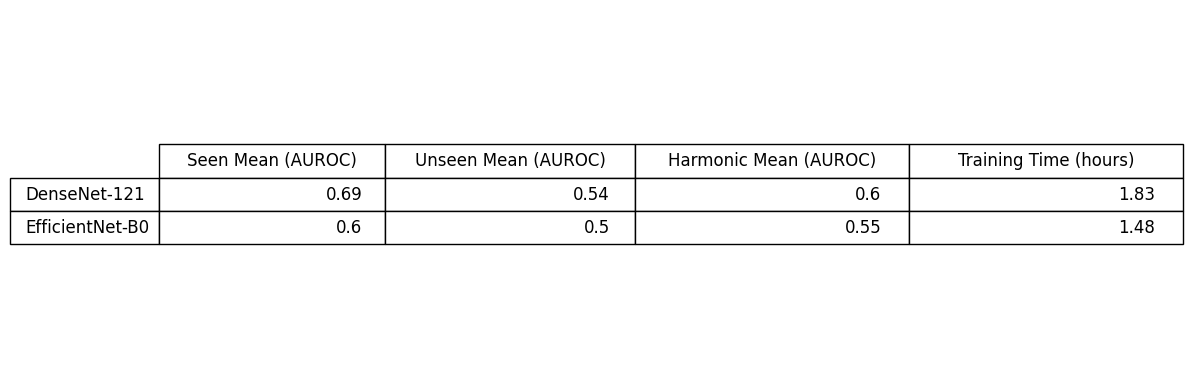

In [16]:
df = pd.DataFrame(results).T.round(2)

fig, ax = plt.subplots()
ax.axis('off')

tbl = table(ax, df, loc='center', colWidths=[ 0.02 * (len(col)+2) for col in df.columns.tolist() ])
tbl.auto_set_font_size(False)
tbl.set_fontsize(12)
tbl.scale(1.2, 2)

plt.savefig("extension.png", dpi=300, bbox_inches='tight')
plt.show()

os.replace("extension.png", f"{DRIVE_PATH}/extension.png")